# Libraries

In [53]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import pickle
import zipfile
import math
import random
import geopandas
import adjustText

from collections import defaultdict
from sklearn.metrics import ndcg_score
from scipy.stats import entropy, pearsonr, kendalltau, gaussian_kde
from scipy.spatial.distance import cosine
from scipy.linalg import norm as normf
from arch.unitroot import DFGLS

import sys
sys.path.insert(1, '../')
from helpers.io import read_as_directed_hyperedge_list, read_as_bipartite, read_as_edge_list
from helpers.io import read_classes
from helpers.config import num_samples, seed, eig_num, swaps_num 
from helpers.config import dataset_names, sampler_names, sample_path
from helpers.parser_for_output_file_names import parser_for_output_file_name as parse_file_name

In [55]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.bottom'] = True
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['axes.grid.axis'] = 'y'
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16 
matplotlib.rcParams['legend.markerscale'] = 1
matplotlib.rcParams['legend.fontsize'] = 16

In [56]:
# color palette
colors = [
    '#5941A9', # purple
    '#F71735', # red
    '#FF9000', # orange
    "#119DA4", # cyan
    "#3D1308", # brown
    "#4B9933", #green
    "#ABA9C3", #rose quartz
]

palette = sns.color_palette(colors)

In [57]:
# line styles
lss = [':', '--', '-.', '-', (1,(4,7))]

# Methods

In [58]:
def rename_null_sampler(x):
    if x == 'UnpretentiousNullModel':
        return 'Null' 
    return x

# Paths

In [59]:
results_path = '/Users/giulia/Desktop/nudhy/results/'
data_path = '../data/'

In [60]:
samplers = ['Base', 'BaseD', 'UnpretentiousNullModel', 'NuDHy_A', 'NuDHy_C']
samplers_ord = ['Base', 'BaseD', 'Null', 'NuDHy_A', 'NuDHy_C']

# Reciprocity

In [61]:
met_path = results_path + 'reciprocity/'
root = 'eco01100'

In [62]:
recip_obs_df = pd.read_csv(f'{met_path}reciprocity_{root}.tsv', sep='\t') 
recip_df = pd.DataFrame()
for f in ['_UnpretentiousNullModel', '_Base', '_BaseD', '']:
    try:
        if recip_df.empty:
            recip_df = pd.read_csv(f'{met_path}reciprocity_{root}_samples{f}.tsv', sep='\t')
        else:
            recip_df = pd.concat([recip_df, pd.read_csv(f'{met_path}reciprocity_{root}_samples{f}.tsv', sep='\t')])
    except Exception as e:
        print(e)

In [63]:
recip_df['Sampler'] = recip_df['Sampler'].apply(lambda x: rename_null_sampler(x))

In [64]:
av = recip_df.groupby(by=['Sampler', 'Sample Id']).agg({'Reciprocity':'mean'})
av = av.reset_index()
av = av.groupby(by=['Sampler']).agg({'Reciprocity':'mean'})
av = av.reset_index()

In [65]:
rr = recip_obs_df[['Reciprocity']].mean().values[0]

In [66]:
av['Diff'] = (rr - av['Reciprocity']) / rr 

In [67]:
av

Sampler  Reciprocity      Diff
0     Base     0.017290  0.934771
1    BaseD     0.066691  0.748391
2  NuDHy_A     0.139969  0.471930
3  NuDHy_B     0.142658  0.461787
4  NuDHy_C     0.152391  0.425066
5     Null     0.010642  0.959852

## Compare Results

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/2034412165.py:16: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.histplot(data=avg_rec, hue='Sampler', x='Reciprocity',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


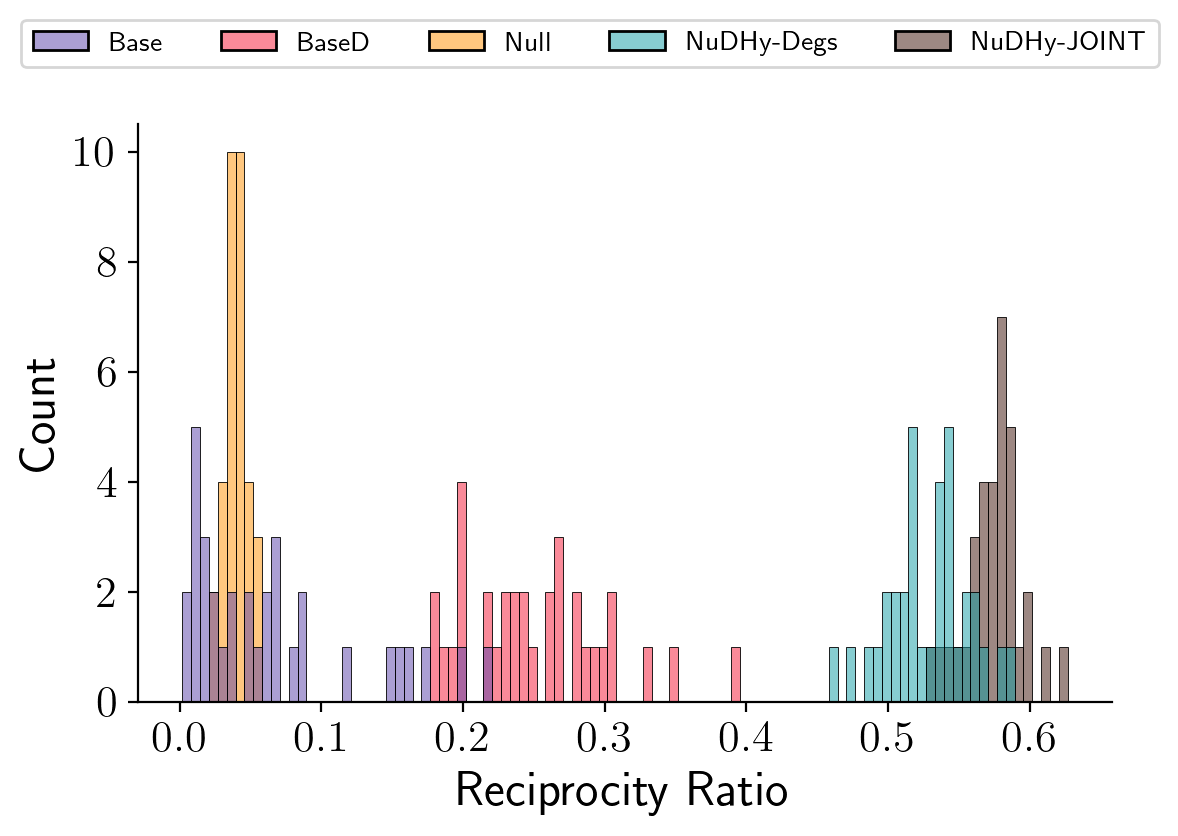

In [68]:
fig, ax = plt.subplots(figsize=(6,4))

avg_rec = recip_df.groupby(by=['Sampler',
                               'Sample Id']).agg({'Reciprocity':'mean'}).reset_index()
recip_obs = recip_obs_df['Reciprocity'].mean()

# ratio between the average reciprocity of the samples
# and the reciprocity of the observed hypergraph
avg_rec['Reciprocity'] = avg_rec['Reciprocity'] / recip_obs

first_col = 0
if 'Base' not in avg_rec['Sampler'].unique():
    first_col = 1
num_samp = len(avg_rec['Sampler'].unique())

sns.histplot(data=avg_rec, hue='Sampler', x='Reciprocity', 
             hue_order=samplers_ord[first_col:],
             bins=100, kde=False, palette=palette[first_col:num_samp], ax=ax)

legend = ax.get_legend()
handles = legend.legend_handles
labels = [sampler_names.get(text.get_text(), text.get_text()) for text in legend.get_texts()]
ax.legend().remove()
fig.legend(handles=handles, labels=labels, loc='upper center', 
           bbox_to_anchor=(0.52, 1.08), ncol=5-first_col, fontsize=10)
ax.set_xlabel('Reciprocity Ratio')

plt.tight_layout()
plt.savefig(f'{root}_reciprocity_ratio.pdf', bbox_inches='tight')
plt.show()

# Hyper-Coreness

In [69]:
met_path = results_path + 'coreness/'

In [70]:
root = 'qna_math'

observed hypergraph

In [71]:
coreness_i = pd.read_csv(met_path+f'{root}_coreness_i.tsv', sep='\t')
coreness_o = pd.read_csv(met_path+f'{root}_coreness_o.tsv', sep='\t')
# hypercoreness_i = pd.read_csv(met_path+f'{root}_hypercoreness_i.tsv', sep='\t')
# hypercoreness_o = pd.read_csv(met_path+f'{root}_hypercoreness_o.tsv', sep='\t')

samples

In [72]:
scoreness_i = pd.DataFrame()
scoreness_o = pd.DataFrame()
# shypercoreness_i = pd.DataFrame()
# shypercoreness_o = pd.DataFrame()

In [73]:
for typ in ['i', 'o']:
    for sampler in samplers:
        for sample in range(33):
            # read coreness
            core_path = f'{met_path}{root}__randomSeed_{sample}'
            core_path += f'__algorithm_{sampler}__coreness_{typ}.tsv'
            try:
                tmp = pd.read_csv(core_path, sep='\t')
            except:
                continue
            tmp['Sampler'] = rename_null_sampler(sampler)
            tmp['Sample'] = sample
            if typ == 'i':
                if scoreness_i.empty:
                    scoreness_i = tmp
                else:
                    scoreness_i = pd.concat([scoreness_i, tmp], ignore_index=True)
            else:
                if scoreness_o.empty:
                    scoreness_o = tmp
                else:
                    scoreness_o = pd.concat([scoreness_o, tmp], ignore_index=True)
            # read hypercoreness
#             hcore_path = f'{met_path}{root}__randomSeed_{sample}'
#             hcore_path += f'__algorithm_{sampler}__hypercoreness_{typ}.tsv'
#             tmp = pd.read_csv(hcore_path, sep='\t')
#             tmp['Sampler'] = rename_null_sampler(sampler)
#             tmp['Sample'] = sample
#             if typ == 'i':
#                 if shypercoreness_i.empty:
#                     shypercoreness_i = tmp
#                 else:
#                     shypercoreness_i = pd.concat([shypercoreness_i, tmp], ignore_index=True)
#             else:
#                 if shypercoreness_o.empty:
#                     shypercoreness_o = tmp
#                 else:
#                     shypercoreness_o = pd.concat([shypercoreness_o, tmp], ignore_index=True)

In [74]:
sh_i = scoreness_i.groupby(by=['Sampler', 'Sample', 'VertexId'])[['m-shellIndex']].sum().reset_index()
sh_i.columns = ['Sampler', 'Sample', 'VertexId', 'Hyper-coreness']
sh_o = scoreness_o.groupby(by=['Sampler', 'Sample', 'VertexId'])[['m-shellIndex']].sum().reset_index()
sh_o.columns = ['Sampler', 'Sample', 'VertexId', 'Hyper-coreness']
h_i = coreness_i.groupby(by=['VertexId'])[['m-shellIndex']].sum().reset_index()
h_i.columns = ['VertexId', 'Hyper-coreness']
h_o = coreness_o.groupby(by=['VertexId'])[['m-shellIndex']].sum().reset_index()
h_o.columns = ['VertexId', 'Hyper-coreness']

In [75]:
# hcr_i = hypercoreness_i.copy()
hcr_i = h_i.copy()
hcr_i.rename(columns={'Hyper-coreness': f'{root}'}, inplace=True)
hcr_i.set_index('VertexId', inplace=True)
# hcr_o = hypercoreness_o.copy()
hcr_o = h_o.copy()
hcr_o.rename(columns={'Hyper-coreness': f'{root}'}, inplace=True)
hcr_o.set_index('VertexId', inplace=True)

## Side-by-side distributions

In [76]:
order = [x for x in samplers_ord if x in sh_o['Sampler'].unique()]

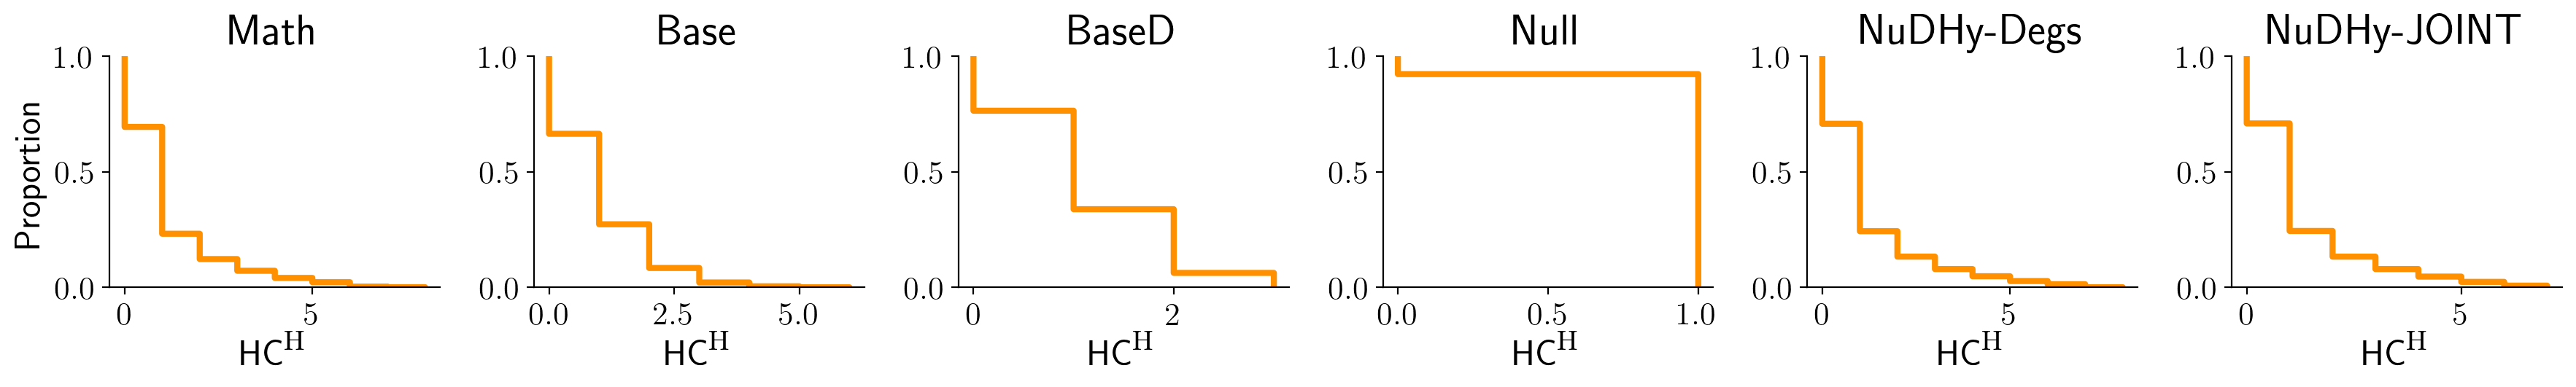

In [77]:
fig, ax = plt.subplots(1, len(order)+1, figsize=(18, 3))

sns.ecdfplot(data=hcr_o, x=root, ax=ax[0], 
             color=colors[2], complementary=True, linewidth=3)
ax[0].set_title(dataset_names[root])
ax[0].set_xlabel(r'$\mathsf{HC}^\textsc{h}$')

for i, s in enumerate(order):
    data = sh_o[sh_o['Sampler']==s].copy()
    
#     sns.boxplot(data=data[data['Sampler']==s], y='PageRank', ax=ax[i], 
#                 color=colors[0], width=.6)
    sns.ecdfplot(data=data, x='Hyper-coreness', ax=ax[i+1], 
                color=colors[2], complementary=True, linewidth=3)
    ax[i+1].set_ylabel('')
    ax[i+1].set_xlabel(r'$\mathsf{HC}^\textsc{h}$')
    ax[i+1].set_title(sampler_names.get(s, s))
plt.tight_layout()
plt.savefig(f'{root}_out-hyper-coreness_distrib.pdf', bbox_inches='tight')
plt.show()

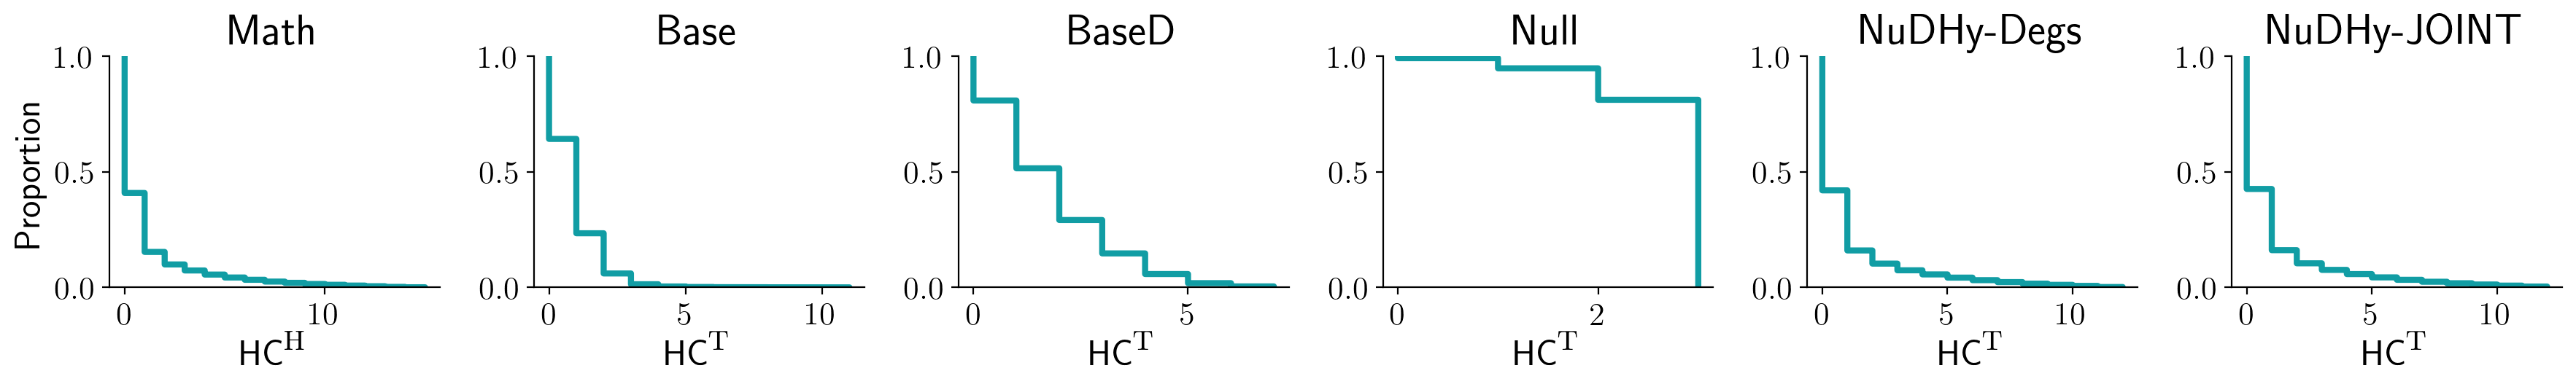

In [78]:
fig, ax = plt.subplots(1, len(order)+1, figsize=(18, 3))


sns.ecdfplot(data=hcr_i, x=root, ax=ax[0], 
             color=colors[3], complementary=True, linewidth=3)
ax[0].set_title(dataset_names[root])
ax[0].set_xlabel(r'$\mathsf{HC}^\textsc{h}$')

for i, s in enumerate(order):
    data = sh_i[sh_i['Sampler']==s].copy()
    sns.ecdfplot(data=data, x='Hyper-coreness', ax=ax[i+1], 
                color=colors[3], complementary=True, linewidth=3)
    ax[i+1].set_ylabel('')
    ax[i+1].set_xlabel(r'$\mathsf{HC}^\textsc{t}$')
    ax[i+1].set_title(sampler_names.get(s, s))
plt.tight_layout()
plt.savefig(f'{root}_in-hyper-coreness_distrib.pdf', bbox_inches='tight')
plt.show()

## Vertex-wise Hyper-coreness Scatterplots
head- and tail-hyper-coreness of each vertex: average in the samples vs observed value

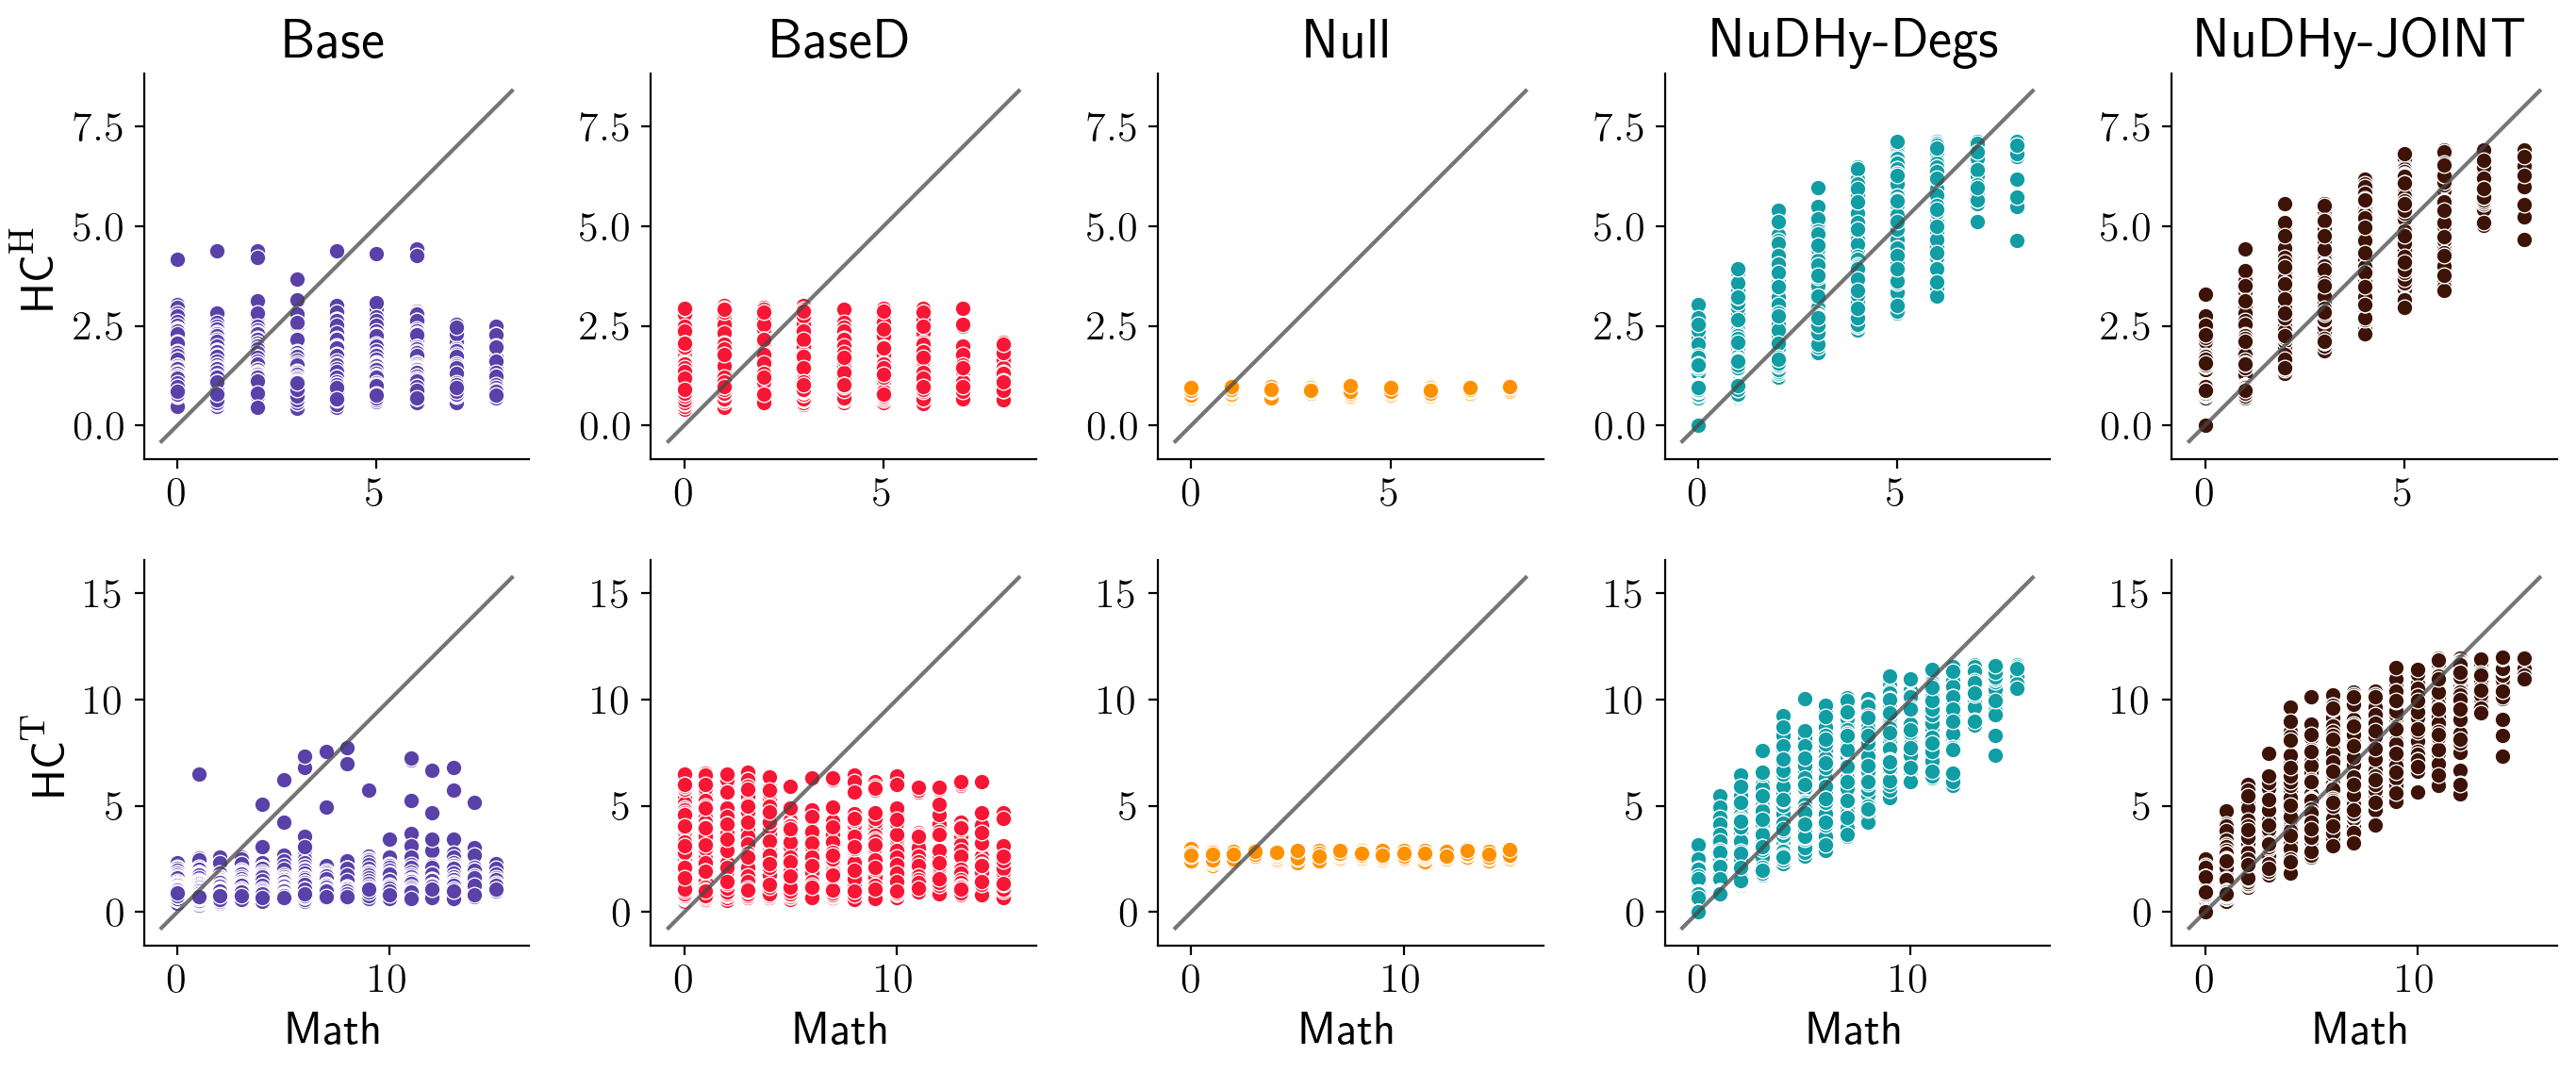

In [79]:
num_sampls = len(sh_o['Sampler'].unique())

fig, ax = plt.subplots(2, num_sampls, figsize=(14,6))

row_counter = 0

for idx, sampler in enumerate(samplers_ord):
    
    # o-hypercoreness
    tmp_res_df = sh_o[sh_o['Sampler']==sampler].copy()
    if tmp_res_df.empty: 
        continue
    tmp_res_df = tmp_res_df.groupby(by='VertexId')[['Hyper-coreness']].mean()
    tmp_res_df = hcr_o.join(tmp_res_df)
    tmp_res_df.rename(columns={'Hyper-coreness': f'{sampler}'}, inplace=True)
    data1 = tmp_res_df

    sns.scatterplot(data=data1, x=root, y=sampler, 
                    color=colors[idx], ax=ax[0][row_counter])
    if row_counter == 0:
        ax[0][row_counter].set_ylabel(r'$\mathsf{HC}^\textsc{h}$')
    else:
        ax[0][row_counter].set_ylabel('')
    ax[0][row_counter].set_xlabel('')
    ax[0][row_counter].set_title(sampler_names.get(sampler, sampler))
    lims = [
        np.min([ax[0][row_counter].get_xlim(), ax[0][row_counter].get_ylim()]),  # min of both axes
        np.max([ax[0][row_counter].get_xlim(), ax[0][row_counter].get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax[0][row_counter].plot(lims, lims, alpha=0.75, zorder=1, color='#474747')
    ax[0][row_counter].set_aspect('equal')

    # i-hypercoreness
    tmp_res_df = sh_i[sh_i['Sampler']==sampler].copy()
    tmp_res_df = tmp_res_df.groupby(by='VertexId')[['Hyper-coreness']].mean()
    tmp_res_df = hcr_i.join(tmp_res_df)
    tmp_res_df.rename(columns={'Hyper-coreness': f'{sampler}'}, inplace=True)
    data2 = tmp_res_df

    sns.scatterplot(data=data2, x=f'{root}', y=f'{sampler}', 
                    color=colors[idx], ax=ax[1][row_counter])
    if row_counter == 0:
        ax[1][row_counter].set_ylabel(r'$\mathsf{HC}^\textsc{t}$')
    else:
        ax[1][row_counter].set_ylabel('')
    ax[1][row_counter].set_xlabel(dataset_names[root])
    lims = [
        np.min([ax[1][row_counter].get_xlim(), ax[1][row_counter].get_ylim()]),  # min of both axes
        np.max([ax[1][row_counter].get_xlim(), ax[1][row_counter].get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax[1][row_counter].plot(lims, lims, alpha=0.75, zorder=1, color='#474747')
    ax[1][row_counter].set_aspect('equal')
    
    row_counter += 1
plt.tight_layout()
plt.savefig(f'{root}_scatter_hypercoreness.pdf', bbox_inches='tight')
plt.show()

### Scatterplot with a sample of points
Code to use to improve the rendering for large datasets

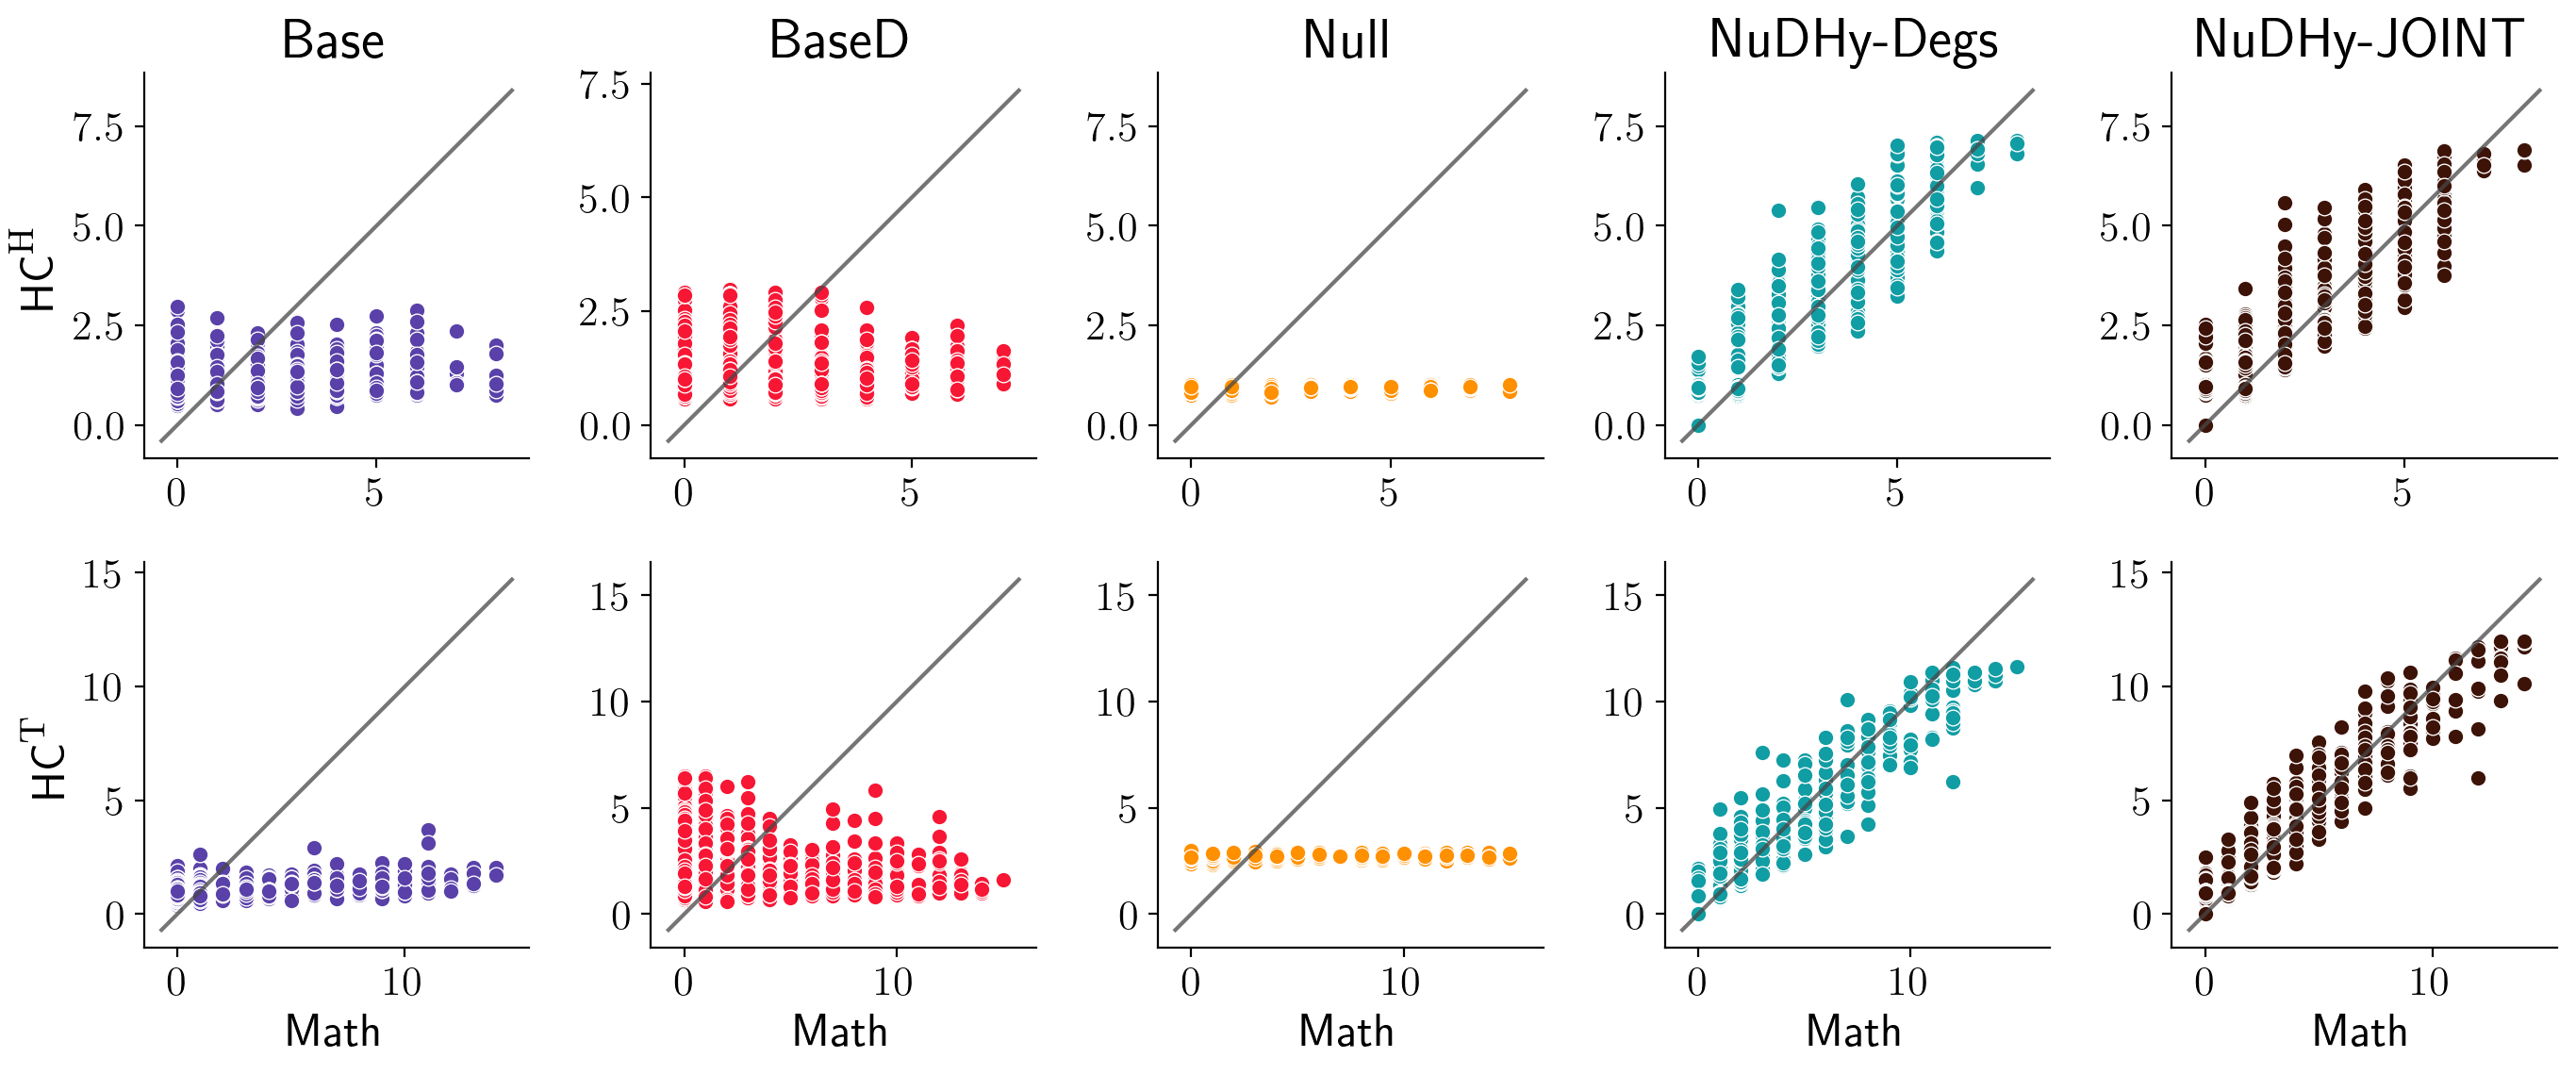

In [80]:
num_sampls = len(sh_o['Sampler'].unique())

fig, ax = plt.subplots(2, num_sampls, figsize=(14,6))

row_counter = 0

for idx, sampler in enumerate(samplers_ord):
    
    # o-hypercoreness
    tmp_res_df = sh_o[sh_o['Sampler']==sampler].copy()
    if tmp_res_df.empty: 
        continue
    tmp_res_df = tmp_res_df.groupby(by='VertexId')[['Hyper-coreness']].mean()
    tmp_res_df = hcr_o.join(tmp_res_df)
    tmp_res_df.rename(columns={'Hyper-coreness': f'{sampler}'}, inplace=True)
    
    sample_size = int(len(tmp_res_df) * 0.1)
    vids = random.sample(range(max(tmp_res_df.index)+1), sample_size)
    data1 = tmp_res_df.loc[vids]

    sns.scatterplot(data=data1, x=root, y=sampler, 
                    color=colors[idx], ax=ax[0][row_counter])
    if row_counter == 0:
        ax[0][row_counter].set_ylabel(r'$\mathsf{HC}^\textsc{h}$')
    else:
        ax[0][row_counter].set_ylabel('')
    ax[0][row_counter].set_xlabel('')
    ax[0][row_counter].set_title(sampler_names.get(sampler, sampler))
    lims = [
        np.min([ax[0][row_counter].get_xlim(), ax[0][row_counter].get_ylim()]),  # min of both axes
        np.max([ax[0][row_counter].get_xlim(), ax[0][row_counter].get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax[0][row_counter].plot(lims, lims, alpha=0.75, zorder=1, color='#474747')
    ax[0][row_counter].set_aspect('equal')

    # i-hypercoreness
    tmp_res_df = sh_i[sh_i['Sampler']==sampler].copy()
    tmp_res_df = tmp_res_df.groupby(by='VertexId')[['Hyper-coreness']].mean()
    tmp_res_df = hcr_i.join(tmp_res_df)
    tmp_res_df.rename(columns={'Hyper-coreness': f'{sampler}'}, inplace=True)
    
    data2 = tmp_res_df.loc[vids]

    sns.scatterplot(data=data2, x=f'{root}', y=f'{sampler}', 
                    color=colors[idx], ax=ax[1][row_counter])
    if row_counter == 0:
        ax[1][row_counter].set_ylabel(r'$\mathsf{HC}^\textsc{t}$')
    else:
        ax[1][row_counter].set_ylabel('')
    ax[1][row_counter].set_xlabel(dataset_names[root])
    lims = [
        np.min([ax[1][row_counter].get_xlim(), ax[1][row_counter].get_ylim()]),  # min of both axes
        np.max([ax[1][row_counter].get_xlim(), ax[1][row_counter].get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax[1][row_counter].plot(lims, lims, alpha=0.75, zorder=1, color='#474747')
    ax[1][row_counter].set_aspect('equal')
    
    row_counter += 1
plt.tight_layout()
plt.savefig(f'{root}_scatter_hypercoreness_10.pdf', bbox_inches='tight')
plt.show()

## Distribution of Studentized Scores
For each observed head- and tail-hyper-coreness value, we plot the distribution of the "studentized" values obtained using the values measured in the samples, to see if we make more "mistakes" for some observed values rather than for others.

In [81]:
def compute_std_scores(df, df2, sampler, r):
    hcs = df[df['Sampler'] == sampler].copy()
    hcs = hcs.groupby(by='VertexId').agg({'Hyper-coreness': ['mean', 'std']})
    hcs.columns = ['Mean', 'STD']
    hcs = df2.join(hcs)
    hcs.fillna(0, inplace=True)
    hcs['STD'].replace([0], 1, inplace=True)
    hcs['Std. Hyper-coreness'] = (hcs[f'{root}'] - hcs['Mean']) / hcs['STD']
    hcs['Algorithm'] = sampler
    return hcs[[r, 'Std. Hyper-coreness', 'Algorithm']]

In [82]:
row_i = pd.DataFrame()
row_o = pd.DataFrame()

for sampler in sh_i['Sampler'].unique():
    hcs_i = compute_std_scores(sh_i, hcr_i, sampler, root)
    if row_i.empty:
        row_i = hcs_i.reset_index()
    else:
        row_i = pd.concat([row_i, hcs_i.reset_index()], ignore_index=True)
    hcs_o = compute_std_scores(sh_o, hcr_o, sampler, root)
    if row_o.empty:
        row_o = hcs_o.reset_index()
    else:
        row_o = pd.concat([row_o, hcs_o.reset_index()], ignore_index=True)

In [83]:
row_o.fillna(0, inplace=True)
row_i.fillna(0, inplace=True)

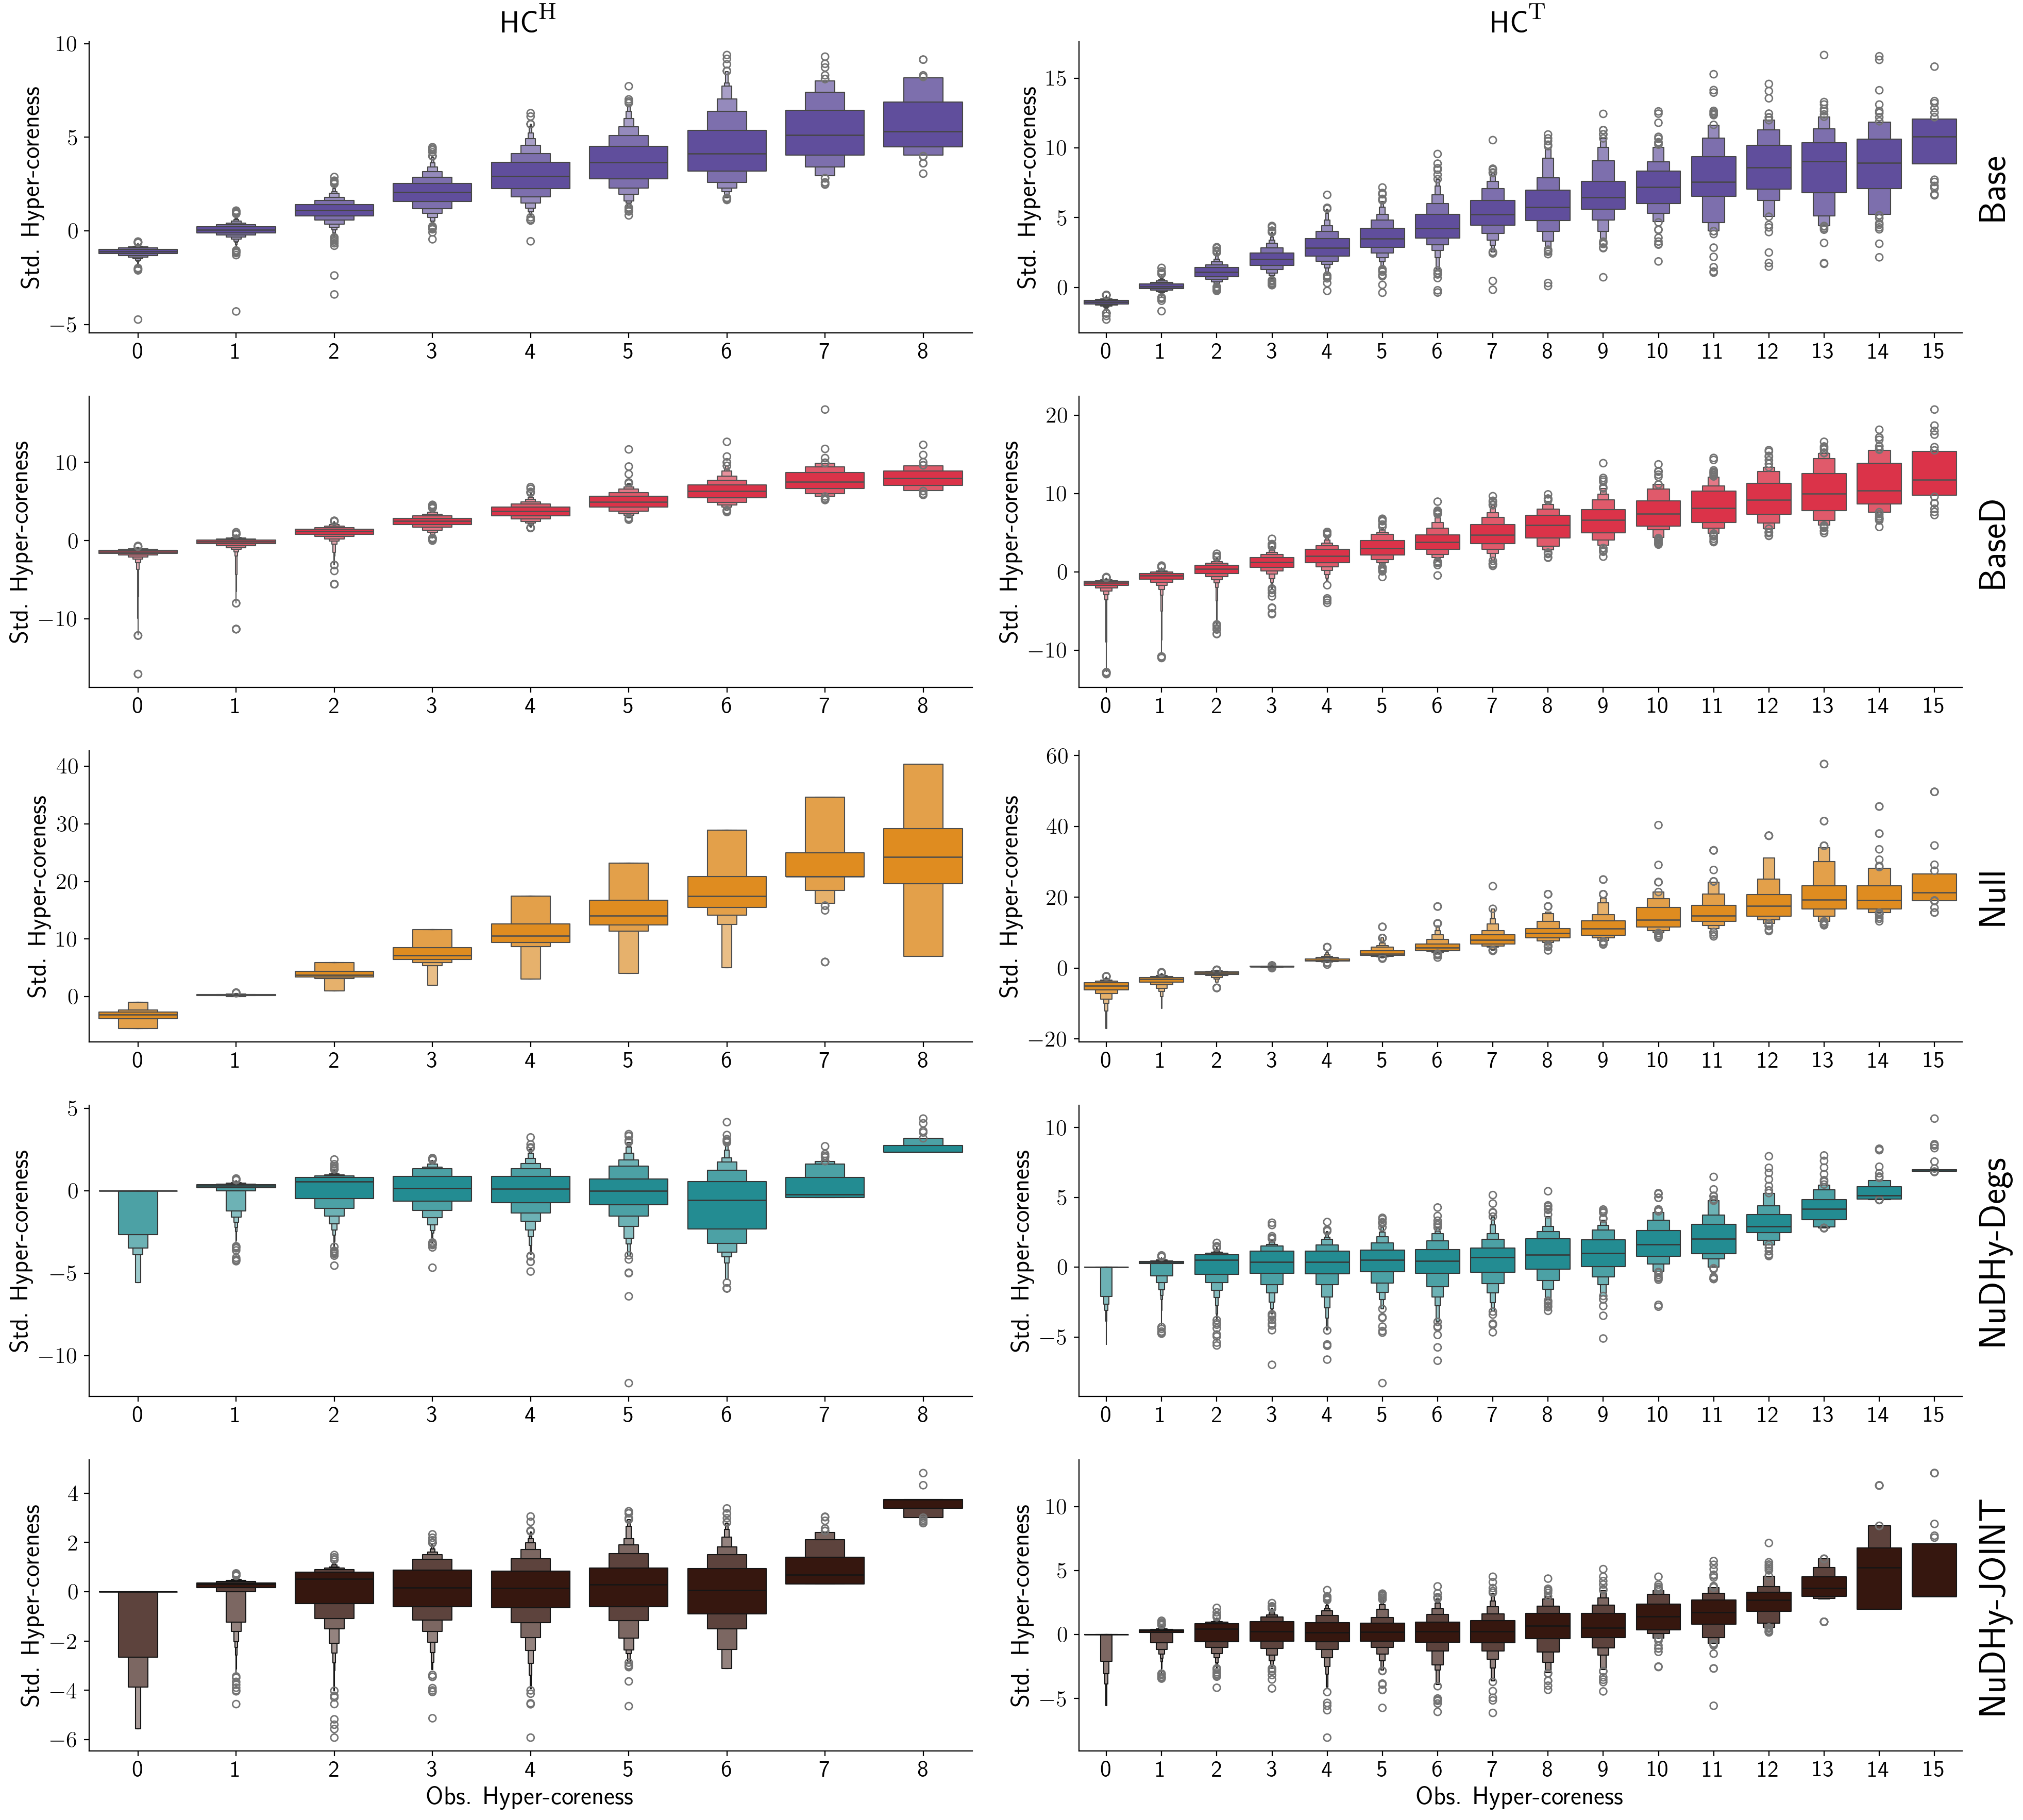

In [84]:
num_sampls = len(row_o['Algorithm'].unique())

fig, ax = plt.subplots(num_sampls, 2, figsize=(20,18))

row_counter = 0

for idx, sampler in enumerate(samplers_ord):
    
    data = row_o[row_o['Algorithm']==sampler].copy()
    
    if data.empty: continue
        
    data.replace([np.inf, -np.inf], 0, inplace=True)

    sns.boxenplot(data=data, x=root, y='Std. Hyper-coreness', color=colors[idx], ax=ax[row_counter][0])
    if idx < num_sampls - 1:
        ax[row_counter][0].set_xlabel('')
    else:
        ax[row_counter][0].set_xlabel('Obs. Hyper-coreness')
    if idx == 0:
        ax[row_counter][0].set_title(r'$\mathsf{HC}^\textsc{h}$')

    data = row_i[row_i['Algorithm']==sampler].copy()
    data.replace([np.inf, -np.inf], 0, inplace=True)

    sns.boxenplot(data=data, x=root, y='Std. Hyper-coreness', color=colors[idx], ax=ax[row_counter][1])
    if idx < num_sampls - 1:
        ax[row_counter][1].set_xlabel('')
    else:
        ax[row_counter][1].set_xlabel('Obs. Hyper-coreness')
    if idx == 0:
        ax[row_counter][1].set_title(r'$\mathsf{HC}^\textsc{t}$')
    ax[row_counter][1].text(1.02, 0.5, sampler_names.get(sampler, sampler), 
                            transform=ax[row_counter][1].transAxes,
                            fontsize=26, rotation=90, va='center')
    row_counter += 1
plt.tight_layout()
plt.savefig(f'{root}_std_hypercoreness.pdf', bbox_inches='tight')
plt.show()

## Similarity between Hyper-coreness Vectors

In [85]:
def sorting_f(x, hc, col):
    if x not in hc.index:
        return 0
    return - hc.loc[x, col]

Node ranking in observed hypergraph

In [86]:
rank_i = np.zeros(max(hcr_i.index))
rank_o = np.zeros(max(hcr_o.index))

ranking_reals = sorted([x for x in np.arange(len(rank_i))], key = lambda x: sorting_f(x, hcr_i, root))
for idx in range(len(ranking_reals)):
    rank_i[ranking_reals[idx]] = idx
ranking_reals = sorted([x for x in np.arange(len(rank_o))], key = lambda x: sorting_f(x, hcr_o, root))
for idx in range(len(ranking_reals)):
    rank_o[ranking_reals[idx]] = idx

Node ranking in samples

In [87]:
rows = []
for sampler in sh_o['Sampler'].unique():
    for sample in sh_o['Sample'].unique():
        tmp_res_df = sh_o[(sh_o['Sampler']==sampler) &
                          (sh_o['Sample']==sample)].copy()
        tmp_res_df = tmp_res_df.set_index(['VertexId'])
        avg_res_df = tmp_res_df.join(hcr_o, how='right')
        avg_res_df.fillna(0, inplace=True)

        rank_nodes = np.zeros(len(rank_o))
        ranking = sorted([x for x in np.arange(len(rank_nodes))], 
                         key = lambda x: sorting_f(x, avg_res_df, 'Hyper-coreness'))
        for idx in range(len(ranking)):
            rank_nodes[ranking[idx]] = idx

        pred_scores = avg_res_df.sort_index()['Hyper-coreness'].values
        pred_s = np.array([pred_scores])    
        true_scores = avg_res_df.sort_index()[root].values
        true_s = np.array([true_scores])

        pear = round(pearsonr(rank_i, rank_nodes)[0], 3)
        kt = round(kendalltau(rank_i, rank_nodes)[0], 3)
        nDCG = round(ndcg_score(true_s, pred_s, ignore_ties=True), 3)
        

        rows.append([sampler, sample, r'$\mathsf{HC}^h$', pear, kt, nDCG])

In [88]:
o_comparison = pd.DataFrame(rows, columns=['Sampler', 'Sample', 'Score', 'Pearson', 'Kendall-Tau', 'nDCG'])

In [89]:
rows = []
for sampler in sh_i['Sampler'].unique():
    for sample in sh_o['Sample'].unique():
        tmp_res_df = sh_i[(sh_i['Sampler']==sampler) &
                          (sh_i['Sample']==sample)].copy()
        tmp_res_df = tmp_res_df.set_index(['VertexId'])
        avg_res_df = tmp_res_df.join(hcr_i, how='right')
        avg_res_df.fillna(0, inplace=True)

        rank_nodes = np.zeros(len(rank_i))
        ranking = sorted([x for x in np.arange(len(rank_nodes))], 
                         key = lambda x: sorting_f(x, avg_res_df, 'Hyper-coreness'))
        for idx in range(len(ranking)):
            rank_nodes[ranking[idx]] = idx

        pred_scores = avg_res_df.sort_index()['Hyper-coreness'].values
        pred_s = np.array([pred_scores])    
        true_scores = avg_res_df.sort_index()[root].values
        true_s = np.array([true_scores])

        pear = round(pearsonr(rank_i, rank_nodes)[0], 3)
        kt = round(kendalltau(rank_i, rank_nodes)[0], 3)
        nDCG = round(ndcg_score(true_s, pred_s, ignore_ties=True), 3)

        rows.append([sampler, sample, r'$\mathsf{HC}^t$', pear, kt, nDCG])

In [90]:
i_comparison = pd.DataFrame(rows, columns=['Sampler', 'Sample', 'Score', 'Pearson', 'Kendall-Tau', 'nDCG'])

## Output Table

In [91]:
output = pd.concat([o_comparison, i_comparison])
output = output.groupby(by=['Sampler', 'Score'])[['nDCG']].agg(['mean', 'std']).transpose()

In [92]:
print(output.to_latex())

\begin{tabular}{llrrrrrrrrrr}
\toprule
 & Sampler & \multicolumn{2}{r}{Base} & \multicolumn{2}{r}{BaseD} & \multicolumn{2}{r}{NuDHy_A} & \multicolumn{2}{r}{NuDHy_C} & \multicolumn{2}{r}{Null} \\
 & Score & $\mathsf{HC}^h$ & $\mathsf{HC}^t$ & $\mathsf{HC}^h$ & $\mathsf{HC}^t$ & $\mathsf{HC}^h$ & $\mathsf{HC}^t$ & $\mathsf{HC}^h$ & $\mathsf{HC}^t$ & $\mathsf{HC}^h$ & $\mathsf{HC}^t$ \\
\midrule
\multirow[t]{2}{*}{nDCG} & mean & 0.872394 & 0.798545 & 0.863212 & 0.763909 & 0.985636 & 0.986667 & 0.985788 & 0.988394 & 0.862121 & 0.762727 \\
 & std & 0.001171 & 0.002575 & 0.000857 & 0.001100 & 0.000699 & 0.001051 & 0.000893 & 0.000556 & 0.000485 & 0.002440 \\
\cline{1-12}
\bottomrule
\end{tabular}



# Structural Entropy

In [93]:
met_path = results_path + 'entropy'

In [94]:
root = 'dblp_v9'

In [95]:
# Sampler, Size, Probability
h_prob_df = pd.read_csv(f'{met_path}/{root}.tsv__numSamples_{num_samples}__seed_{seed}__heads.tsv', sep='\t')
for samp in samplers[:-2]:
    try:
        tmp1 = pd.read_csv(f'{met_path}/{root}.tsv__numSamples_{num_samples}__algorithm_{samp}__heads.tsv', sep='\t')
        h_prob_df = pd.concat([h_prob_df, tmp1])
    except:
        continue
h_prob_df = h_prob_df[h_prob_df['Size']!='Size']
h_prob_df = h_prob_df.astype(dtype={'Size':np.int32, 'Probability':np.float64})
t_prob_df = pd.read_csv(f'{met_path}/{root}.tsv__numSamples_{num_samples}__seed_{seed}__tails.tsv', sep='\t')
for samp in samplers[:-2]:
    try:
        tmp2 = pd.read_csv(f'{met_path}/{root}.tsv__numSamples_{num_samples}__algorithm_{samp}__tails.tsv', sep='\t')
        t_prob_df = pd.concat([t_prob_df, tmp2])
    except:
        continue
t_prob_df = t_prob_df[t_prob_df['Size']!='Size']
t_prob_df = t_prob_df.astype(dtype={'Size':np.int32, 'Probability':np.float64})

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/2402523797.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  h_prob_df = pd.read_csv(f'{met_path}/{root}.tsv__numSamples_{num_samples}__seed_{seed}__heads.tsv', sep='\t')


In [96]:
h_prob_df['Sampler'] = h_prob_df['Sampler'].apply(lambda x: rename_null_sampler(x))
t_prob_df['Sampler'] = t_prob_df['Sampler'].apply(lambda x: rename_null_sampler(x))

In [97]:
first_col = 0
if 'Base' not in h_prob_df['Sampler'].unique():
    first_col = 1
num_samp = len(h_prob_df['Sampler'].unique())

## Comparison

In [98]:
ov_sizes = set(h_prob_df['Size'])
ov_sizes.update(t_prob_df['Size'])
ov_sizes = sorted(list(ov_sizes))

### Side-by-side distributions

In [99]:
order = [x for x in samplers_ord if x in h_prob_df['Sampler'].unique()]

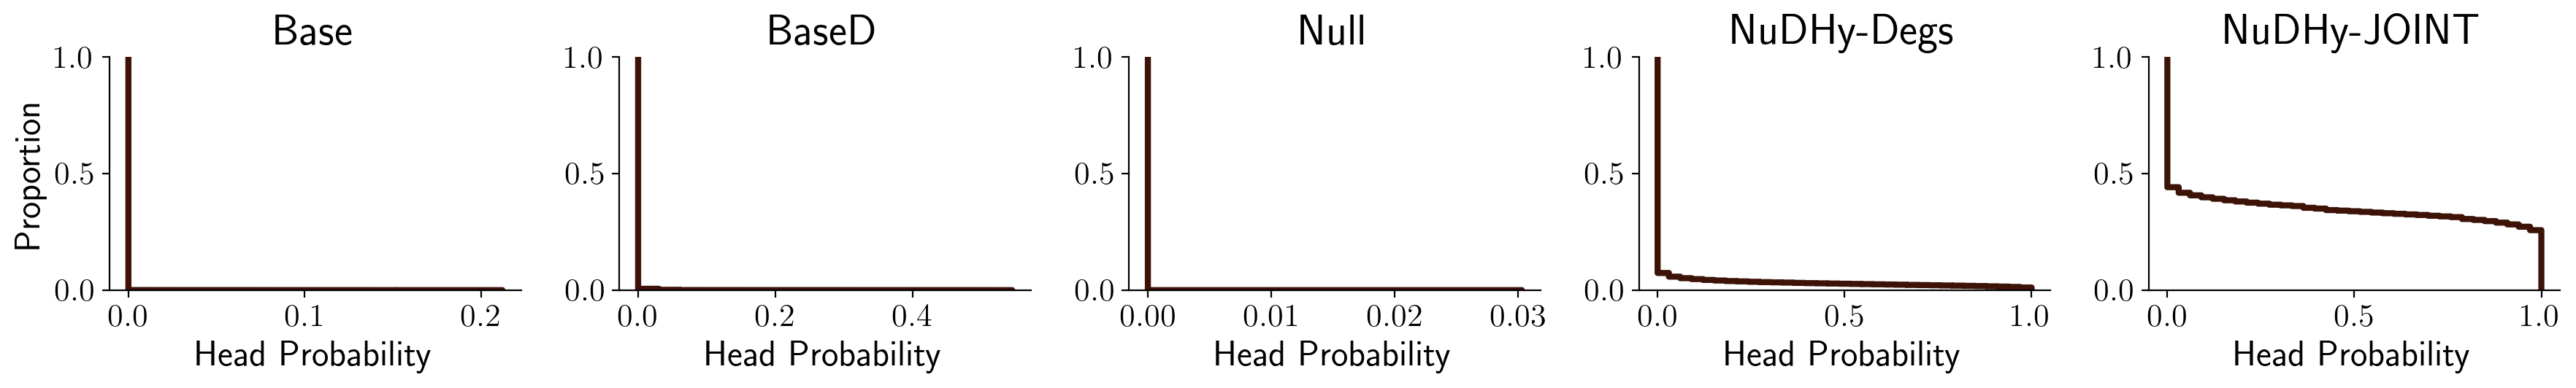

In [100]:
fig, ax = plt.subplots(1, len(order), figsize=(18, 3))

data = h_prob_df[h_prob_df['Size']==3]

for i, s in enumerate(order):

    data2 = data[data['Sampler']==s].copy()
    
    sns.ecdfplot(data=data2, x='Probability', ax=ax[i], 
                color=colors[4], complementary=True, linewidth=3)
    if i > 0:
        ax[i].set_ylabel('')
    ax[i].set_xlabel('Head Probability')
    ax[i].set_title(sampler_names.get(s, s))
plt.tight_layout()
plt.savefig(f'{root}_head_cum_prob_distrib.pdf', bbox_inches='tight')
plt.show()

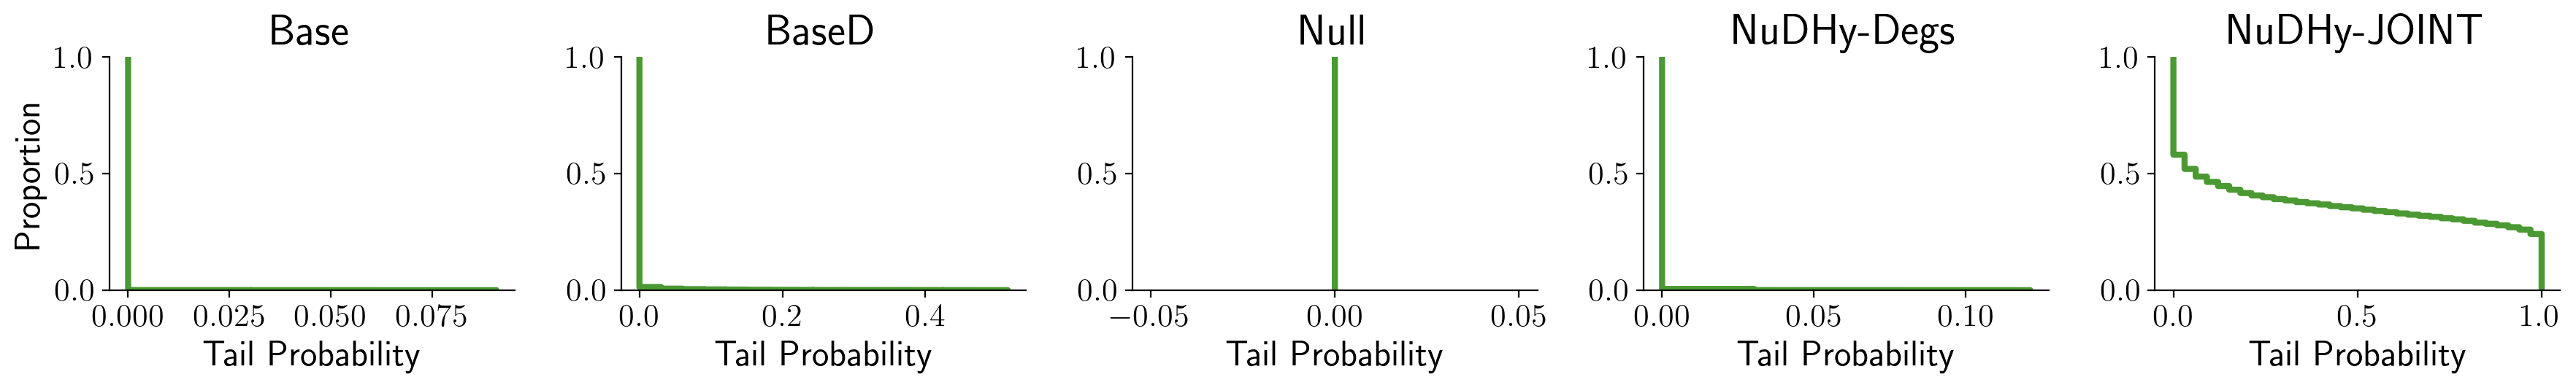

In [101]:
fig, ax = plt.subplots(1, len(order), figsize=(18, 3))

data = t_prob_df[t_prob_df['Size']==3]

for i, s in enumerate(order):

    data2 = data[data['Sampler']==s].copy()
    
    sns.ecdfplot(data=data2, x='Probability', ax=ax[i], 
                color=colors[5], complementary=True, linewidth=3)
    if i > 0:
        ax[i].set_ylabel('')
    ax[i].set_xlabel('Tail Probability')
    ax[i].set_title(sampler_names.get(s, s))
plt.tight_layout()
plt.savefig(f'{root}_tail_cum_prob_distrib.pdf', bbox_inches='tight')
plt.show()

### Probability of Seeing an Observed Head Group in the Samples

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/3194077705.py:5: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  p = sns.ecdfplot(data=first, x='Probability', hue='Sampler', ax=ax[0],
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/3194077705.py:20: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  p = sns.ecdfplot(data=second, x='Probability', hue='Sampler', ax=ax[1],
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


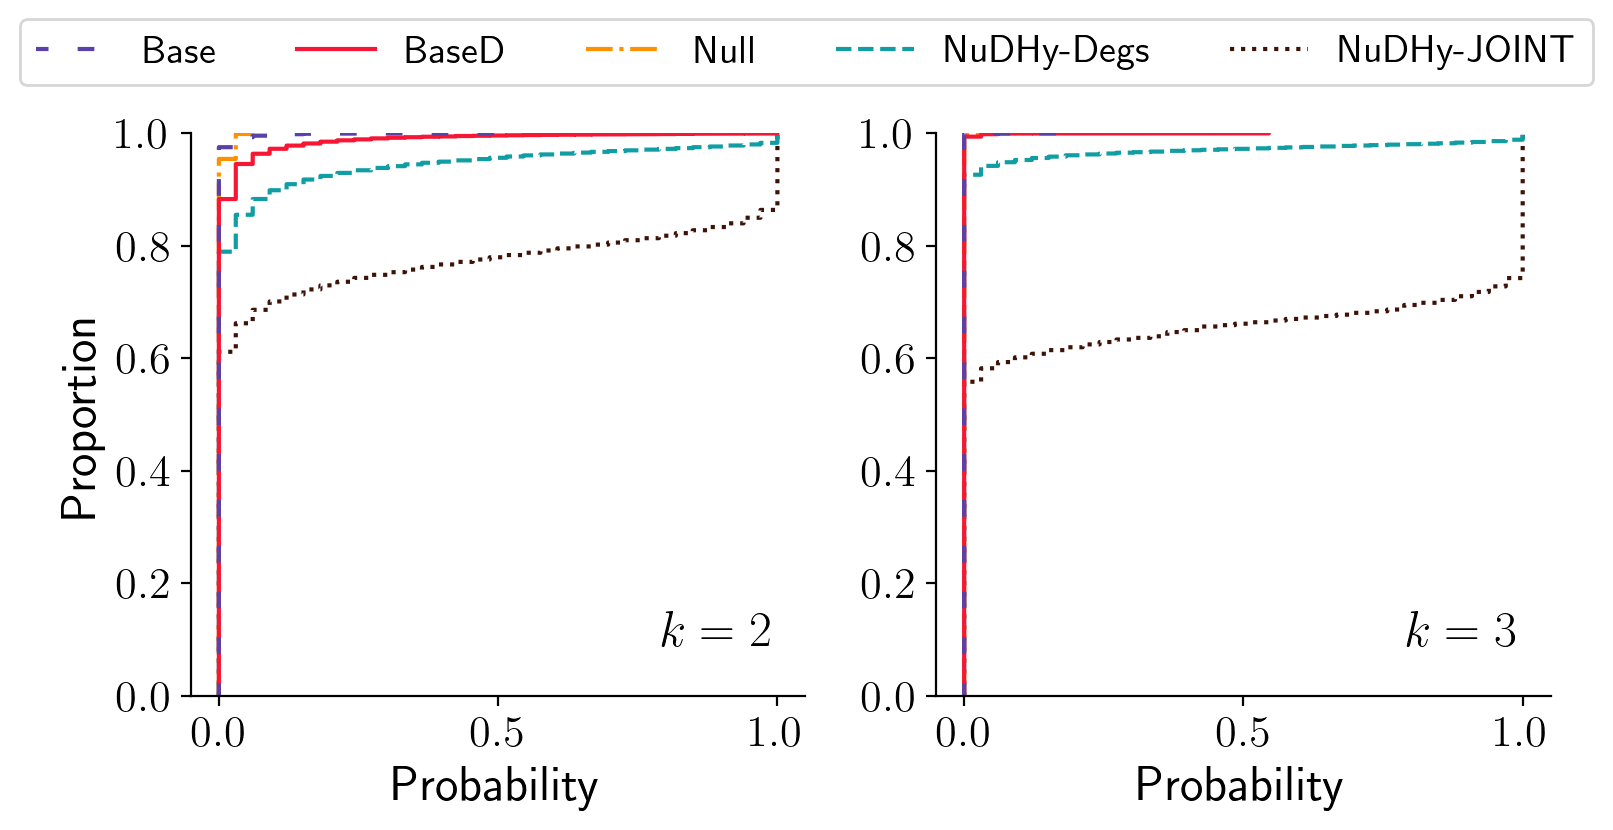

In [102]:
if not h_prob_df.empty:
    fig, ax = plt.subplots(1,2, figsize=(8,4))

    first = h_prob_df[h_prob_df['Size']==2]
    p = sns.ecdfplot(data=first, x='Probability', hue='Sampler', ax=ax[0],
                     hue_order=samplers_ord[first_col:], palette=palette[first_col:])
    handles = p.legend_.legend_handles[::-1]
    for line, ls, handle in zip(p.lines, lss, handles):
        line.set_linestyle(ls)
        handle.set_ls(ls)
    ax[0].text(.95, .15, r'$k=2$', fontsize=18, ha='right', va='top', transform=ax[0].transAxes)
    legend = ax[0].get_legend()
    handles = legend.legend_handles
    labels = [sampler_names.get(text.get_text(), text.get_text()) for text in legend.get_texts()]
    ax[0].legend().remove()
    fig.legend(handles=handles, labels=labels, loc='upper center', fontsize=14,
               bbox_to_anchor=(0.5, 1.08), ncol=5-first_col)

    second = h_prob_df[h_prob_df['Size']==3]
    p = sns.ecdfplot(data=second, x='Probability', hue='Sampler', ax=ax[1],
                     hue_order=samplers_ord[first_col:], palette=palette[first_col:])
    ax[1].set_ylabel('')
    ax[1].legend().remove()
    for line, ls in zip(p.lines, lss):
        line.set_linestyle(ls)
        handle.set_ls(ls)
    ax[1].text(.95, .15, r'$k=3$', fontsize=18, ha='right',
               va='top', transform=ax[1].transAxes)

    plt.tight_layout()
    plt.savefig(f'{root}_head_cum_prob.pdf', bbox_inches='tight')
    plt.show()

### Probability of Seeing an Observed Tail Group in the Samples

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/2945910343.py:9: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  p = sns.ecdfplot(data=first, x='Probability', hue='Sampler', ax=ax[0],
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


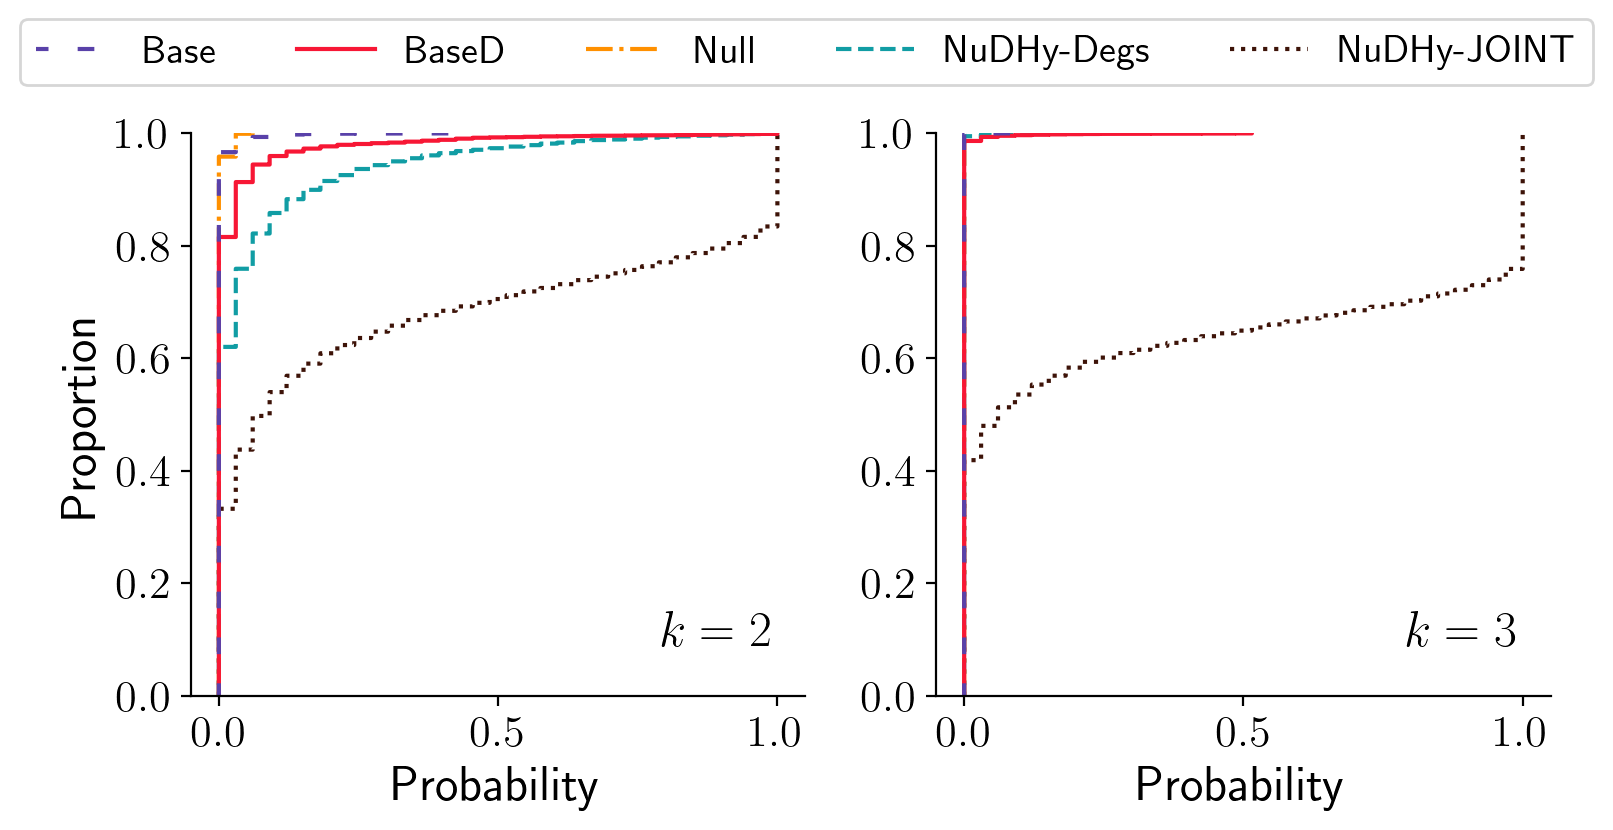

In [103]:
if not h_prob_df.empty:
    first_col = 0
    if 'Base' not in t_prob_df['Sampler'].unique():
        first_col = 1

    fig, ax = plt.subplots(1,2, figsize=(8,4))

    first = t_prob_df[t_prob_df['Size']==2]
    p = sns.ecdfplot(data=first, x='Probability', hue='Sampler', ax=ax[0],
                     hue_order=samplers_ord[first_col:], palette=palette[first_col:])
    handles = p.legend_.legend_handles[::-1]
    for line, ls, handle in zip(p.lines, lss, handles):
        line.set_linestyle(ls)
        handle.set_ls(ls)
    ax[0].text(.95, .15, r'$k=2$', fontsize=18, ha='right',
               va='top', transform=ax[0].transAxes)

    second = t_prob_df[t_prob_df['Size']==3]
    p = sns.ecdfplot(data=second, x='Probability', hue='Sampler', ax=ax[1],
                     hue_order=samplers_ord[first_col:], palette=palette[first_col:num_samp])
    ax[1].set_ylabel('')
    ax[1].legend().remove()
    for line, ls in zip(p.lines, lss):
        line.set_linestyle(ls)
        handle.set_ls(ls)
    ax[1].text(.95, .15, r'$k=3$', fontsize=18, ha='right',
               va='top', transform=ax[1].transAxes)
    
    legend = ax[0].get_legend()
    handles = legend.legend_handles
    labels = [sampler_names.get(text.get_text(), text.get_text()) for text in legend.get_texts()]
    ax[0].legend().remove()
    fig.legend(handles=handles, labels=labels, loc='upper center',
               fontsize=14, bbox_to_anchor=(0.5, 1.08), ncol=5)
    plt.tight_layout()
    plt.savefig(f'{root}_tail_cum_prob.pdf', bbox_inches='tight')
    plt.show()

## Entropy of Probabilities

In [104]:
def get_entropy(ps):
    qs = np.ones(len(ps)) - ps
    return entropy(ps) + entropy(qs)

In [105]:
def get_entropy_bits(ps):
    eps = []
    for p in ps:
        if p > 0 and p < 1:
            eps.append(-p*math.log2(p) - (1 - p)*math.log2(1 - p))
        else:
            eps.append(0)
    return eps

In [106]:
alpha = 0.1
ss = - alpha * math.log2(alpha) - (1 - alpha) * math.log2(1 - alpha)

### Head & Tail Probabilities

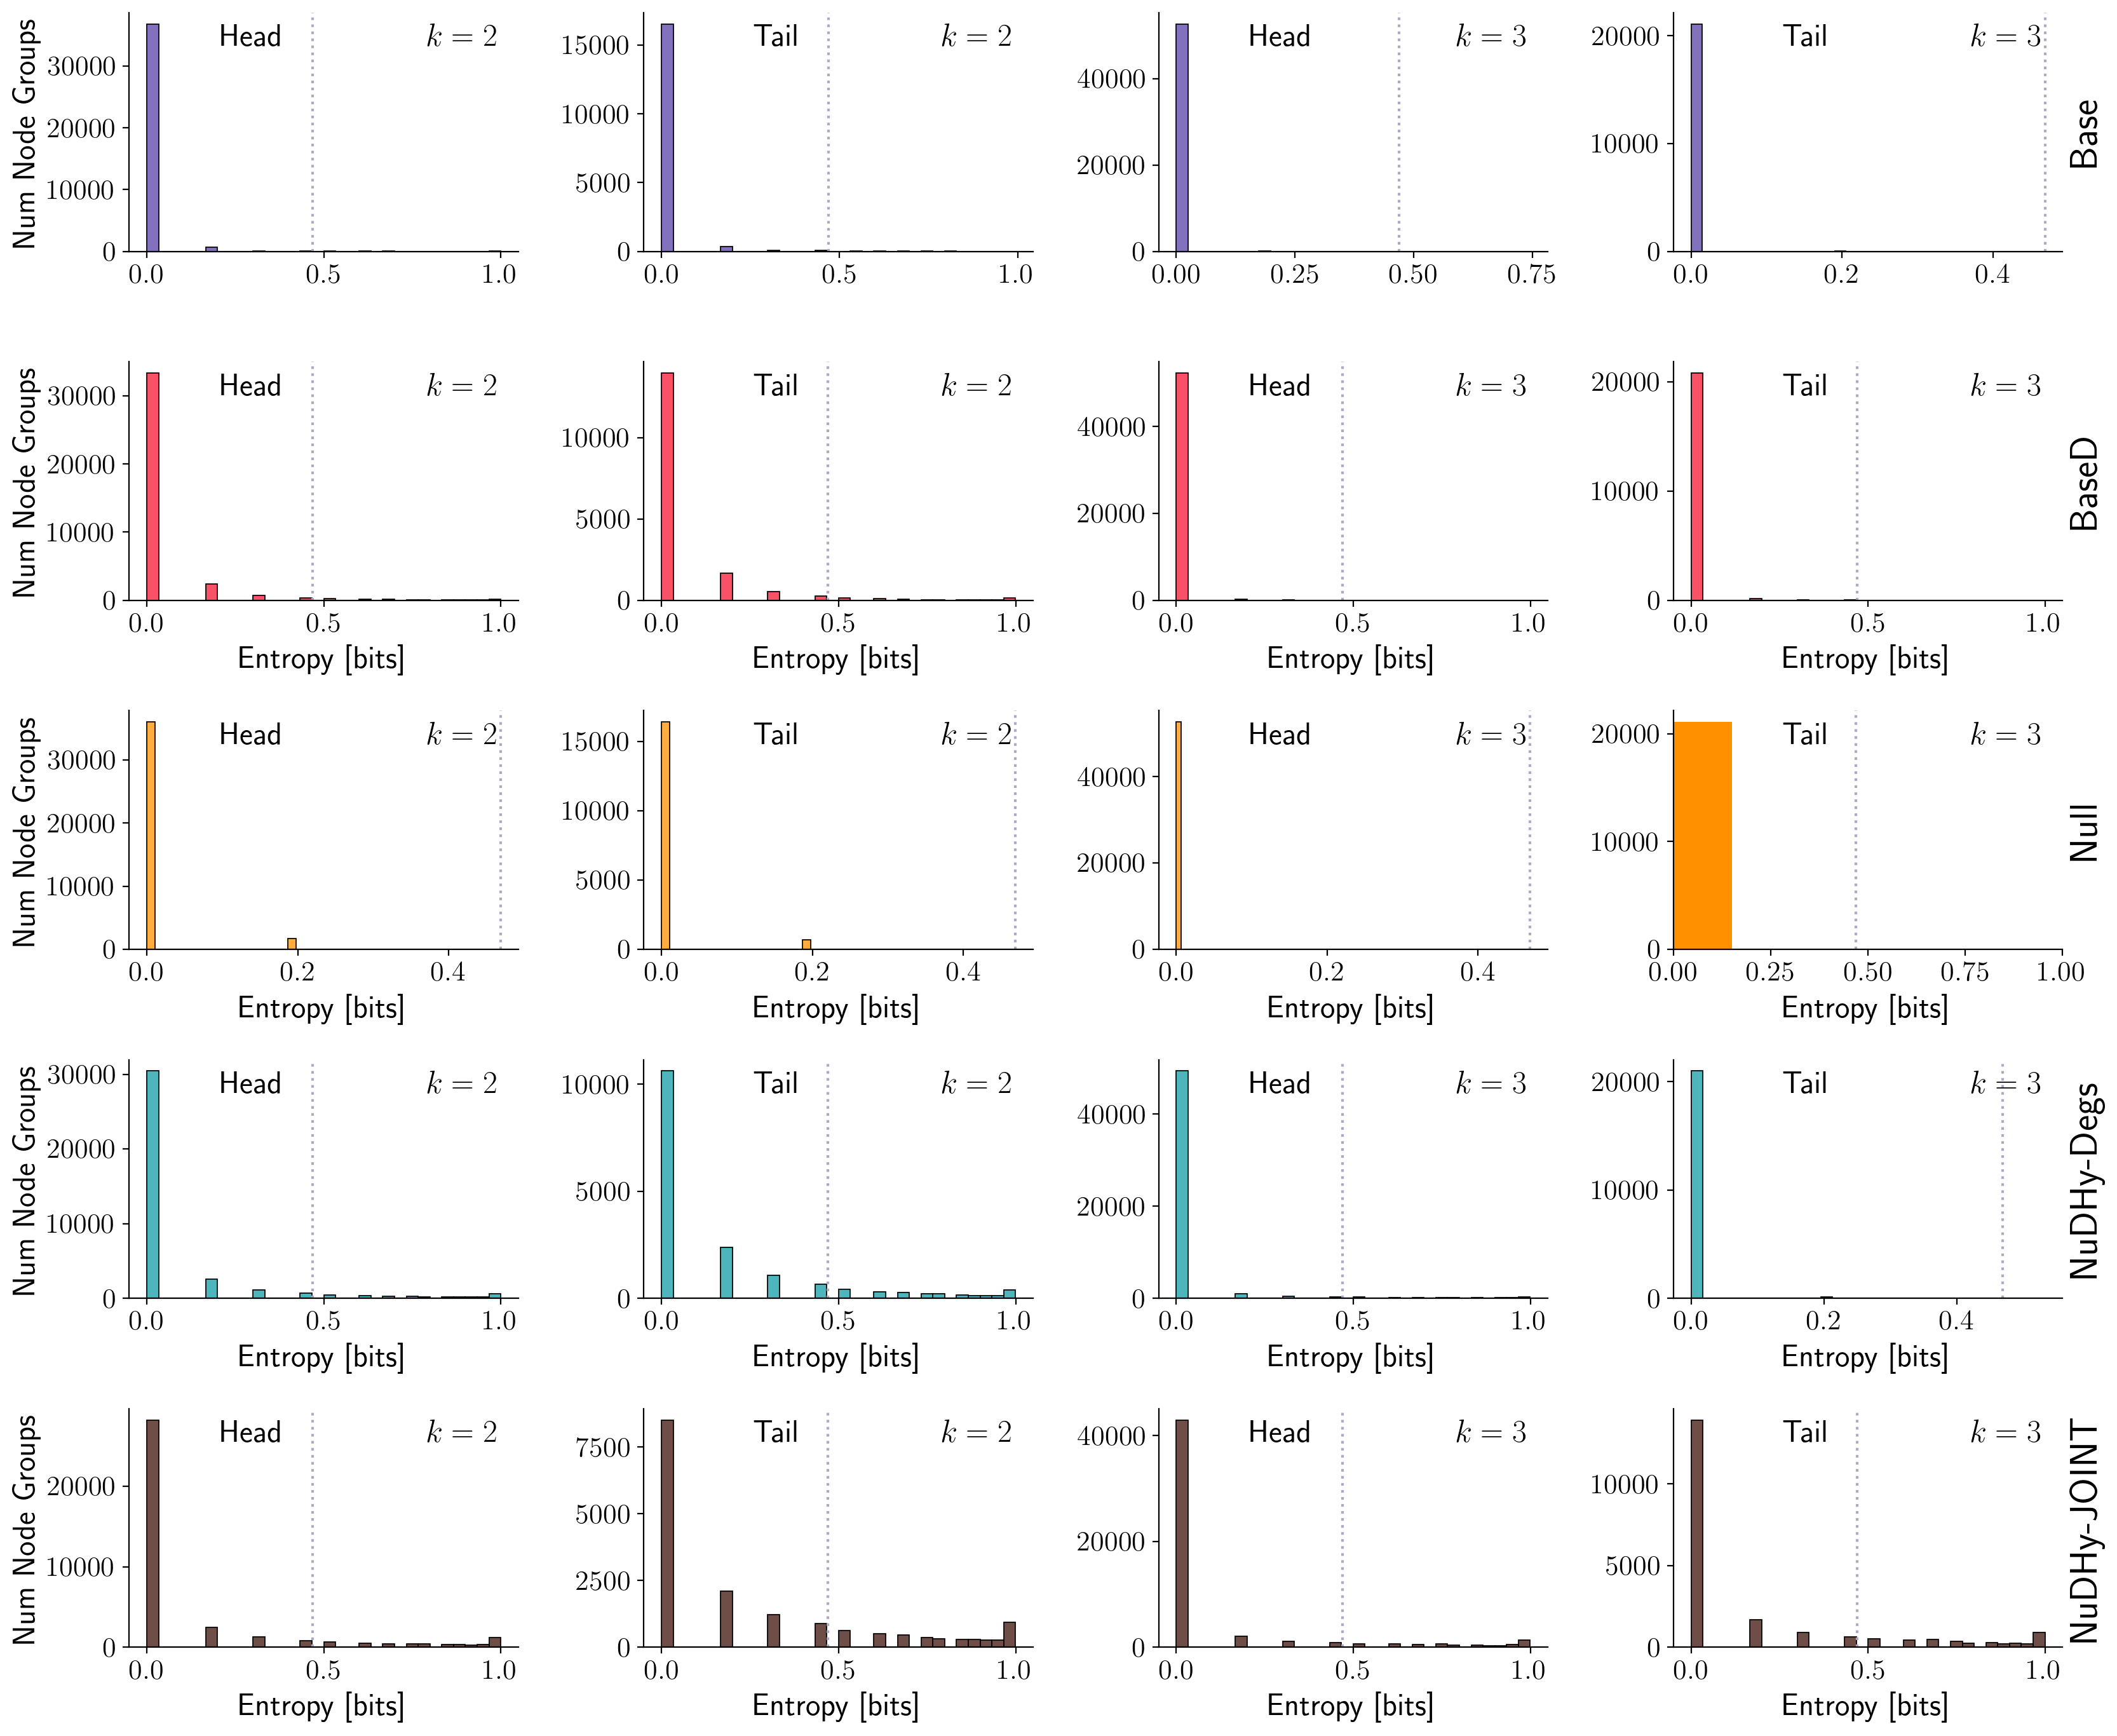

In [107]:
num_sampls = len(h_prob_df['Sampler'].unique())
row_index = 0

fig, ax = plt.subplots(num_sampls, 4, figsize=(17,2*num_sampls+num_sampls-1))

for idx, sampler in enumerate(samplers_ord):
    
    datas = h_prob_df[(h_prob_df['Sampler']==sampler)]
    if datas.empty:
        continue

    for idx2, s in enumerate([2, 3]):

        r = row_index
        c = idx2 * 2

        # HEAD
        data = datas[datas['Size']==s]
        ps_h = data['Probability'].values
        ep_h = get_entropy_bits(ps_h)
        ent_h = 0
        if sum(ep_h) > 0:
            ent_h = round(entropy(ps_h), 3)
            sns.histplot(ep_h, color=colors[idx], ax=ax[r][c], bins=30)
        else:
            ax[r][c].bar([0], [len(ep_h)], width=0.3, color=colors[idx])
            ax[r][c].set_xlim(0, 1)
        if r > 0:
            ax[r][c].set_xlabel('Entropy [bits]', fontsize=18)
        if c == 0:
            ax[r][c].set_ylabel('Num Node Groups', fontsize=18)
        else:
            ax[r][c].set_ylabel('')
        ax[r][c].axvline(ss, color=colors[-1], linestyle='dotted')
        ax[r][c].text(.4, .95, 'Head', fontsize=18,
                      ha='right', va='top', transform=ax[r][c].transAxes)
        ax[r][c].text(.95, .95, r'$k={}$'.format(s), fontsize=18,
                      ha='right', va='top', transform=ax[r][c].transAxes)
#         ax[r][c].text(.95, .95, f'{ent_h}', fontsize=18,
#                       ha='right', va='top', transform=ax[r][c].transAxes, color='#6C0E23')
        # TAIL
        data = t_prob_df[(t_prob_df['Sampler']==sampler) & 
                         (t_prob_df['Size']==s)]
        ps_t = data['Probability'].values
        ep_t = get_entropy_bits(ps_t)
        ent_t = 0
        if sum(ep_t) > 0:
            ent_t = round(entropy(ps_t), 3)
            sns.histplot(ep_t, color=colors[idx], ax=ax[r][c+1], bins=30)
        else:
            ax[r][c+1].bar([0], [len(ep_t)], width=0.3, color=colors[idx])
            ax[r][c+1].set_xlim(0, 1)
        if r > 0:
            ax[r][c+1].set_xlabel('Entropy [bits]', fontsize=18)
        ax[r][c+1].set_ylabel('')
        ax[r][c+1].axvline(ss, color=colors[-1], linestyle='dotted')
        ax[r][c+1].text(.4, .95, 'Tail', fontsize=18, 
                      ha='right', va='top', transform=ax[r][c+1].transAxes)
        ax[r][c+1].text(.95, .95, r'$k={}$'.format(s), fontsize=18,
                      ha='right', va='top', transform=ax[r][c+1].transAxes)
#         ax[r][c+1].text(.95, .95, f'{ent_t}', fontsize=18, 
#                       ha='right', va='top', transform=ax[r][c+1].transAxes, color='#6C0E23')
        if c == 2:
            ax[r][c+1].text(1.02, 0.5, sampler_names.get(sampler, sampler), transform=ax[r][c+1].transAxes, 
                            fontsize=22, rotation=90, va='center')
        
    row_index += 1

plt.tight_layout()
plt.savefig(f'{root}_entropy.pdf', bbox_inches='tight')
plt.show()

### Tail Probabilities

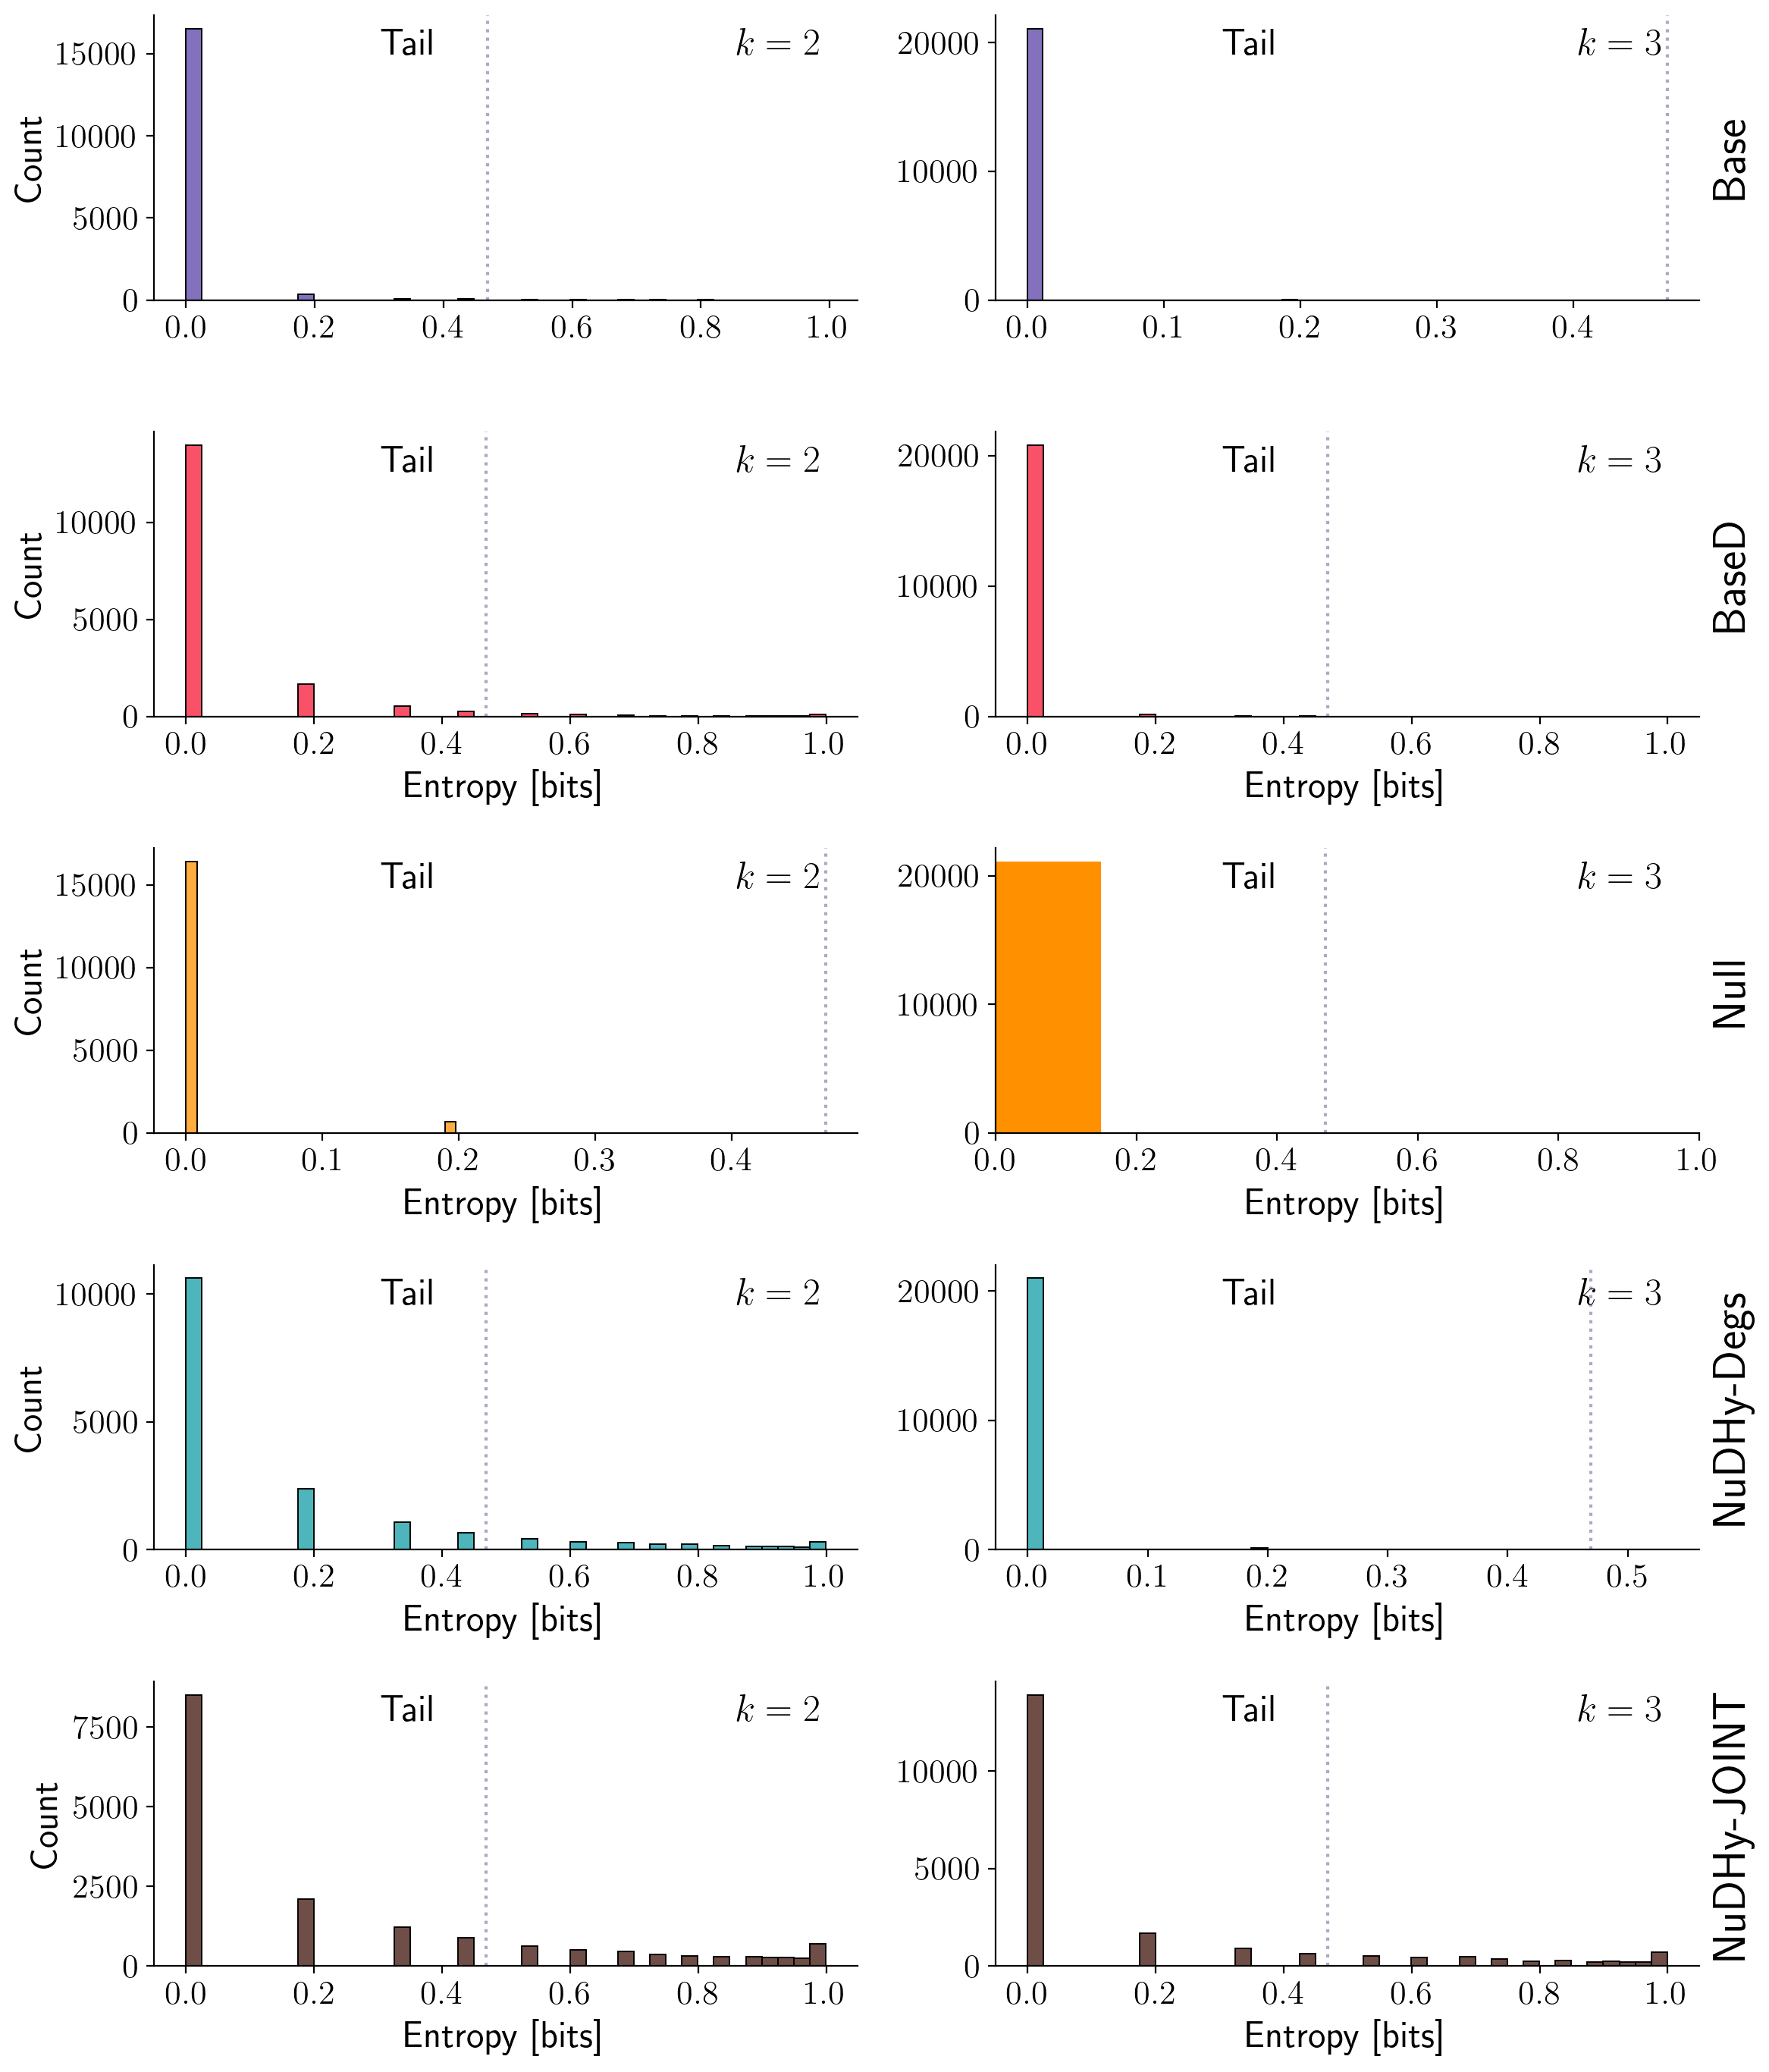

In [108]:
num_sampls = len(t_prob_df['Sampler'].unique())
row_index = 0

fig, ax = plt.subplots(num_sampls, 2, figsize=(12,2*num_sampls+num_sampls-1))

for idx, sampler in enumerate(samplers_ord):
    
    datas = t_prob_df[(t_prob_df['Sampler']==sampler)]
    if datas.empty:
        continue

    for idx2, s in enumerate([2, 3]):

        r = row_index
        c = idx2

        # TAIL
        data = datas[datas['Size']==s]
        ps_t = data['Probability'].values
        ep_t = get_entropy_bits(ps_t)
        ent_t = 0
        if sum(ep_t) > 0:
            ent_t = round(entropy(ps_t), 3)
            sns.histplot(ep_t, color=colors[idx], ax=ax[r][c], bins=40)
        else:
            ax[r][c].bar([0], [len(ep_t)], width=0.3, color=colors[idx])
            ax[r][c].set_xlim(0, 1)
        if r > 0:
            ax[r][c].set_xlabel('Entropy [bits]', fontsize=18)
        if c > 0:
            ax[r][c].set_ylabel('')
        ax[r][c].axvline(ss, color=colors[-1], linestyle='dotted')
        ax[r][c].text(.4, .95, 'Tail', fontsize=18, 
                      ha='right', va='top', transform=ax[r][c].transAxes)
        ax[r][c].text(.95, .95, r'$k={}$'.format(s), fontsize=18,
                      ha='right', va='top', transform=ax[r][c].transAxes)
        if c == 1:
            ax[r][c].text(1.02, 0.5, sampler_names.get(sampler, sampler), transform=ax[r][c].transAxes, 
                          fontsize=22, rotation=90, va='center')
        
    row_index += 1

plt.tight_layout()
plt.savefig(f'{root}_entropy.pdf', bbox_inches='tight')
plt.show()

# Multi-order Laplacian

In [109]:
met_path = results_path + 'laplacian/'

In [110]:
root = 'qna_math'

In [111]:
sym = 'False'

Observed Dataset

In [112]:
# 'Order', 'Eig'
lapl_obs = pd.read_csv(f'{met_path}multi_laplacian_{root}__sym_{sym}.tsv', sep='\t')
lapl_obs['Id'] = np.array([(np.arange(eig_num) + 1)] * int(len(lapl_obs) / 6)).flatten()
# 'Sampler', 'Sample Id', 'Order', 'Eig'
lapl = []
for sam in ['NuDHy', 'Base', 'BaseD', 'UnpretentiousNullModel']:
    try:
        tmp = pd.read_csv(f'{met_path}multi_laplacian_{root}__sym_{sym}_{sam}_samples.tsv', sep='\t')
        lapl.append(tmp)
    except:
        continue
lapl = pd.concat(lapl)
lapl['Sampler'] = lapl['Sampler'].apply(lambda x: rename_null_sampler(x))

In [113]:
# COMPUTE METRICS
lines = []
for ss in lapl['Sampler'].unique():
    for ssid in range(33):
        for order in lapl['Order'].unique():
            inp = lapl[(lapl['Sampler']==ss) &
                       (lapl['Sample Id']==ssid) &
                       (lapl['Order']==order)]
            if inp.empty:
                continue
            eigs = np.array(sorted(inp['Eig'].values))
            eigs_obs = np.array(sorted(lapl_obs[lapl_obs['Order']==order]['Eig'].values))
            if len(eigs_obs) == 0 or len(eigs) == 0:
                print(ss, order)
                continue
            sp_dist = normf(eigs_obs - eigs, ord=2) / len(eigs)
            cos = cosine(eigs_obs, eigs)
            pear = pearsonr(eigs_obs, eigs)[0]
            
            lines.append([ss, ssid, order, sp_dist, cos, pear])
metrics = pd.DataFrame(lines, columns=['Sampler', 'Sampler Id',
                                       'Order',
                                       'Spectral Distance',
                                       'Pearson Correlation',
                                       'Cosine Distance'])

In [114]:
num_sampls = len(metrics['Sampler'].unique())
first_col = 0
if 'Base' not in metrics['Sampler'].unique():
    first_col = 1

In [115]:
orders = ['2', '4', '6', 'multi']

## Cosine Distance

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/378853147.py:11: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.boxplot(data=data, x='Order', y='Cosine Distance', hue='Sampler',
/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/378853147.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = ax[r][c].legend().legendHandles
/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/378853147.py:11: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.boxplot(data=data, x='Order', y='Cosine Distance', hue='Sampler',
/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/378853147.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases l

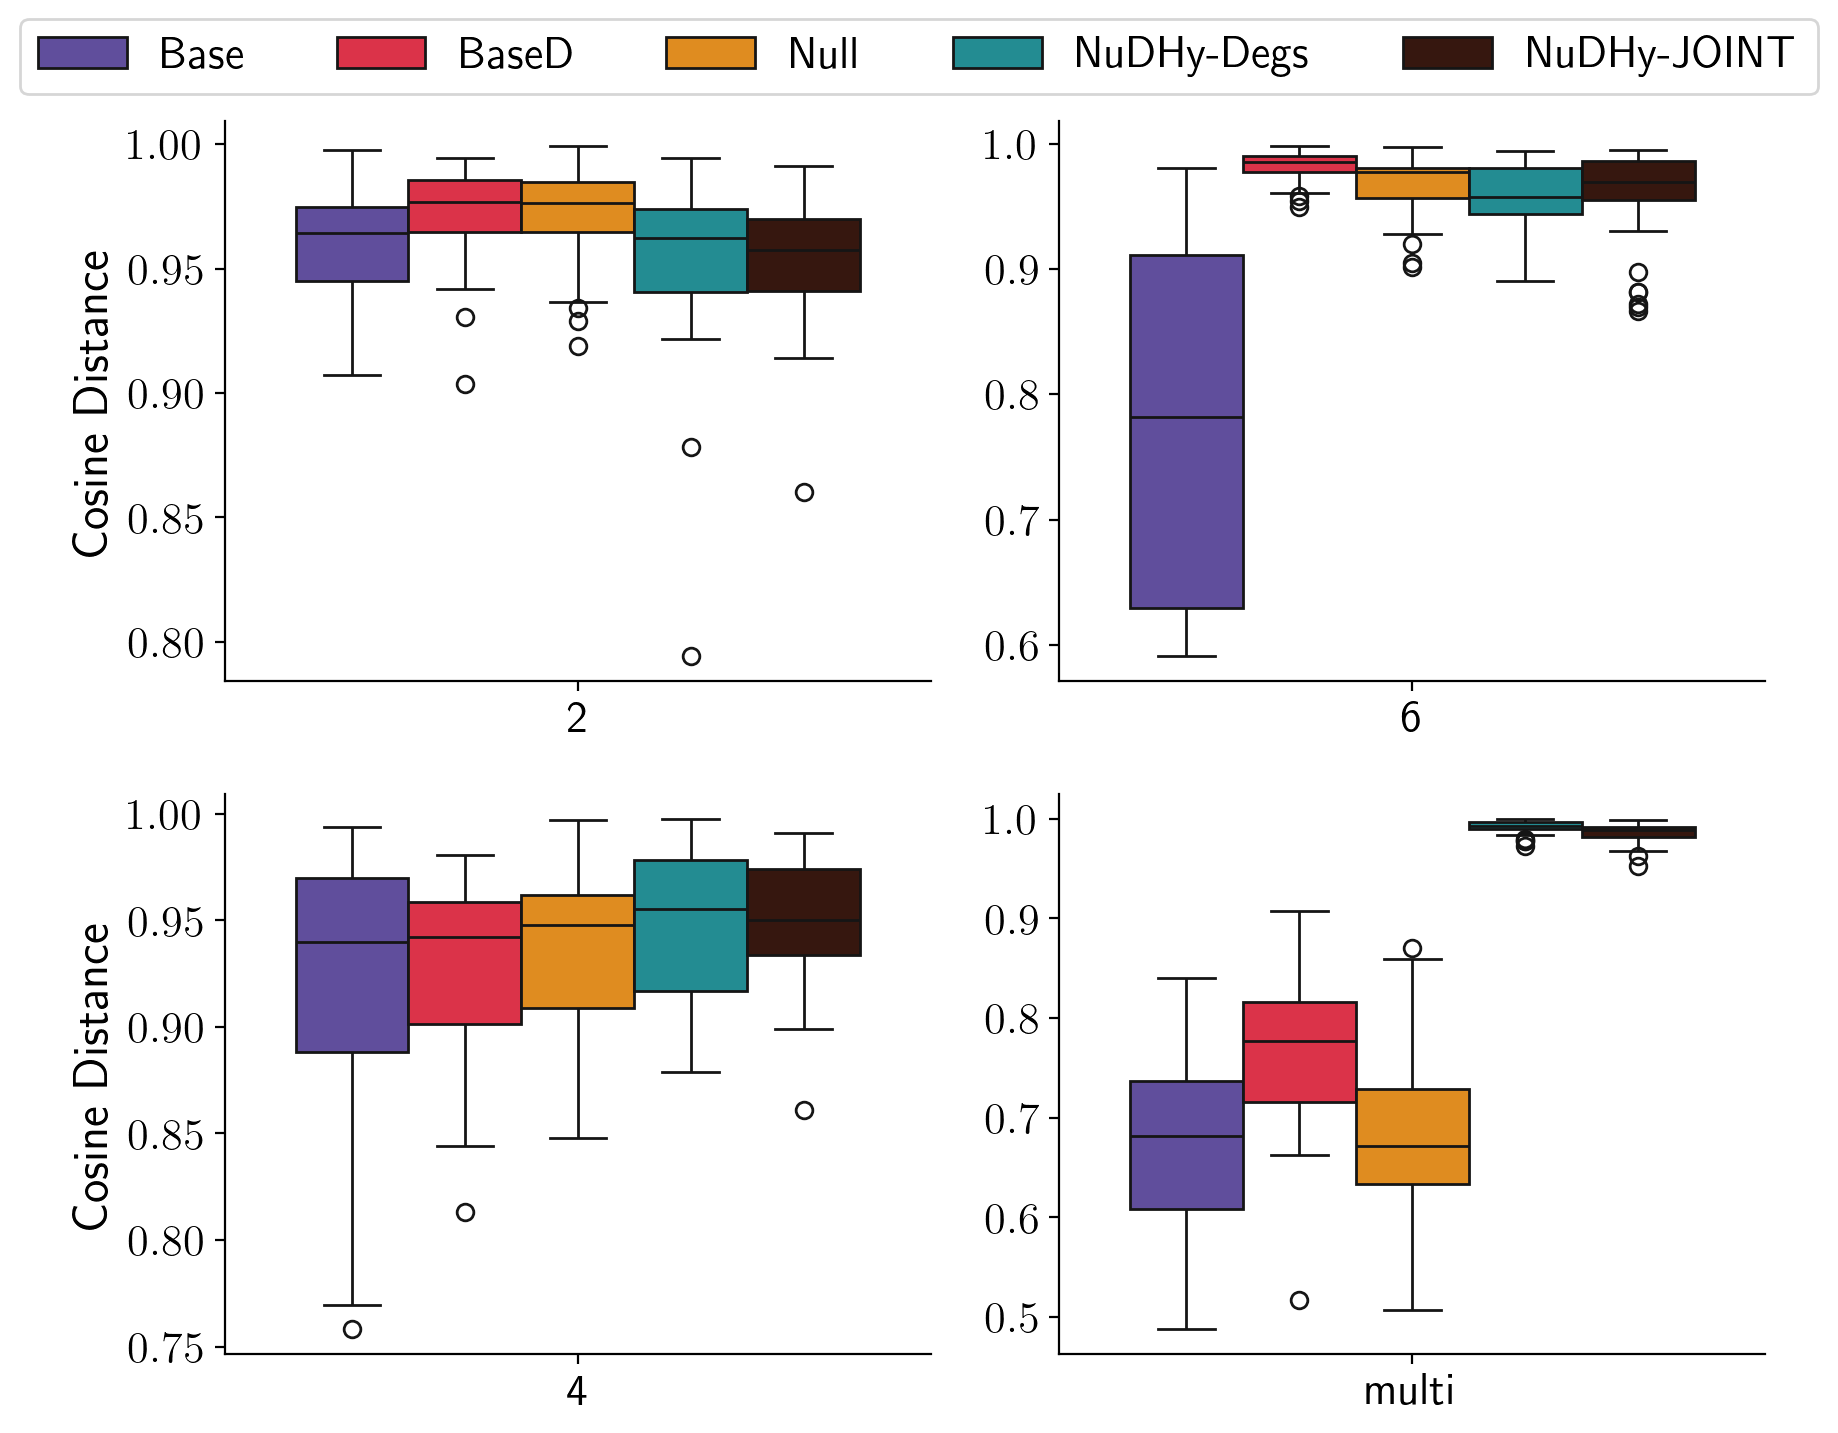

In [116]:
fig, ax = plt.subplots(2, 2, figsize=(9,7))

for idx, order in enumerate(orders):
    
    r = idx % 2 
    c = idx // 2

    data = metrics[metrics['Order']==order]
    data = data[data['Cosine Distance']!='None']
    data = data.astype(dtype={'Cosine Distance': np.float64})
    sns.boxplot(data=data, x='Order', y='Cosine Distance', hue='Sampler',
                hue_order=samplers_ord[first_col:], palette=palette[first_col:], ax=ax[r][c])
    ax[r][c].set_xlabel('')
    if c > 0:
        ax[r][c].set_ylabel('')
    
    handles = ax[r][c].legend().legendHandles
    labels = [sampler_names.get(text.get_text(), text.get_text()) for text in ax[r][c].legend().get_texts()]
    ax[r][c].legend().remove()

fig.legend(handles=handles[:5], labels=labels[:5], fontsize=16, 
           loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5-first_col)

plt.tight_layout()
plt.savefig(f'{root}_cosine_distance.pdf', bbox_inches='tight')
plt.show()

## Pearson Correlation

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/4131908145.py:11: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.boxplot(data=data, x='Order', y='Pearson Correlation', hue_order=samplers_ord[first_col:],
/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/4131908145.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = ax[r][c].legend().legendHandles
/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/4131908145.py:11: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.boxplot(data=data, x='Order', y='Pearson Correlation', hue_order=samplers_ord[first_col:],
/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/4131908145.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in M

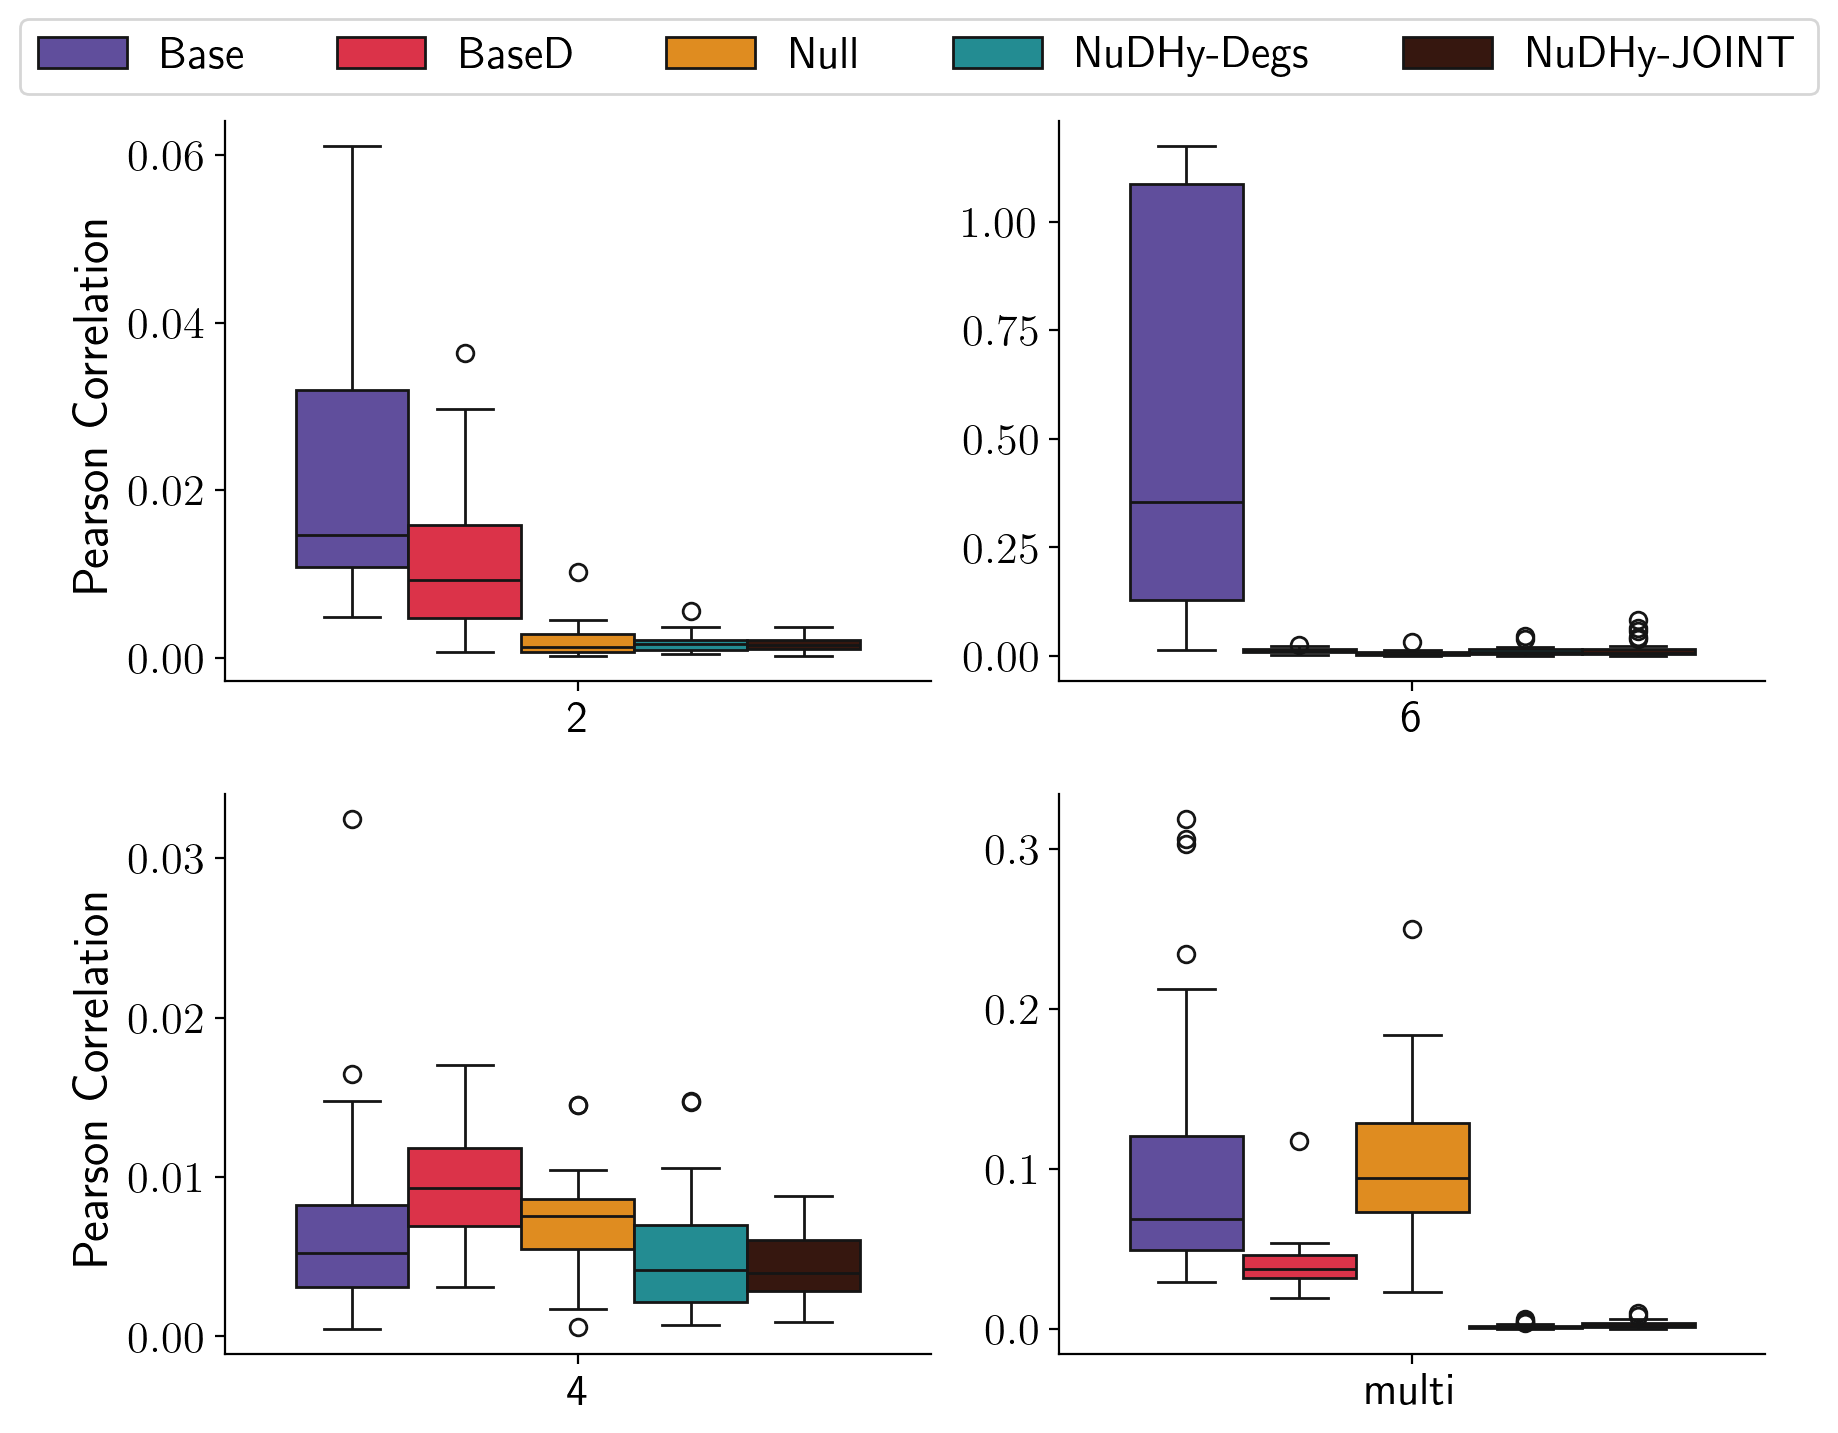

In [117]:
fig, ax = plt.subplots(2, 2, figsize=(9,7))

for idx, order in enumerate(orders):
    
    r = idx % 2 
    c = idx // 2

    data = metrics[metrics['Order']==order]
    data = data[data['Pearson Correlation']!='None']
    data = data.astype(dtype={'Pearson Correlation': np.float64})
    sns.boxplot(data=data, x='Order', y='Pearson Correlation', hue_order=samplers_ord[first_col:],
                hue='Sampler', palette=palette[first_col:], ax=ax[r][c])
    ax[r][c].set_xlabel('')
    if c > 0:
        ax[r][c].set_ylabel('')
    
    handles = ax[r][c].legend().legendHandles
    labels = [sampler_names.get(text.get_text(), text.get_text()) for text in ax[r][c].legend().get_texts()]
    ax[r][c].legend().remove()

# tmp_h = [handles[0], handles[1], handles[3]]
# tmp_l = [labels[0], labels[1], labels[3]]
# fig.legend(handles=tmp_h, labels=tmp_l, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
fig.legend(handles=handles[:5], labels=labels[:5], loc='upper center', 
           fontsize=16, bbox_to_anchor=(0.5, 1.05), ncol=5-first_col)

plt.tight_layout()
plt.savefig(f'{root}_pearson_distance.pdf', bbox_inches='tight')
plt.show()

## Side-by-side distributions

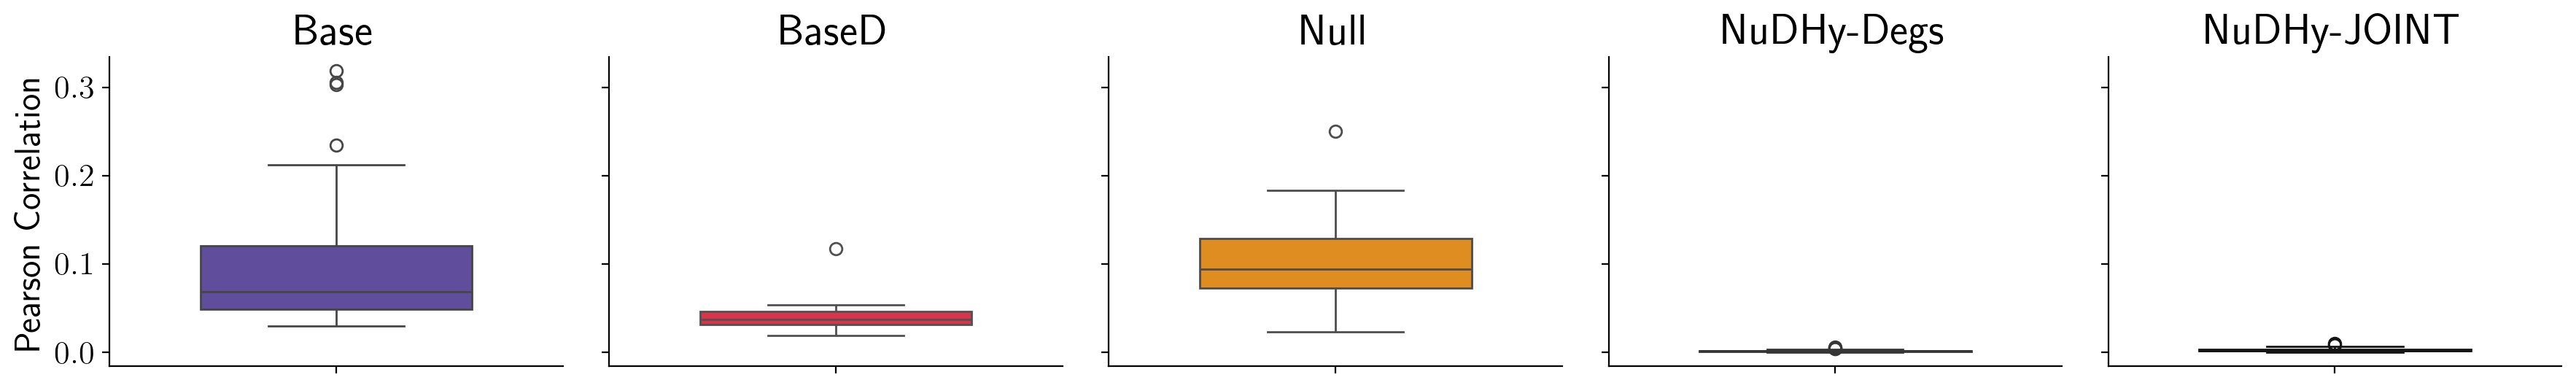

In [118]:
fig, ax = plt.subplots(1, len(samplers_ord), figsize=(18, 3), sharey=True)

data = metrics[metrics['Order']=='multi']
data = data[data['Pearson Correlation']!='None']
data = data.astype(dtype={'Pearson Correlation': np.float64})

for i, s in enumerate(samplers_ord):
    sns.boxplot(data=data[data['Sampler']==s], y='Pearson Correlation', ax=ax[i], 
                color=colors[i], width=.6)
    if i > 0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Pearson Correlation')
    ax[i].set_title(sampler_names.get(s, s))
plt.tight_layout()
plt.savefig(f'{root}_pearson_distrib.pdf', bbox_inches='tight')
plt.show()

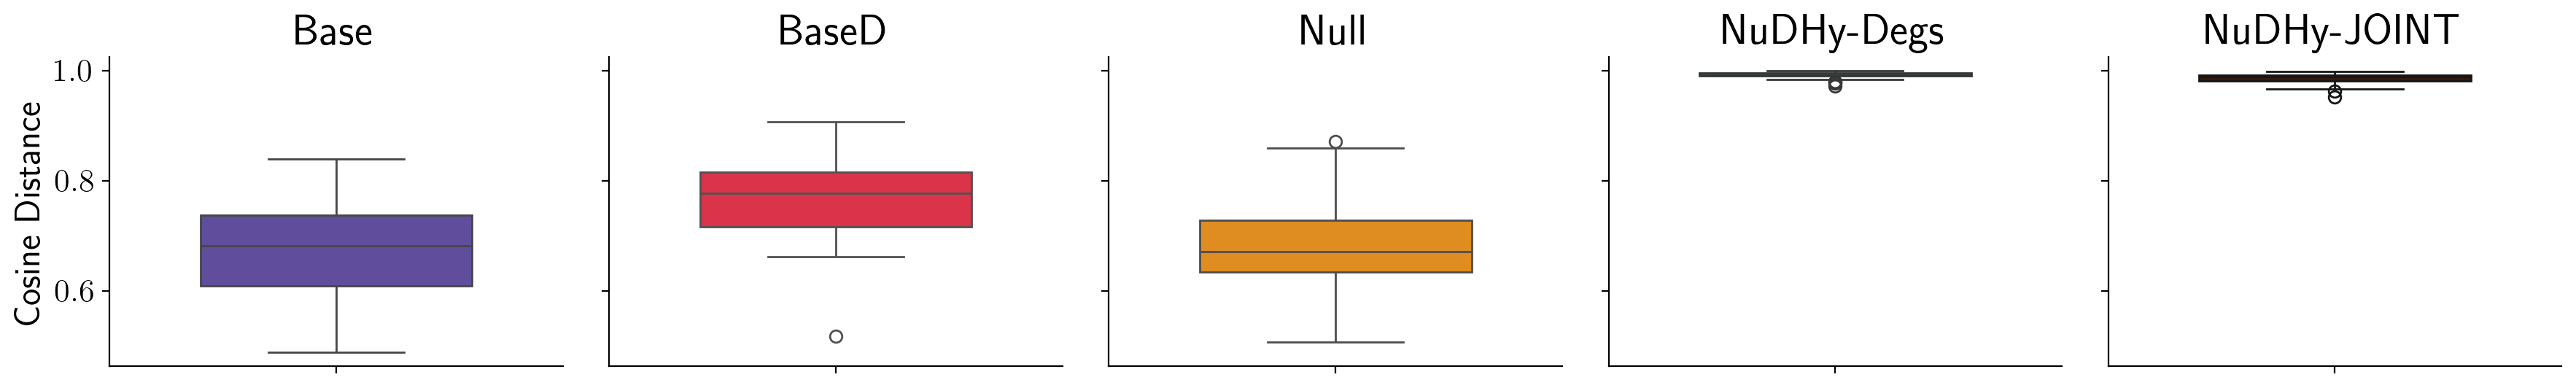

In [119]:
fig, ax = plt.subplots(1, len(samplers_ord), figsize=(18, 3), sharey=True)

data = metrics[metrics['Order']=='multi']
data = data[data['Cosine Distance']!='None']
data = data.astype(dtype={'Cosine Distance': np.float64})

for i, s in enumerate(samplers_ord):
    sns.boxplot(data=data[data['Sampler']==s], y='Cosine Distance', ax=ax[i], 
                color=colors[i], width=.6)
    if i > 0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Cosine Distance')
    ax[i].set_title(sampler_names.get(s, s))
plt.tight_layout()
plt.savefig(f'{root}_cosine_distrib.pdf', bbox_inches='tight')
plt.show()

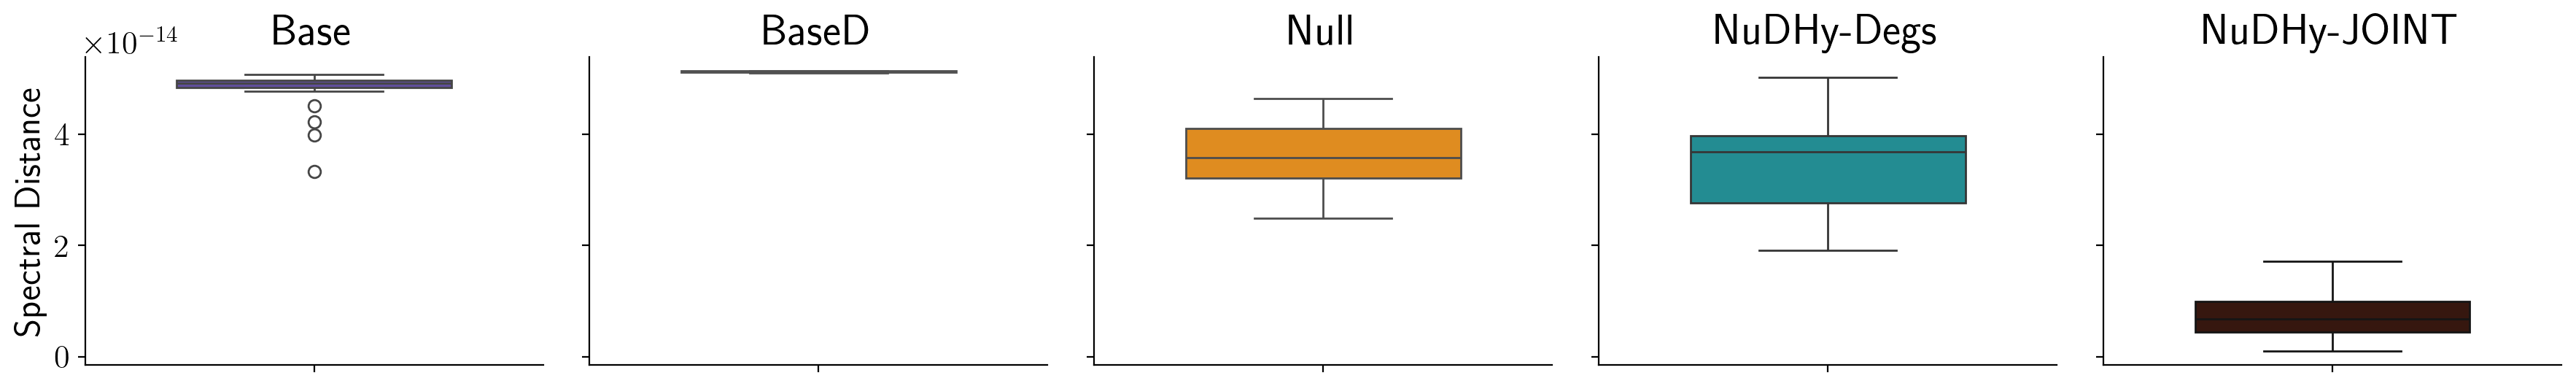

In [120]:
fig, ax = plt.subplots(1, len(samplers_ord), figsize=(18, 3), sharey=True)

data = metrics[metrics['Order']=='multi']
data = data[data['Spectral Distance']!='None']
data = data.astype(dtype={'Spectral Distance': np.float64})

for i, s in enumerate(samplers_ord):
    sns.boxplot(data=data[data['Sampler']==s], y='Spectral Distance', ax=ax[i], 
                color=colors[i], width=.6)
    if i > 0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Spectral Distance')
    ax[i].set_title(sampler_names.get(s, s))
plt.tight_layout()
plt.savefig(f'{root}_spectral_distrib.pdf', bbox_inches='tight')
plt.show()

# Node Centrality

In [121]:
met_path = results_path + 'centrality/'

In [122]:
root = 'enron'

## HITS

In [123]:
def remap_to_hyperedge(x):
    if x == 'None':
        return 'Hyperedge'
    else:
        return x

In [124]:
hits_obs = pd.read_csv(f'{met_path}hits_{root}.tsv', sep='\t') 
hits = pd.read_csv(f'{met_path}hits_{root}_samples.tsv', sep='\t') 
for sam in samplers[:-2]:
    try:
        tmp = pd.read_csv(f'{met_path}hits_{root}_samples_{sam}.tsv', sep='\t')
        tmp['Type'] = tmp['Type'].apply(lambda x: remap_to_hyperedge(x))
        tmp['Sampler'] = rename_null_sampler(sam)
        hits = pd.concat([hits, tmp])
    except:
        continue

In [125]:
hits = hits[(hits['Type']=='Vertex')]
hits['Hub Score'] = hits['Hub Score'].apply(lambda x: round(x, 6))
hits['Authority Score'] = hits['Authority Score'].apply(lambda x: round(x, 6))
hits_obs = hits_obs[hits_obs['Type']=='Vertex']
hits_obs['Hub Score'] = hits_obs['Hub Score'].apply(lambda x: round(x, 6))
hits_obs['Authority Score'] = hits_obs['Authority Score'].apply(lambda x: round(x, 6))

In [126]:
first_col = 0
if 'Base' not in hits['Sampler'].unique():
    first_col = 1

### Score Distributions

### Comparison Rankings

In [127]:
rows = []
for score in ['Hub Score', 'Authority Score']:
    for sampler in hits['Sampler'].unique():
        for sample in hits['Sample Id'].unique():
            data = hits[(hits['Sampler']==sampler) &
                        (hits['Sample Id']==sample) &
                        (hits['Type']=='Vertex')]
            if data.empty: continue
            ts_pr = data.sort_values(by=score, ascending=False).copy()
            ts_pr['Rank'] = np.arange(len(ts_pr)) + 1
            s_rank = ts_pr.sort_values(by='Node Id')['Rank'].values

            d_pr = hits_obs[hits_obs['Type']=='Vertex'].sort_values(by=score, ascending=False).copy()
            d_pr['Rank'] = np.arange(len(d_pr)) + 1
            data_rank = d_pr.sort_values(by='Node Id')['Rank'].values

            pear = pearsonr(data_rank, s_rank)[0]
            kt = kendalltau(data_rank, s_rank)[0]

            true_scores = hits_obs[hits_obs['Type']=='Vertex'].sort_values(by='Node Id')[score].values
            true_s = np.array([true_scores])
            pred_scores = data.sort_values(by=['Node Id'])[score].values
            pred_s = np.array([pred_scores])
            nDCG = ndcg_score(true_s, pred_s, ignore_ties=True)

            rows.append([sampler, sample, score, pear, kt, nDCG])

In [128]:
rank_comparison = pd.DataFrame(rows, columns=['Sampler', 'Sample', 'Score', 'Pearson', 'Kendall-Tau', 'nDCG'])
rank_comparison.groupby(by=['Sampler', 'Score']).agg(['mean', 'std'])

Sample             Pearson           Kendall-Tau  \
                          mean       std      mean       std        mean   
Sampler Score                                                              
Base    Authority Score   16.0  9.669540  0.065981  0.007353    0.046892   
        Hub Score         16.0  9.669540  1.000000  0.000000    1.000000   
BaseD   Authority Score   16.0  9.669540  0.169048  0.005354    0.111628   
        Hub Score         16.0  9.669540  1.000000  0.000000    1.000000   
NuDHy_A Authority Score   16.5  9.958246  0.516989  0.004727    0.364339   
        Hub Score         16.5  9.958246  1.000000  0.000000    1.000000   
NuDHy_C Authority Score   16.0  9.669540  0.525647  0.010258    0.374971   
        Hub Score         16.0  9.669540  1.000000  0.000000    1.000000   
Null    Authority Score   16.0  9.669540  0.000391  0.003648    0.000262   
        Hub Score         16.0  9.669540  1.000000  0.000000    1.000000   

                                       nDCG            
                              std      mean       std  
Sampler Score                                          
Base    Authority Score  0.007117  0.287224  0.015228  
        Hub Score        0.000000  0.000000  0.000000  
BaseD   Authority Score  0.003839  0.397386  0.012457  
        Hub Score        0.000000  0.000000  0.000000  
NuDHy_A Authority Score  0.004644  0.797788  0.001075  
        Hub Score        0.000000  0.000000  0.000000  
NuDHy_C Authority Score  0.010354  0.981799  0.000454  
        Hub Score        0.000000  0.000000  0.000000  
Null    Authority Score  0.002433  0.263112  0.003825  
        Hub Score        0.000000  0.000000  0.000000

## PageRank

We assume that a vertex in the head can reach each other vertex in the tail.

In [129]:
pr_obs = pd.read_csv(f'{met_path}pagerank_{root}.tsv', sep='\t') 
pr = pd.read_csv(f'{met_path}pagerank_{root}_samples.tsv', sep='\t')
for sam in samplers[:-2]:
    try:
        tmp = pd.read_csv(f'{met_path}pagerank_{root}_samples_{sam}.tsv', sep='\t')
        tmp['Sampler'] = tmp['Sampler'].apply(lambda x: rename_null_sampler(x))
        pr = pd.concat([pr, tmp])
    except:
        continue

### Score Distributions

In [130]:
order = [dataset_names[root]]
order.extend([x for x in samplers_ord if x in pr['Sampler'].unique()])

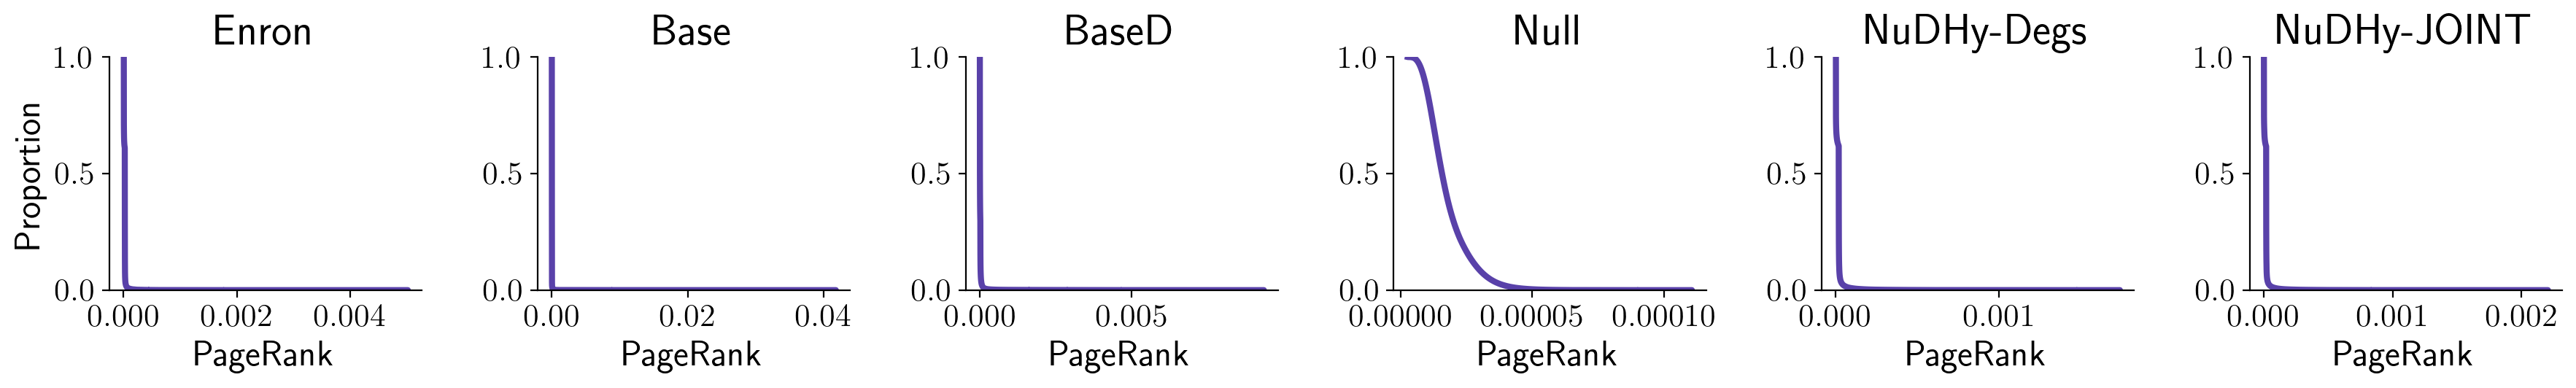

In [131]:
fig, ax = plt.subplots(1, len(order), figsize=(18, 3))

data = pr_obs.copy()
data['Sampler'] = dataset_names[root]
data = pd.concat([pr[['Node Id', 'Sampler', 'PageRank']], data])

for i, s in enumerate(order):
#     sns.boxplot(data=data[data['Sampler']==s], y='PageRank', ax=ax[i], 
#                 color=colors[0], width=.6)
    sns.ecdfplot(data=data[data['Sampler']==s], x='PageRank', ax=ax[i], 
                color=colors[0], complementary=True, linewidth=3)
    if i > 0:
        ax[i].set_ylabel('')

    ax[i].set_title(sampler_names.get(s, s))
plt.tight_layout()
plt.savefig(f'{root}_pagerank_distrib.pdf', bbox_inches='tight')
plt.show()

### Comparison Rankings

In [132]:
rows = []
for sampler in pr['Sampler'].unique():
    for sample in pr['Sample Id'].unique():
        
        data = pr[(pr['Sampler']==sampler) &
                   (pr['Sample Id']==sample)]
        if data.empty: continue
        ts_pr = data.sort_values(by='PageRank', ascending=False).copy()
        ts_pr['Rank'] = np.arange(len(ts_pr)) + 1
        s_rank = ts_pr.sort_values(by='Node Id')['Rank'].values

        d_pr = pr_obs.sort_values(by='PageRank', ascending=False).copy()
        d_pr['Rank'] = np.arange(len(d_pr)) + 1
        data_rank = d_pr.sort_values(by='Node Id')['Rank'].values 

        pear = pearsonr(data_rank, s_rank)[0]
        kt = kendalltau(data_rank, s_rank)[0]

        pred_scores = data.sort_values(by=['Node Id'])['PageRank'].values
        pred_s = np.array([pred_scores])
        true_scores = pr_obs.sort_values(by='Node Id')['PageRank'].values
        true_s = np.array([true_scores])
        nDCG = ndcg_score(true_s, pred_s, ignore_ties=True)

        rows.append([sampler, sample, pear, kt, nDCG])

In [133]:
pr_rank_comparison = pd.DataFrame(rows, columns=['Sampler', 'Sample', 'Pearson', 'Kendall-Tau', 'nDCG'])

In [134]:
pr_rank_comparison.groupby(by=['Sampler']).agg(['mean', 'std'])

Sample             Pearson           Kendall-Tau                nDCG  \
          mean       std      mean       std        mean       std      mean   
Sampler                                                                        
Base      16.0  9.669540  0.009615  0.004832    0.006399  0.003232  0.792187   
BaseD     16.0  9.669540  0.064726  0.003530    0.043645  0.002366  0.820127   
NuDHy_A   16.5  9.958246  0.827940  0.001626    0.653295  0.004948  0.933586   
NuDHy_C   16.0  9.669540  0.828586  0.001696    0.653411  0.005301  0.979252   
Null      16.0  9.669540 -0.000119  0.005218   -0.000079  0.003480  0.778997   

                   
              std  
Sampler            
Base     0.002490  
BaseD    0.001895  
NuDHy_A  0.001956  
NuDHy_C  0.000729  
Null     0.000794

## Output Table

In [135]:
rank_comparison.groupby(by=['Sampler', 'Score']).agg({'nDCG':['mean', 'std']}).apply(lambda x: round(x, 3)).T

Sampler              Base                     BaseD                   NuDHy_A  \
Score     Authority Score Hub Score Authority Score Hub Score Authority Score   
nDCG mean           0.287       0.0           0.397       0.0           0.798   
     std            0.015       0.0           0.012       0.0           0.001   

Sampler                     NuDHy_C                      Null            
Score     Hub Score Authority Score Hub Score Authority Score Hub Score  
nDCG mean       0.0           0.982       0.0           0.263       0.0  
     std        0.0           0.000       0.0           0.004       0.0

In [136]:
pr_rank_comparison.groupby(by=['Sampler']).agg({'nDCG':['mean', 'std']}).apply(lambda x: round(x, 3)).T

Sampler     Base  BaseD  NuDHy_A  NuDHy_C   Null
nDCG mean  0.792  0.820    0.934    0.979  0.779
     std   0.002  0.002    0.002    0.001  0.001

# Econometric Indices

In [137]:
met_path = results_path + 'eco/'
year = '2019'
side = 'head'
root = f'hs{year}_thresh'
dname = dataset_names[root]
side_labels = {
    'head': 'Export',
    'tail': 'Import'
}

Node Labels

In [138]:
c_index = pd.read_csv(data_path + f'hs{year}_country_ids.tsv', header=None, sep='\t')
c_index.set_index(1, inplace=True)
c_index.columns = ['Country']
vmap = pd.read_csv(met_path + f'vmap_hs{year}_thresh.tsv', header=None, sep='\t')
vmap.set_index(1, inplace=True)
vmap.columns = ['VID']

## Data

Genepy

In [139]:
genepy_obs = pd.read_csv(f'{met_path}genepy_{root}_{side}.tsv', sep='\t', header=None)
genepy_obs.columns = ['VID', 'Genepy']

In [140]:
genepy_obs['Country'] = genepy_obs['VID'].apply(lambda x: c_index.loc[vmap.loc[x, 'VID'], 'Country'])

In [141]:
genepy = pd.DataFrame()
for sam in ['Base', 'BaseD']:
    tmp = pd.read_csv(f'{met_path}genepy_{root}_samples_{sam}_{side}.tsv', sep='\t', header=None)
    if genepy.empty:
        genepy = tmp
    else:
        genepy = pd.concat([genepy, tmp])
genepy.columns = ['VID', 'Genepy', 'Sampler', 'Seed']

for sam in ['_UnpretentiousNullModel', '']:
    tmp = pd.read_csv(f'{met_path}genepy_{root}_samples{sam}_{side}.tsv', sep='\t', header=None)
    tmp.columns = ['VID', 'Genepy', 'Sampler', 'Seed']
    genepy = pd.concat([genepy, tmp])

In [142]:
genepy['Sampler'] = genepy['Sampler'].apply(lambda x: rename_null_sampler(x))
genepy['Country'] = genepy['VID'].apply(lambda x: c_index.loc[vmap.loc[x, 'VID'], 'Country'])

ECI

In [143]:
eci_obs = pd.read_csv(f'{met_path}eci_{root}_{side}.tsv', sep='\t', header=None)
eci_obs.columns = ['VID', 'ECI']

In [144]:
eci_obs['Country'] = eci_obs['VID'].apply(lambda x: c_index.loc[vmap.loc[x, 'VID'], 'Country'])

In [145]:
eci = pd.read_csv(f'{met_path}eci_{root}_samples_{side}.tsv', sep='\t', header=None)
for sam in ['Base', 'BaseD', 'UnpretentiousNullModel']:
    tmp = pd.read_csv(f'{met_path}eci_{root}_samples_{sam}_{side}.tsv', sep='\t', header=None)
    eci = pd.concat([eci, tmp])
eci.columns = ['VID', 'ECI', 'Sampler', 'Seed']

In [146]:
eci['Sampler'] = eci['Sampler'].apply(lambda x: rename_null_sampler(x))
eci['Country'] = eci['VID'].apply(lambda x: c_index.loc[vmap.loc[x, 'VID'], 'Country'])

Fitness

In [147]:
fit_obs = pd.read_csv(f'{met_path}fitness_{root}_{side}.tsv', sep='\t', header=None)
fit_obs.columns = ['VID', 'Fitness']
fit_obs['Country'] = fit_obs['VID'].apply(lambda x: c_index.loc[vmap.loc[x, 'VID'], 'Country'])

In [148]:
fit = pd.DataFrame()
for sam in ['NuDHy', 'Base', 'BaseD', 'UnpretentiousNullModel']:
    tmp = pd.read_csv(f'{met_path}fitness_{root}_samples_{sam}_{side}.tsv', sep='\t', header=None)
    tmp.columns = ['VID', 'Fitness', 'Sampler', 'Seed']
    if fit.empty:
        fit = tmp
    else:
        fit = pd.concat([fit, tmp])
fit['Country'] = fit['VID'].apply(lambda x: c_index.loc[vmap.loc[x, 'VID'], 'Country'])

## Score Distributions

In [149]:
top_n = 50

### GENEPY

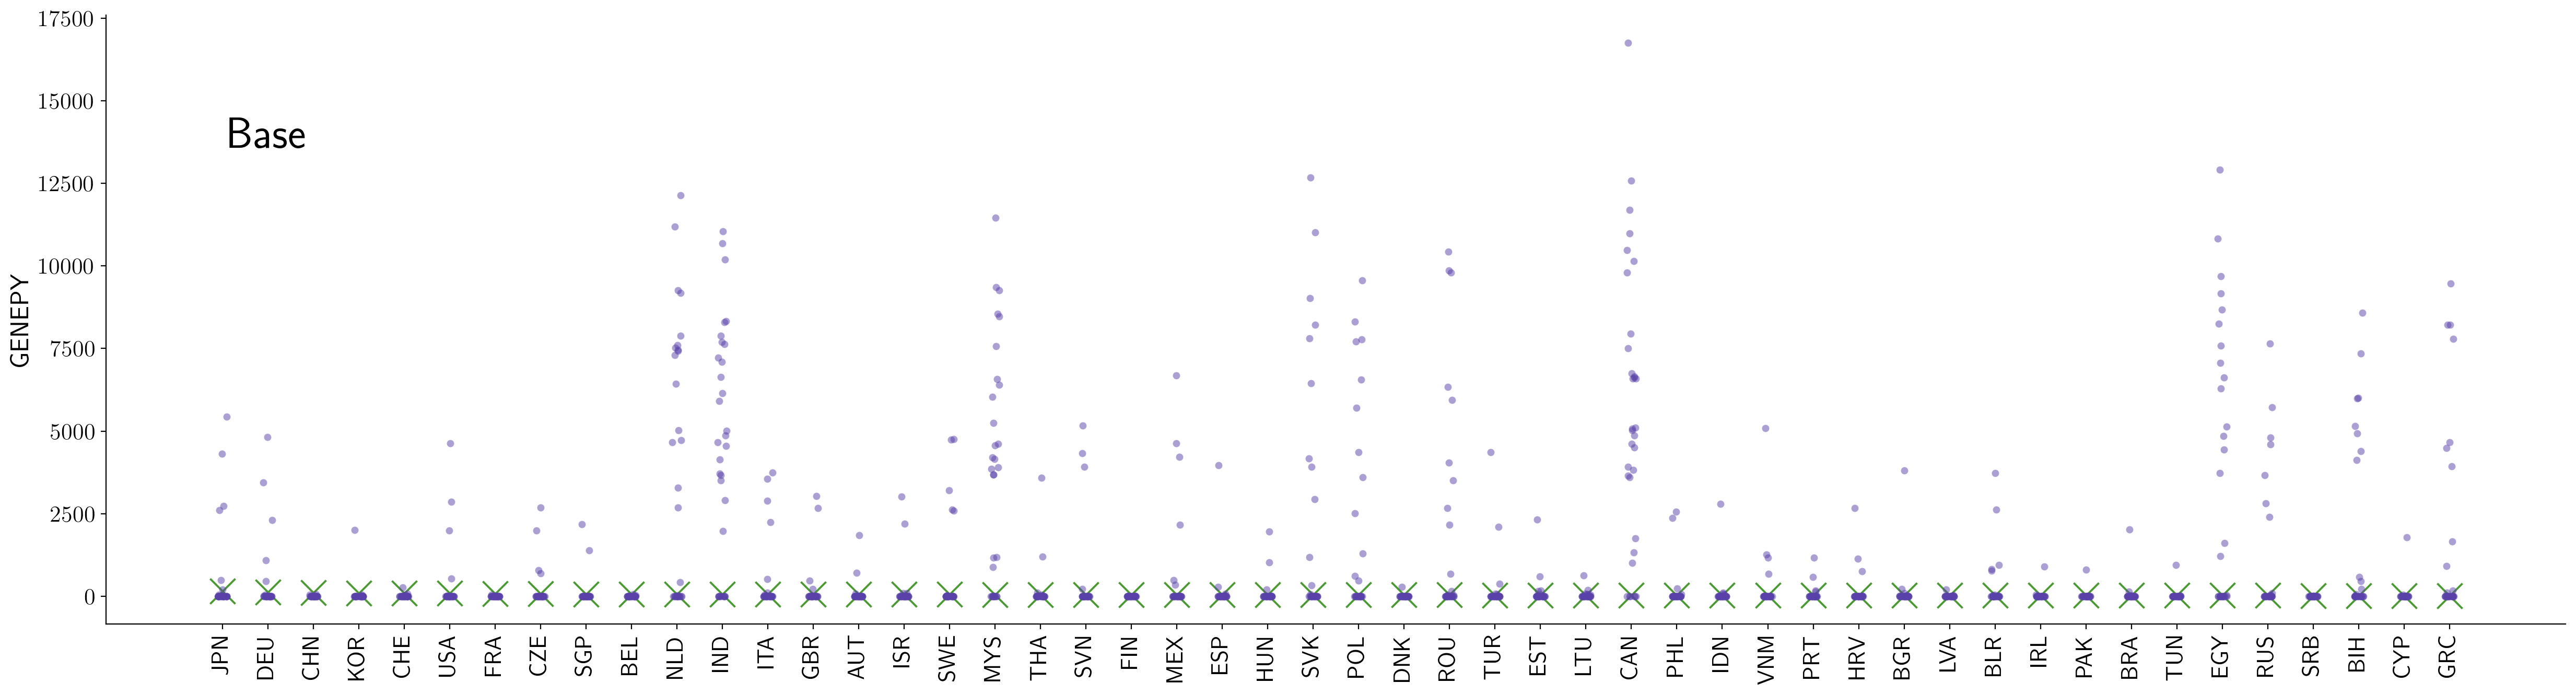

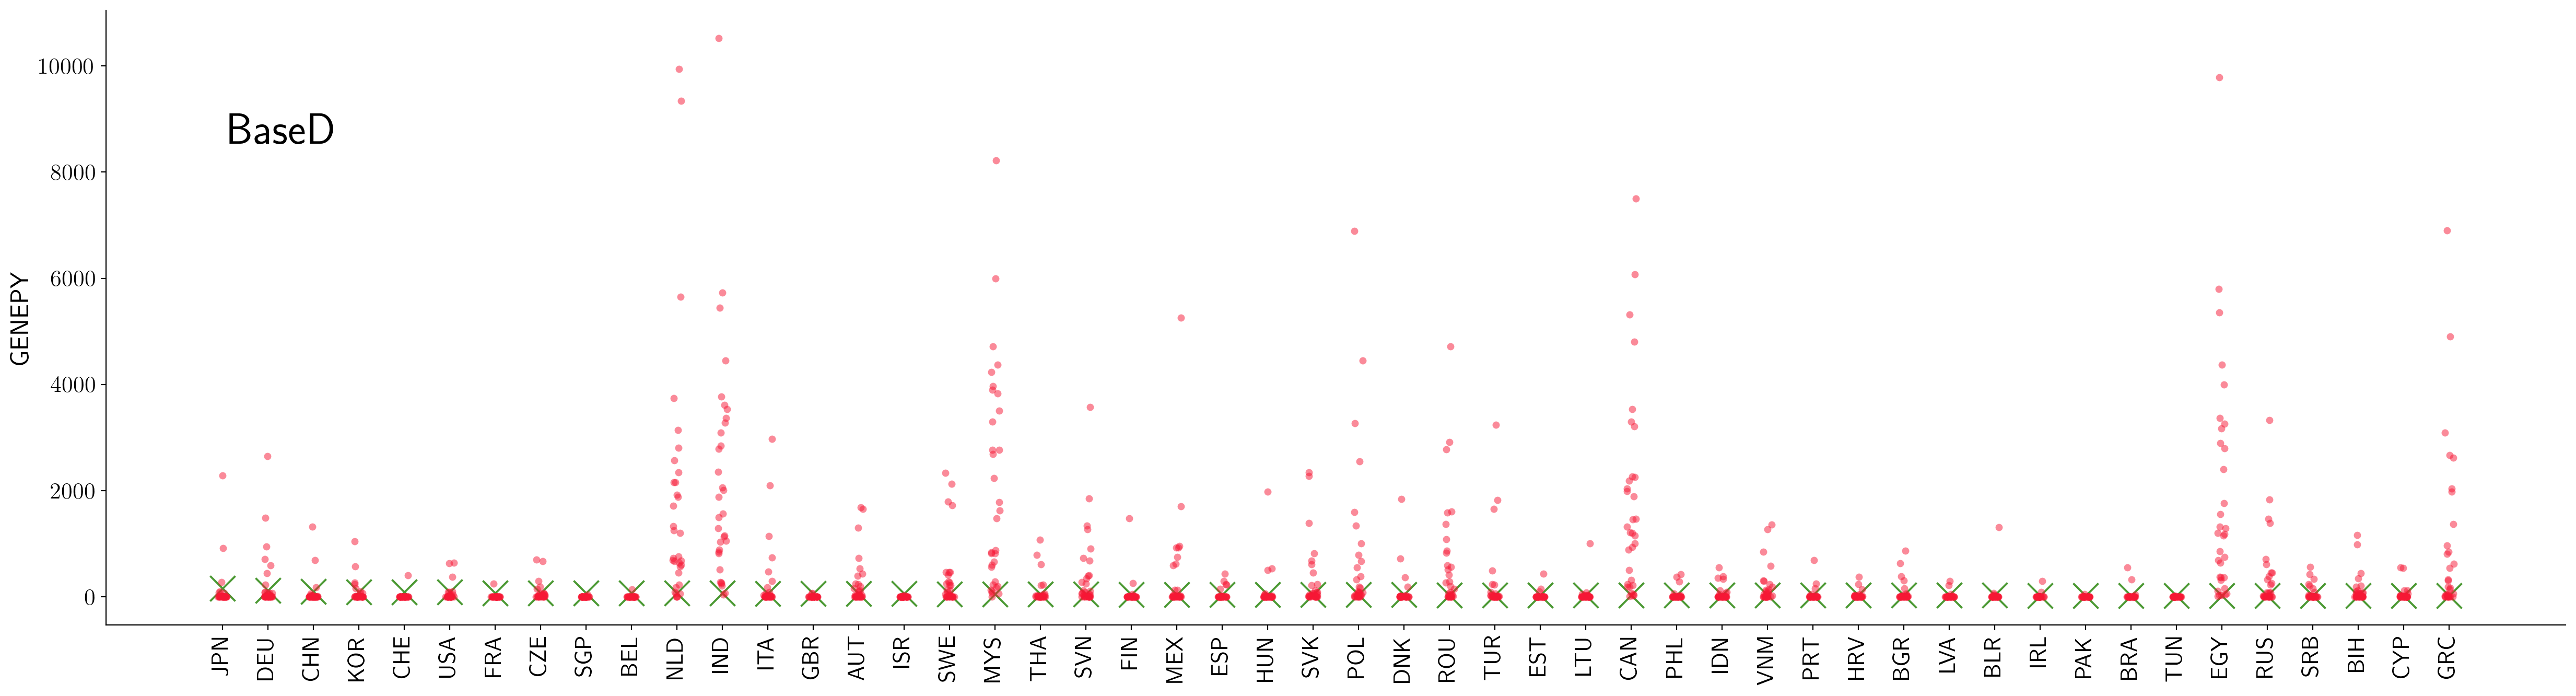

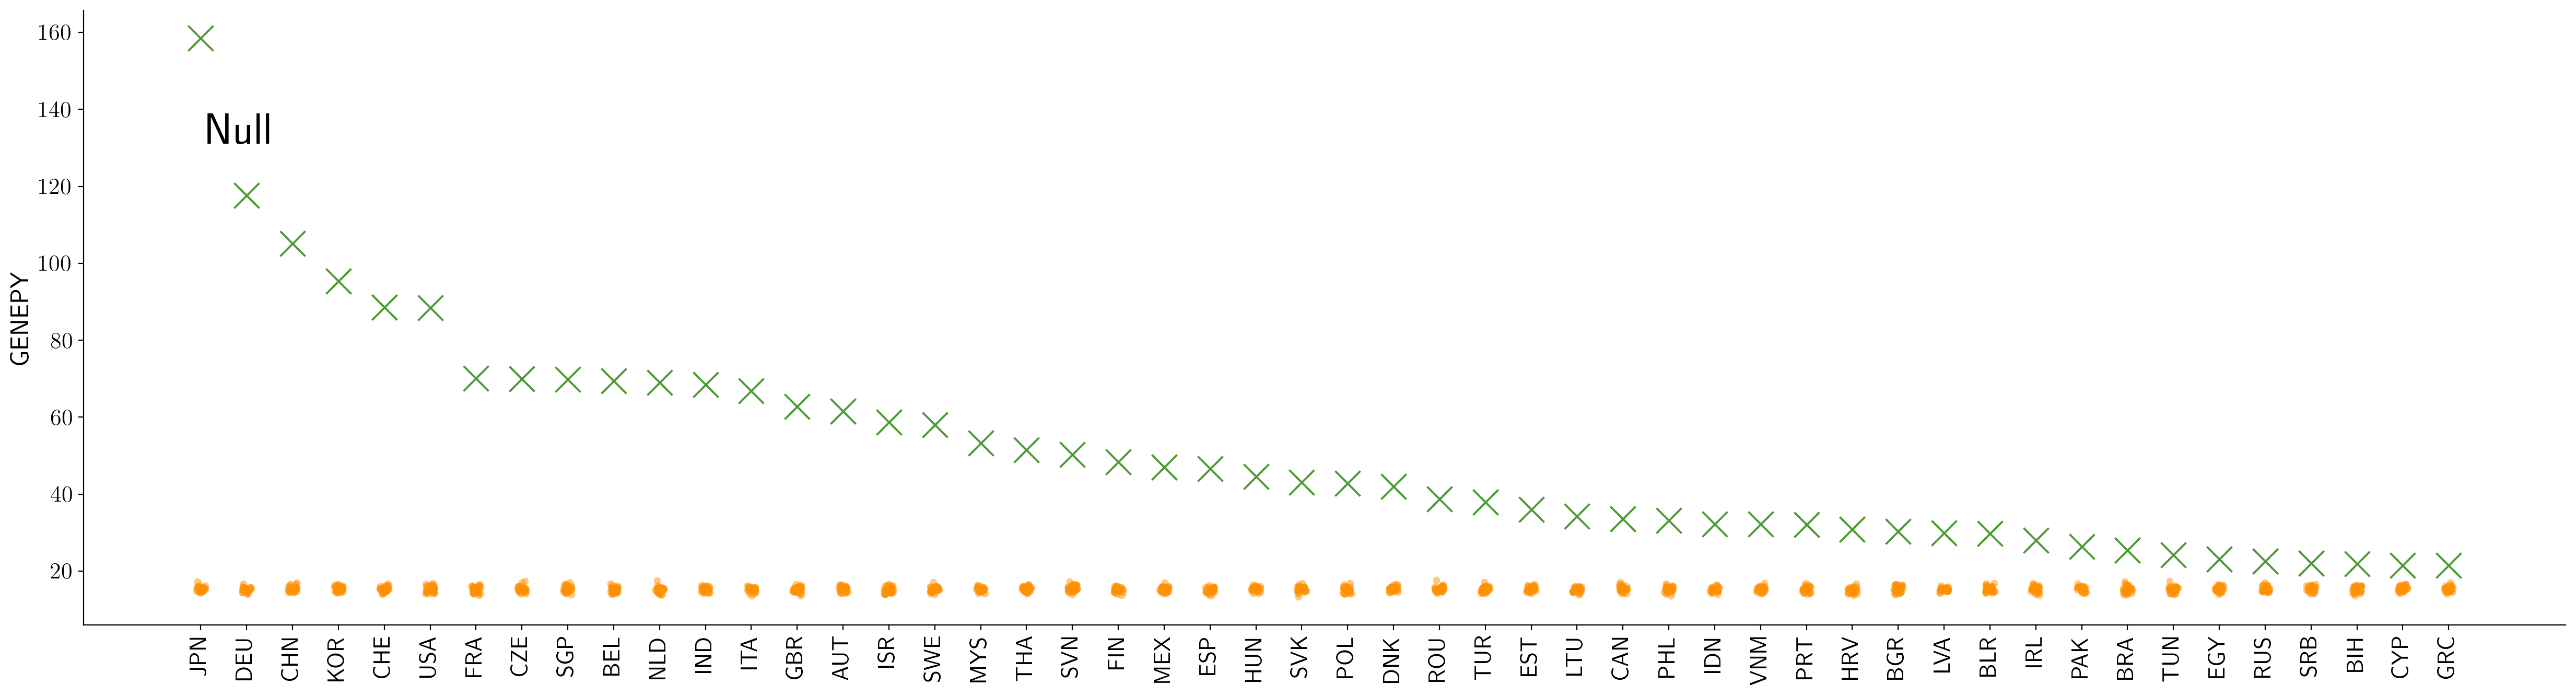

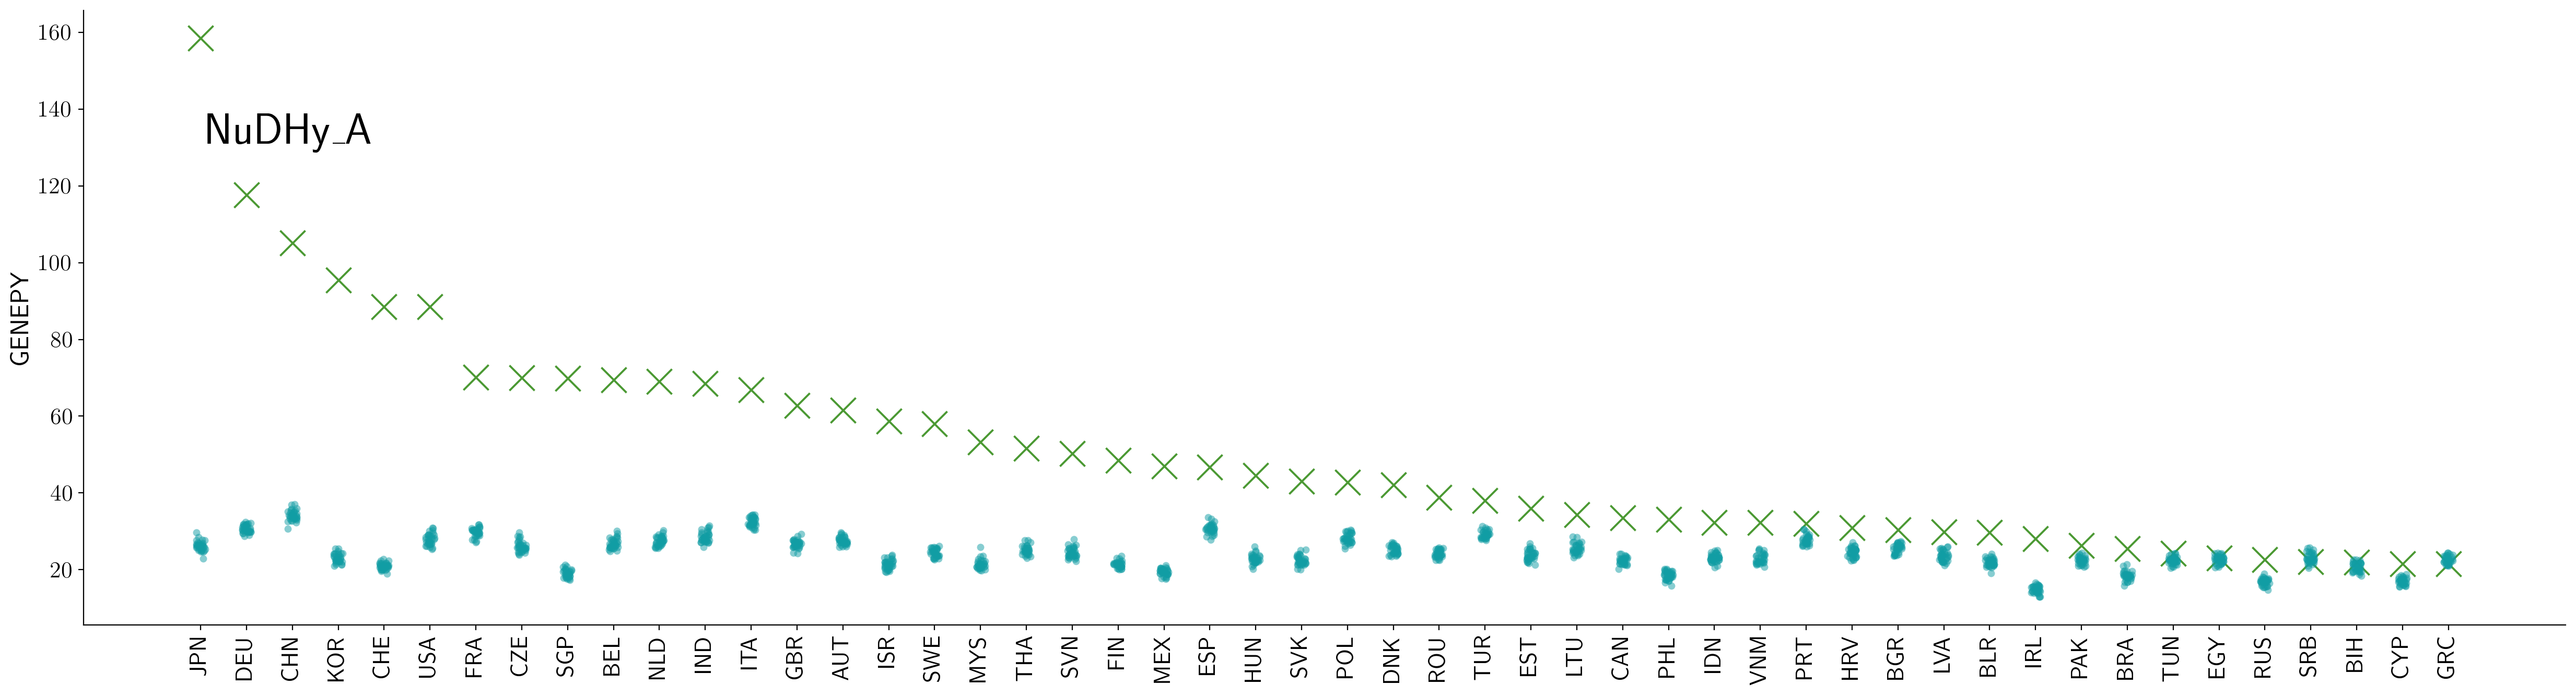

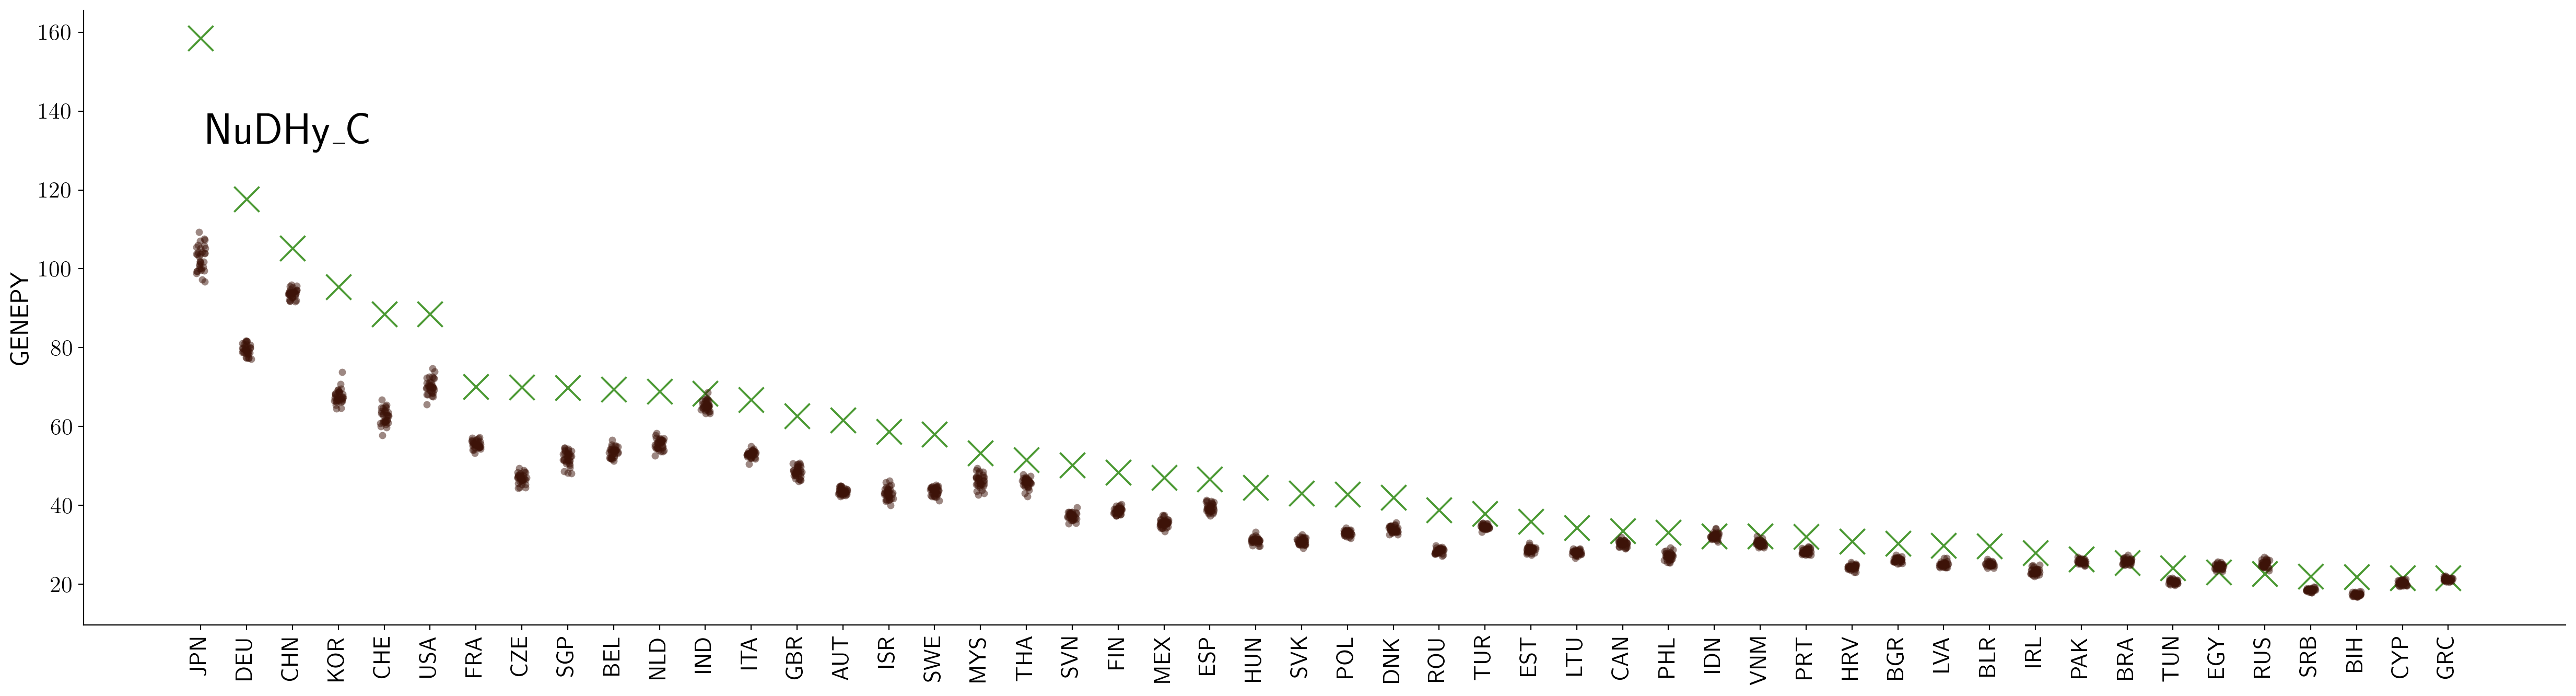

In [150]:
data = genepy_obs.sort_values(by='Genepy', ascending=False).head(top_n)
top_ = data['Country'].values

for idx, sam in enumerate(samplers_ord):

    fig, ax = plt.subplots(1, figsize=(25, 7))

    data2 = genepy[(genepy['Sampler'] == sam) &
                   (genepy['Country'].isin(top_))]
    data2 = pd.merge(data2, data.rename(columns={'Genepy': 'G'}), 
                     left_on=['VID', 'Country'], 
                     right_on=['VID', 'Country'])
    data2.sort_values(by='G', ascending=False, inplace=True)
    sns.stripplot(data=data2, x='Country', y='Genepy', dodge=True,
                  color=palette[idx], alpha=.5, ax=ax)
    sns.scatterplot(data=data, x='Country', y='Genepy', ax=ax, 
                    marker='x', color=palette[5], s=300)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_ylabel('GENEPY')
    ax.set_xlabel('')
    ax.text(0.05, 0.8, sam, transform=ax.transAxes, 
            fontsize=30, va='center')
    
    plt.tight_layout()
    plt.savefig(f'{root}_genepy_distribution_top{top_n}_{sam}_{side}.pdf')
    plt.show()

### ECI

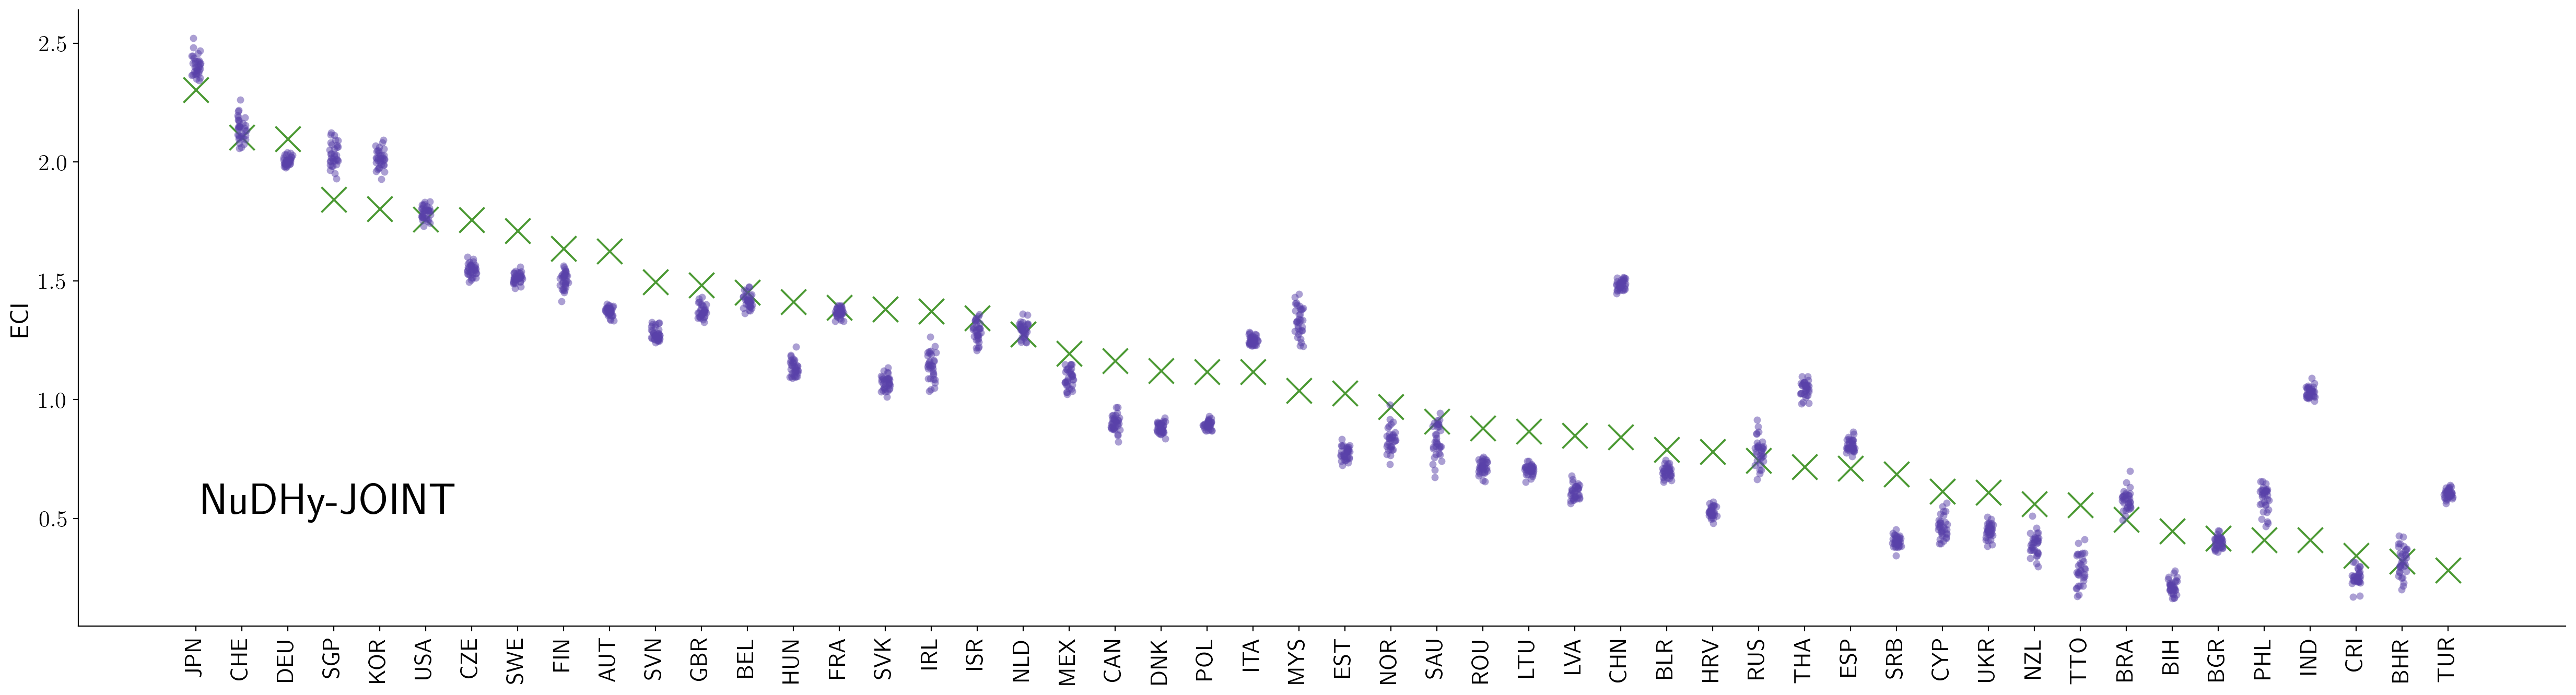

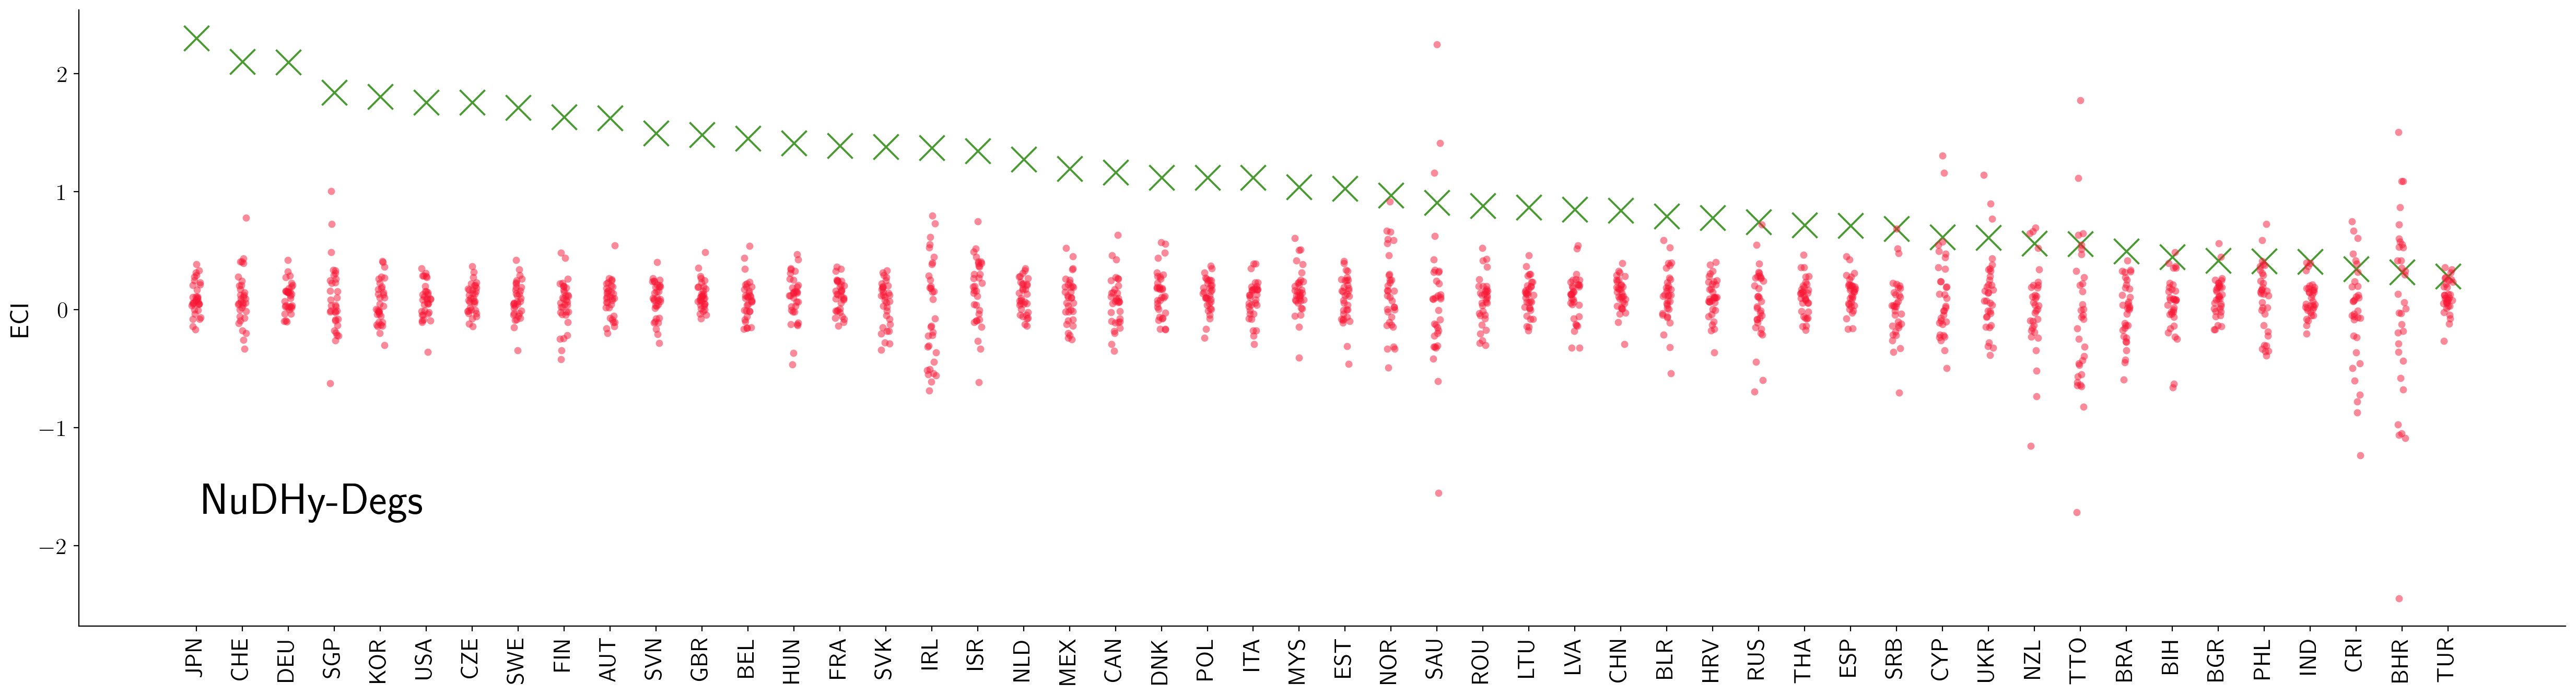

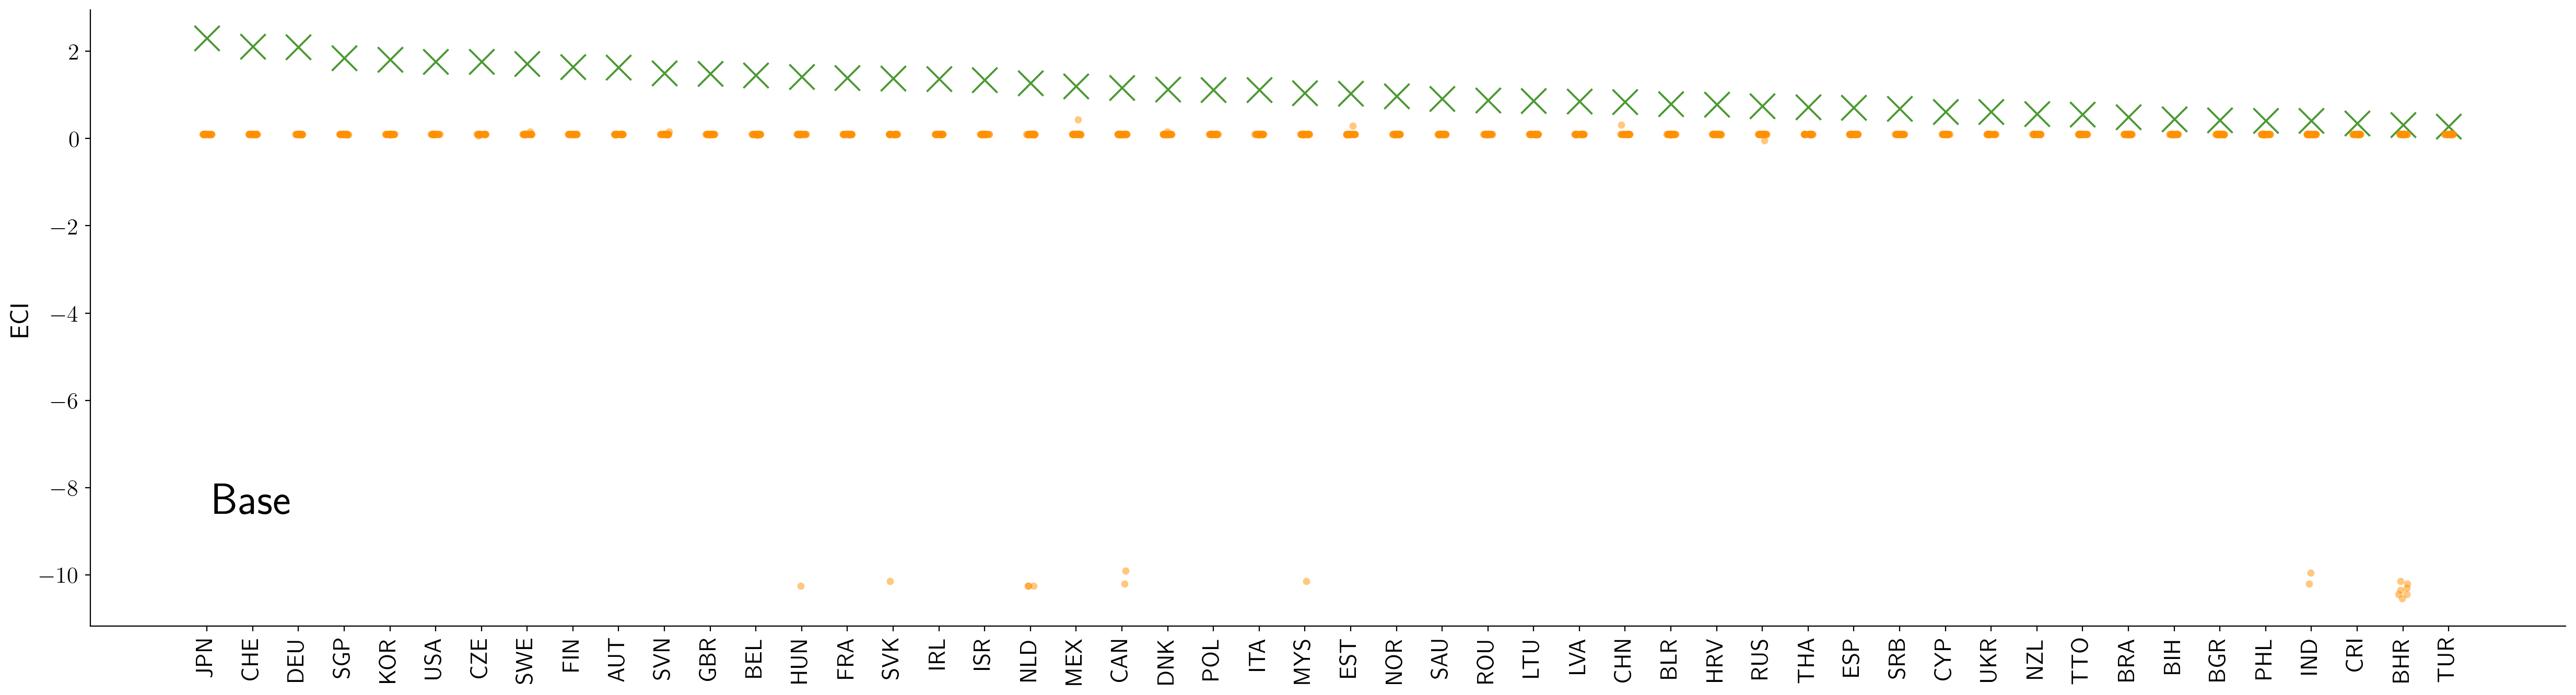

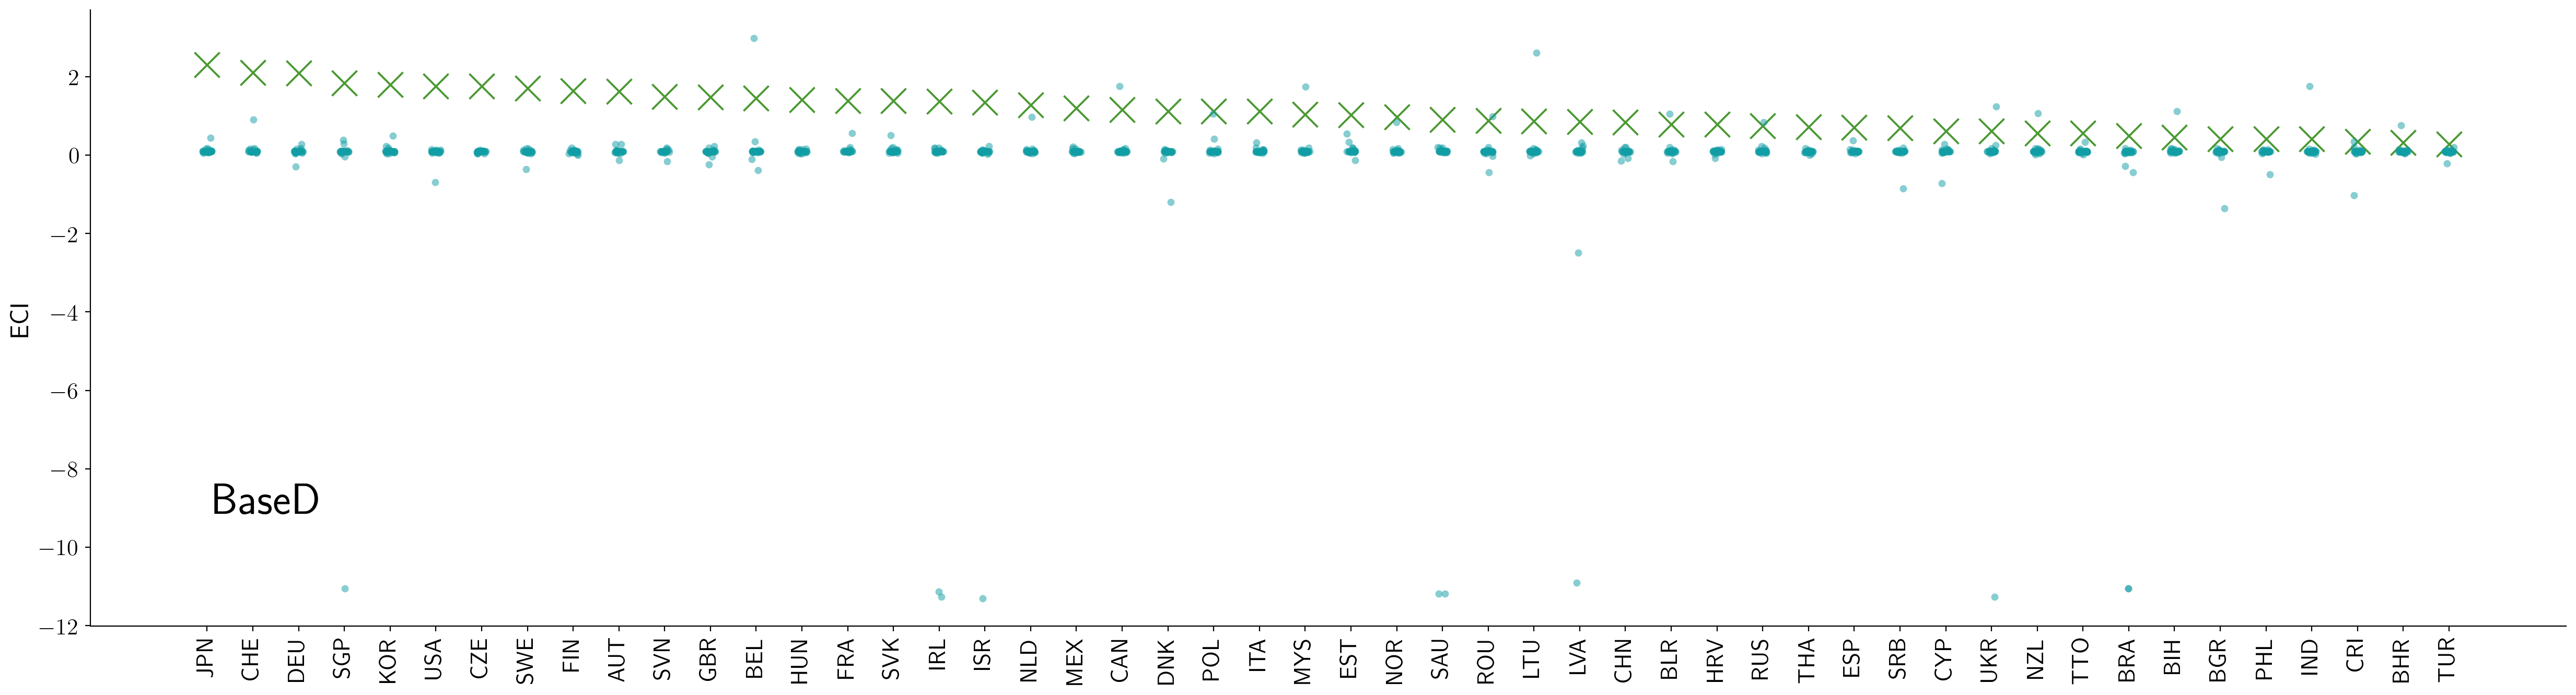

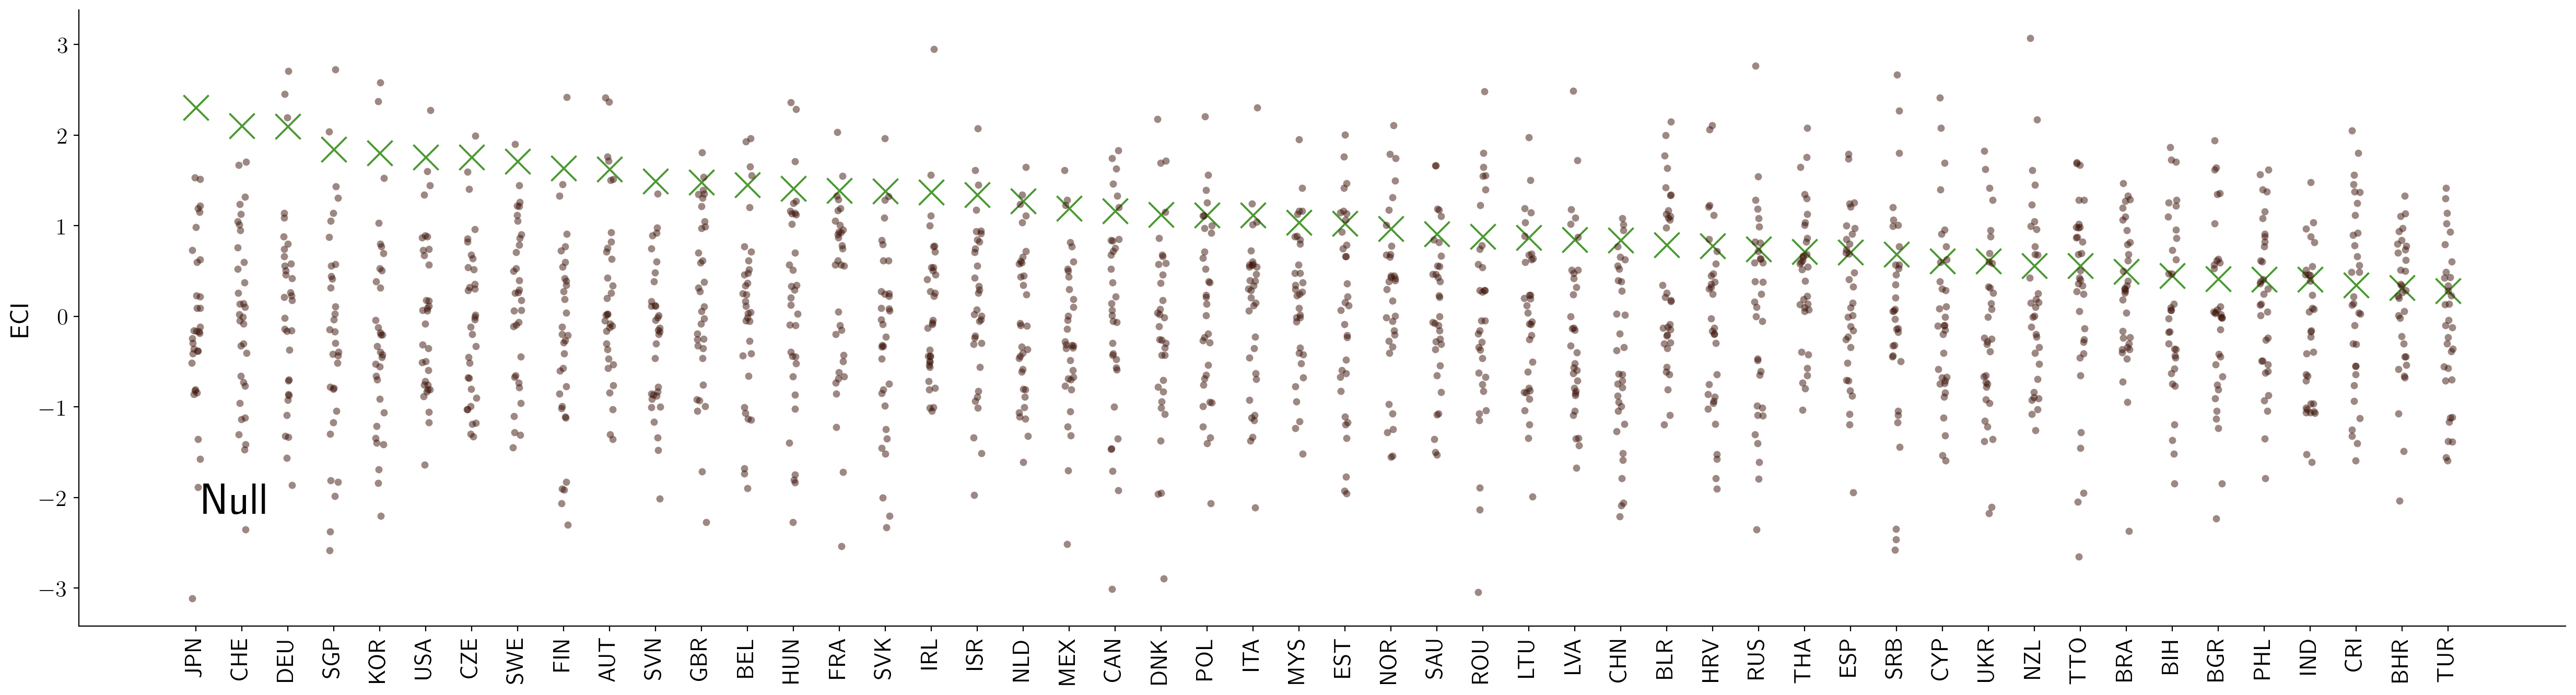

In [151]:
data = eci_obs.sort_values(by='ECI', ascending=False).head(top_n)
top_ = data['Country'].values

for idx, sam in enumerate(eci['Sampler'].unique()):

    fig, ax = plt.subplots(1, figsize=(25, 7))

    data2 = eci[(eci['Sampler'] == sam) &
                (eci['Country'].isin(top_))]
    data2 = pd.merge(data2, data.rename(columns={'ECI': 'E'}), 
                     left_on=['VID', 'Country'], 
                     right_on=['VID', 'Country'])
    data2.sort_values(by='E', ascending=False, inplace=True)
    sns.stripplot(data=data2, x='Country', y='ECI', dodge=True,
                  color=palette[idx], alpha=.5, ax=ax)
    sns.scatterplot(data=data, x='Country', y='ECI', ax=ax, 
                    marker='x', color=palette[5], s=300)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_ylabel('ECI')
    ax.set_xlabel('')
    ax.text(0.05, 0.2, sampler_names.get(sam, sam), 
            transform=ax.transAxes, fontsize=30, va='center')
    
    plt.tight_layout()
#     plt.savefig(f'{root}_eci_distribution_top50_{sam}_{side}.pdf')
    plt.show()

## Country Rankings

In [152]:
all_rankings = dict()

### GENEPY

In [153]:
# OBSERVED DATASET
ds = genepy_obs.sort_values(by='Genepy', ascending=False).copy()
ds['Rank'] = np.arange(len(ds)) + 1
ds['Sampler'] = dname
d_rank = ds.sort_values(by='VID')['Rank'].values
ranks = [ds[['Sampler', 'Country', 'Rank']]]

In [154]:
rank_comp = []

for sampler in genepy['Sampler'].unique():
    gen_samp = genepy[genepy['Sampler']==sampler]
    s_higher_rank = defaultdict(int)
    for sample_id in gen_samp['Seed'].unique():
        gen_ss = gen_samp[gen_samp['Seed']==sample_id].copy()

        ts = gen_ss.sort_values(by='Genepy', ascending=False).copy()
        ts['Rank'] = np.arange(len(ts)) + 1
        ts['Country'] = ts['VID'].apply(lambda x: c_index.loc[vmap.loc[x, 'VID'], 'Country'])
        s_rank = ts.sort_values(by='VID')['Rank'].values
        ranks.append(ts[['Sampler', 'Seed', 'Country', 'Rank']])
        
        for idx, r in enumerate(s_rank):
            if d_rank[idx] >= r:
                s_higher_rank[idx] += 1
    
        pear = pearsonr(d_rank, s_rank)[0]
        kt = kendalltau(d_rank, s_rank)[0]

        rank_comp.append([sampler, sample_id, pear, kt])

ranks = pd.concat(ranks)
rank_comp = pd.DataFrame(rank_comp, columns=['Sampler', 'Seed', 'Spearman', 'Kendall-Tau'])

all_rankings['GENEPY'] = ranks

In [155]:
output = rank_comp.copy()
output = output.groupby(by='Sampler').agg({'Spearman':['mean', 'std'],
                                          'Kendall-Tau': ['mean', 'std']})

In [156]:
print(output.T.to_latex(float_format="%.3f"))

\begin{tabular}{llrrrrr}
\toprule
 & Sampler & Base & BaseD & NuDHy_A & NuDHy_C & Null \\
\midrule
\multirow[t]{2}{*}{Spearman} & mean & 0.015 & 0.230 & 0.941 & 0.993 & -0.002 \\
 & std & 0.079 & 0.059 & 0.004 & 0.000 & 0.061 \\
\cline{1-7}
\multirow[t]{2}{*}{Kendall-Tau} & mean & 0.010 & 0.156 & 0.801 & 0.937 & -0.001 \\
 & std & 0.054 & 0.040 & 0.007 & 0.002 & 0.040 \\
\cline{1-7}
\bottomrule
\end{tabular}



### ECI

In [157]:
## OBSERVED DATASET
ds = eci_obs.sort_values(by='ECI', ascending=False).copy()
ds['Rank'] = np.arange(len(ds)) + 1
ds['Sampler'] = dname
ranks = [ds[['Sampler', 'Country', 'Rank']]]

In [158]:
ds.head(50)['Country'].values

array(['JPN', 'CHE', 'DEU', 'SGP', 'KOR', 'USA', 'CZE', 'SWE', 'FIN',
       'AUT', 'SVN', 'GBR', 'BEL', 'HUN', 'FRA', 'SVK', 'IRL', 'ISR',
       'NLD', 'MEX', 'CAN', 'DNK', 'POL', 'ITA', 'MYS', 'EST', 'NOR',
       'SAU', 'ROU', 'LTU', 'LVA', 'CHN', 'BLR', 'HRV', 'RUS', 'THA',
       'ESP', 'SRB', 'CYP', 'UKR', 'NZL', 'TTO', 'BRA', 'BIH', 'BGR',
       'PHL', 'IND', 'CRI', 'BHR', 'TUR'], dtype=object)

In [159]:
rank_comp = []

for sampler in eci['Sampler'].unique():
    eci_samp = eci[eci['Sampler']==sampler]
    s_higher_rank = defaultdict(int)
    for sample_id in eci_samp['Seed'].unique():
        eci_ss = eci_samp[eci_samp['Seed']==sample_id].copy()

        ts = eci_ss.sort_values(by='ECI', ascending=False).copy()
        ts['Rank'] = np.arange(len(ts)) + 1
        ts['Country'] = ts['VID'].apply(lambda x: c_index.loc[vmap.loc[x, 'VID'], 'Country'])
        common = set(ds['VID'].values)
        common = common.intersection(ts['VID'].values)
        d_rank = ds[ds['VID'].isin(common)].sort_values(by='VID')['Rank'].values
        s_rank = ts[ts['VID'].isin(common)].sort_values(by='VID')['Rank'].values
        
        for idx, r in enumerate(s_rank):
            if d_rank[idx] >= r:
                s_higher_rank[idx] += 1
        
        ranks.append(ts[['Sampler', 'Seed', 'Country', 'Rank']])

        pear = pearsonr(d_rank, s_rank)[0]
        kt = kendalltau(d_rank, s_rank)[0]

        rank_comp.append([sampler, sample_id, pear, kt])

ranks = pd.concat(ranks)
rank_comp = pd.DataFrame(rank_comp, columns=['Sampler', 'Seed', 'Spearman', 'Kendall-Tau'])

all_rankings['ECI'] = ranks

In [160]:
output = rank_comp.copy()
output = output.groupby(by='Sampler').agg({'Spearman':['mean', 'std'],
                                          'Kendall-Tau': ['mean', 'std']})

In [161]:
print(output.T.to_latex(float_format="%.3f"))

\begin{tabular}{llrrrrr}
\toprule
 & Sampler & Base & BaseD & NuDHy_A & NuDHy_C & Null \\
\midrule
\multirow[t]{2}{*}{Spearman} & mean & -0.144 & -0.055 & 0.020 & 0.964 & 0.007 \\
 & std & 0.143 & 0.120 & 0.121 & 0.001 & 0.093 \\
\cline{1-7}
\multirow[t]{2}{*}{Kendall-Tau} & mean & -0.092 & -0.037 & 0.015 & 0.848 & 0.005 \\
 & std & 0.092 & 0.079 & 0.082 & 0.004 & 0.062 \\
\cline{1-7}
\bottomrule
\end{tabular}



### Fitness

In [162]:
# OBSERVED DATASET
ds = fit_obs.sort_values(by='Fitness', ascending=False).copy()
ds['Rank'] = np.arange(len(ds)) + 1
ds['Sampler'] = dname
d_rank = ds.sort_values(by='VID')['Rank'].values
ranks = [ds[['Sampler', 'Country', 'Rank']]]

In [163]:
rank_comp = []

for sampler in fit['Sampler'].unique():
    fit_s = fit[fit['Sampler']==sampler]
    s_higher_rank = defaultdict(int)
    for sample_id in fit_s['Seed'].unique():
        fit_ss = fit_s[fit_s['Seed']==sample_id].copy()

        ts = fit_ss.sort_values(by='Fitness', ascending=False).copy()
        ts['Rank'] = np.arange(len(ts)) + 1
        ts['Country'] = ts['VID'].apply(lambda x: c_index.loc[vmap.loc[x, 'VID'], 'Country'])
        s_rank = ts.sort_values(by='VID')['Rank'].values
        ranks.append(ts[['Sampler', 'Seed', 'Country', 'Rank']])
        
        for idx, r in enumerate(s_rank):
            if d_rank[idx] >= r:
                s_higher_rank[idx] += 1
    
        pear = pearsonr(d_rank, s_rank)[0]
        kt = kendalltau(d_rank, s_rank)[0]

        rank_comp.append([sampler, sample_id, pear, kt])

ranks = pd.concat(ranks)
rank_comp = pd.DataFrame(rank_comp, columns=['Sampler', 'Seed', 'Spearman', 'Kendall-Tau'])

all_rankings['Fitness'] = ranks

In [164]:
output = rank_comp.copy()
output = output.groupby(by='Sampler').agg({'Spearman':['mean', 'std'],
                                           'Kendall-Tau': ['mean', 'std']})

In [165]:
print(output.T.to_latex(float_format="%.3f"))

\begin{tabular}{llrrrrr}
\toprule
 & Sampler & Base & BaseD & NuDHy_A & NuDHy_C & UnpretentiousNullModel \\
\midrule
\multirow[t]{2}{*}{Spearman} & mean & 0.051 & 0.237 & 0.981 & 0.998 & -0.013 \\
 & std & 0.075 & 0.055 & 0.001 & 0.000 & 0.075 \\
\cline{1-7}
\multirow[t]{2}{*}{Kendall-Tau} & mean & 0.034 & 0.160 & 0.886 & 0.963 & -0.010 \\
 & std & 0.051 & 0.038 & 0.003 & 0.001 & 0.052 \\
\cline{1-7}
\bottomrule
\end{tabular}



### Plots

In [166]:
color1 = [colors[3], colors[4], colors[5]]
linecolor1 = ['#0A585C', '#6C210E', '#346B24']
plot_nums = ['a)', 'b)', 'c)', 'd)']

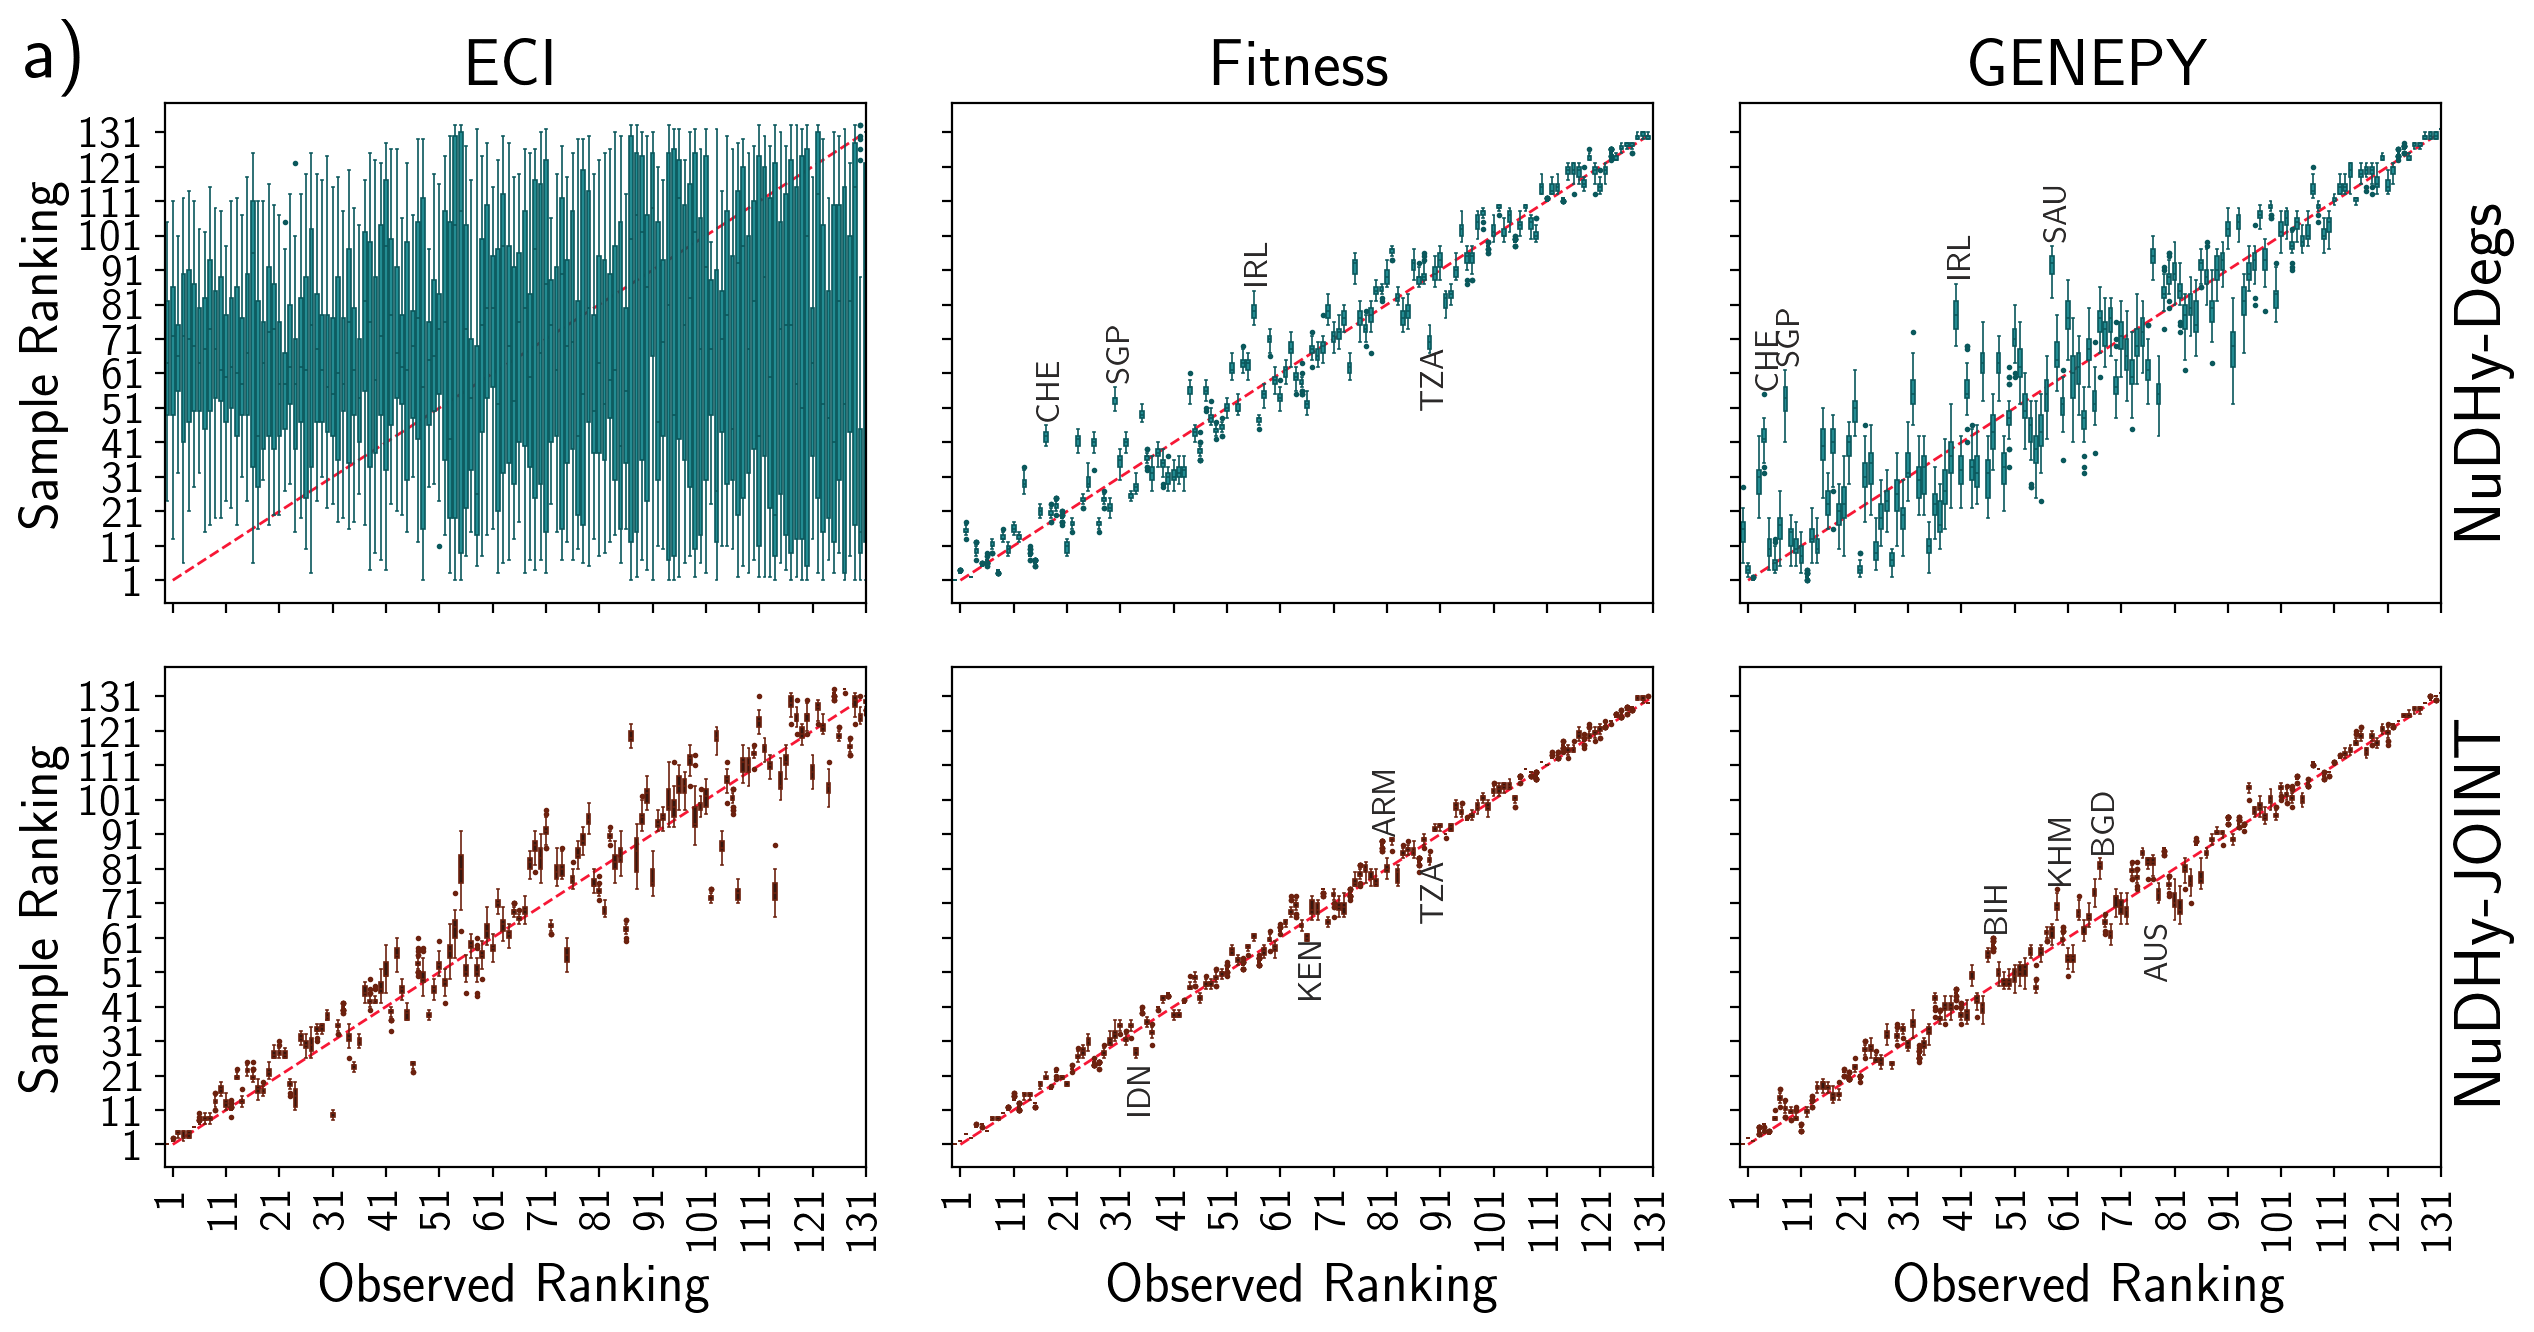

In [232]:
fig, ax = plt.subplots(2,3, figsize=(13, 7), sharex=True, sharey=True)

for idx, sc in enumerate(['ECI', 'Fitness', 'GENEPY']):
    
    ranks = all_rankings[sc]

    for sid, sam in enumerate(['NuDHy_A', 'NuDHy_C']):

        data_obs = ranks[ranks['Sampler']==dname][['Country', 'Rank']]
        data_obs.columns = ['Country', 'Obs Rank']
        datas = ranks[ranks['Sampler']==sam].copy()
        datas = datas.merge(data_obs)

        ax[sid][idx].plot([1, datas['Rank'].max()], [1, datas['Rank'].max()], 
                          color='#F71735', linewidth=1, linestyle='--')
        box = sns.boxplot(data=datas, x='Obs Rank', y='Rank', color=color1[sid], width=1,
                          gap=.3, linewidth=.6, fliersize=1, linecolor=linecolor1[sid], ax=ax[sid][idx])
        ax[sid][idx].set_xlabel('Observed Ranking', fontsize=20)
        ax[sid][idx].set_ylabel('Sample Ranking', fontsize=20)
        ax[sid][idx].set_xticks(np.arange(1, 134, 10), np.arange(1, 134, 10), rotation=90)
        ax[sid][idx].set_yticks(np.arange(1, 134, 10), np.arange(1, 134, 10))
        ax[sid][idx].spines['right'].set_visible(True)
        ax[sid][idx].spines['top'].set_visible(True)
        
        # annotations ---------
        df1 = datas.groupby('Obs Rank')['Rank'].agg(Max='max', Min='min')
        avg_rank = datas.groupby(by=['Obs Rank', 'Country'])['Rank'].mean().reset_index()
        avg_rank['Abs Diff'] = (avg_rank['Rank'] - avg_rank['Obs Rank']).apply(abs)
        avg_rank['Diff'] = (avg_rank['Rank'] - avg_rank['Obs Rank'])
        top_diffs = avg_rank.sort_values(by='Abs Diff', ascending=False).head(4).set_index('Obs Rank')
        if sc != 'ECI':
            for i in df1.Max.index:
                if i in top_diffs.index:
                    if top_diffs.loc[i, 'Diff'] > 0:
                        box.annotate(top_diffs.loc[i, 'Country'], xy=(i, df1.Max[i]+3), 
                                     ha='center', color='#2A2828', rotation=90, fontsize=12)
                    else:
                        if top_diffs.loc[i, 'Country'] == 'AUS':
                            box.annotate(top_diffs.loc[i, 'Country'], xy=(i-5, df1.Min[i]-15), 
                                         ha='center', color='#2A2828', rotation=90, fontsize=12)
                        else:
                            box.annotate(top_diffs.loc[i, 'Country'], xy=(i, df1.Min[i]-15), 
                                         ha='center', color='#2A2828', rotation=90, fontsize=12)
        # ---------------------

        if sid == 0:
            ax[sid][idx].set_title(sc, fontsize=24)
        if idx == 2:
            ax[sid][idx].text(1.02, 0.15, sampler_names.get(sam, sam), 
                             fontsize=24, transform=ax[sid][idx].transAxes,
                             rotation=90)
ax[0][0].text(-0.2, 1.05, f'a)', fontsize=28, transform=ax[0][0].transAxes)
plt.tight_layout()
plt.savefig(f'{root}_all_rankings_box.pdf', bbox_inches='tight')
plt.show()

## Comparison Bi-Adjancency Matrices

### Ranking of Countries and Products

In [168]:
both_ranks = dict()

In [169]:
r_c_names = {
    'ECI': ['ECI', 'PCI'],
    'Fitness': ['Fitness', 'Quality']
}

In [170]:
min0 = 0
min1 = 0
max0 = None
max1 = None

ECI and PCI

In [171]:
ci = eci_obs.sort_values(by='ECI', ascending=False).copy()
ci['Rank'] = np.arange(len(ci))
ci.set_index('VID', inplace=True)

pi = pd.read_csv(f'{met_path}pci_{root}_{side}.tsv', sep='\t', header=None)
pi.columns = ['PID', 'PC']
pi = pi.sort_values(by='PC', ascending=False)
pi['Rank'] = np.arange(len(pi))
pi.set_index('PID', inplace=True)

max0 = len(ci) - 1
max1 = len(pi) - 1

both_ranks['ECI'] = (ci, pi)

Fitness and Complexity

In [172]:
ci = fit_obs.sort_values(by='Fitness', ascending=False).copy()
ci['Rank'] = np.arange(len(ci))
ci.set_index('VID', inplace=True)

pi = pd.read_csv(f'{met_path}complexity_{root}_{side}.tsv', sep='\t', header=None)
pi.columns = ['PID', 'PC']
pi = pi.sort_values(by='PC', ascending=False)
pi['Rank'] = np.arange(len(pi))
pi.set_index('PID', inplace=True)

max0 = max(max0, len(ci) - 1)
max1 = max(max1, len(pi) - 1)

both_ranks['Fitness'] = (ci, pi)

In [173]:
x, y = np.meshgrid(np.linspace(min0, max0, 100), np.linspace(min1, max1, 100))
grid_coords = np.vstack([x.ravel(), y.ravel()])

### KDE

Observed

In [174]:
vmap = dict()
with open(data_path+root+'.tsv') as data_f:
    edges = read_as_bipartite(data_f, vmap, 'head')

In [175]:
kdes_obs = dict()

for sc, (ci, pi) in both_ranks.items():
    Mo = []
    for e in edges:
        r_e = [ci.loc[e[0], 'Rank'], pi.loc[e[1], 'Rank']]
        Mo.append(r_e)
    Mo = np.array(Mo, dtype='float')
    # Compute KDE
    kde = gaussian_kde(Mo.T)
    kde_mat = kde(grid_coords)
    kde_mat = kde_mat.reshape(x.shape)
    kdes_obs[sc] = kde_mat

Samples

In [176]:
file_path = f'{sample_path}/NuDHy/{root}.zip'
z = zipfile.ZipFile(file_path, "r")
zinfo = z.namelist()

In [177]:
sedges = dict()
sedges['ECI'] = dict()
sedges['Fitness'] = dict()
sedges['ECI']['NuDHy_A'] = defaultdict(int)
sedges['ECI']['NuDHy_C'] = defaultdict(int)
sedges['Fitness']['NuDHy_A'] = defaultdict(int)
sedges['Fitness']['NuDHy_C'] = defaultdict(int)

In [178]:
kdes_samp = dict()
kdes_samp['ECI'] = dict()
kdes_samp['Fitness'] = dict()
kdes_samp['ECI']['NuDHy_A'] = []
kdes_samp['ECI']['NuDHy_C'] = []
kdes_samp['Fitness']['NuDHy_A'] = []
kdes_samp['Fitness']['NuDHy_C'] = []

In [50]:
for file_name in zinfo:
    if file_name.startswith(".") or file_name.startswith("__MACOSX"):
        continue
    if not file_name.endswith('.tsv'):
        continue
    with z.open(file_name, 'r') as f1:
        map_fields = parse_file_name(file_name, 'NuDHy')
        fobj = io.TextIOWrapper(f1, encoding='utf-8', newline='')
        this_sedges = read_as_bipartite(fobj, vmap, 'head')
        
        for sc, (ci, pi) in both_ranks.items():
            Ms = []
            for e in this_sedges:
                r_e = [ci.loc[e[0], 'Rank'], pi.loc[e[1], 'Rank']]
                sedges[sc][map_fields['algorithm']][tuple(r_e)] += 1
                Ms.append(r_e)
            Ms = np.array(Ms, dtype='float')
            # Compute KDE
            kdes = gaussian_kde(Ms.T)
            kde_mats = kdes(grid_coords)
            kde_mats = kde_mats.reshape(x.shape)
            kdes_samp[sc][map_fields['algorithm']].append(kde_mats)

In [51]:
kdes_avg_samp = dict()
kdes_avg_samp['ECI'] = dict()
kdes_avg_samp['Fitness'] = dict()

In [52]:
for sc in sedges:
    for sam in sedges[sc]:
        Ms = []    
        for r_e in sedges[sc][sam]:
            for _ in range(sedges[sc][sam][r_e]):
                Ms.append(r_e)
        Ms = np.array(Ms, dtype='float')
        # Compute KDE
        kdes = gaussian_kde(Ms.T, weights=[1/33]*Ms.shape[0])
        kde_mats = kdes(grid_coords)
        kde_mats = kde_mats.reshape(x.shape)
        kdes_avg_samp[sc][sam] = kde_mats

### Plots

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_63564/3050537488.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


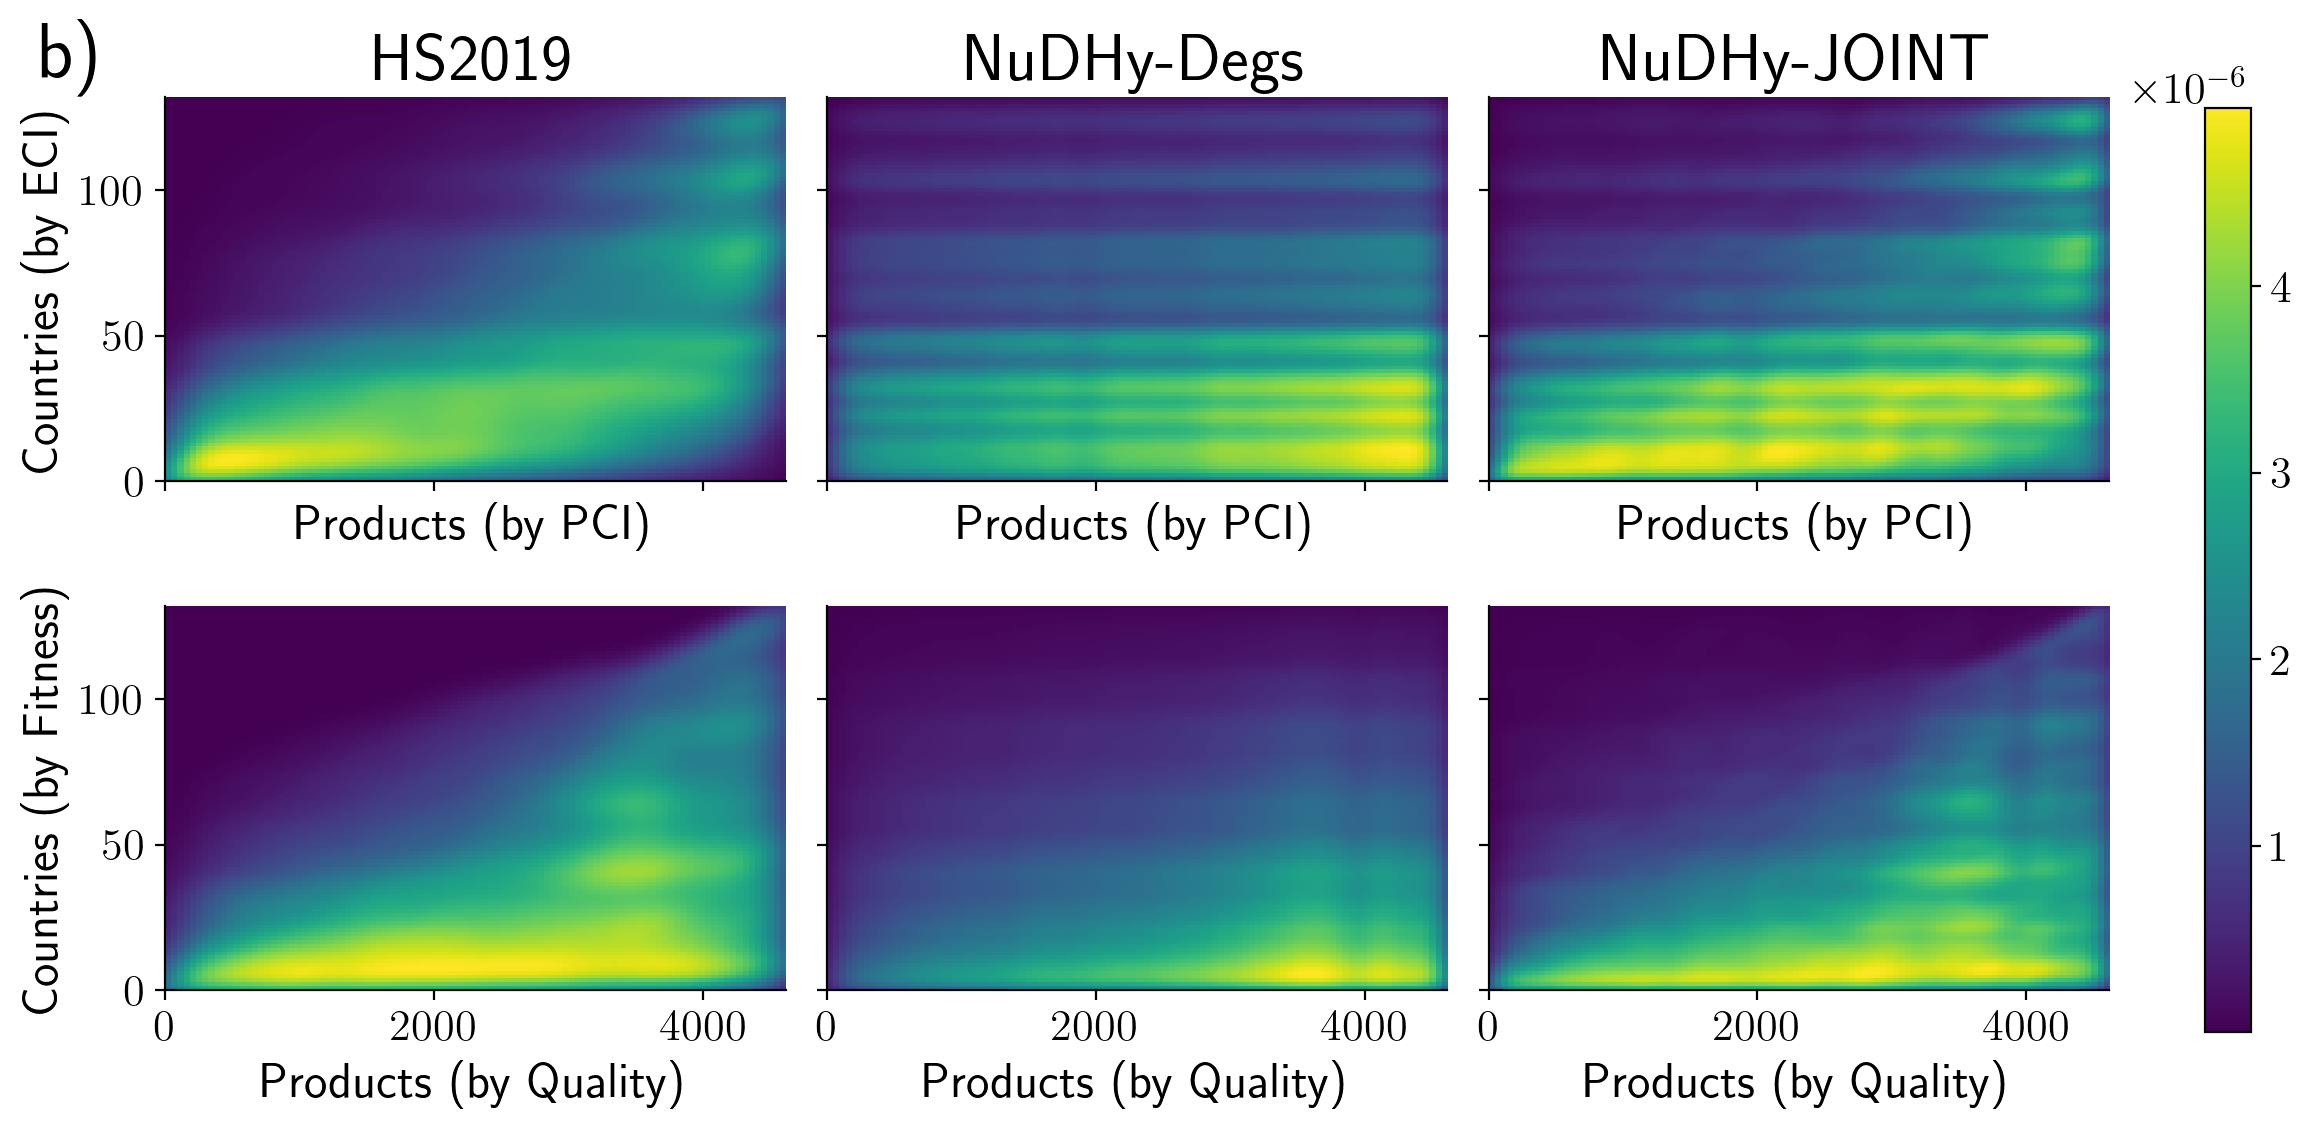

In [241]:
fig, ax = plt.subplots(2, 3, figsize=(13, 6), sharex=True, sharey=True)

for ix, sc in enumerate(r_c_names):
    
    c_name = r_c_names[sc][1]
    r_name = r_c_names[sc][0]

    img = ax[ix][0].imshow(np.transpose(kdes_obs[sc]), cmap='viridis', interpolation='none',
                           aspect='auto', origin='lower', 
                           extent=(min1, max1, min0, max0))
    
    if ix == 0:
        ax[ix][0].set_title(dname, fontsize=24)
    ax[ix][0].set_xlabel(f'Products (by {c_name})', fontsize=18)
    ax[ix][0].set_ylabel(f'Countries (by {r_name})', fontsize=18)

    for idx, dat in enumerate(kdes_avg_samp[sc].items()):
        img = ax[ix][idx+1].imshow(np.transpose(dat[1]), cmap='viridis', interpolation='none',
                               aspect='auto', origin='lower', 
                               extent=(min1, max1, min0, max0))
        if ix == 0:
            ax[ix][idx+1].set_title(sampler_names[dat[0]], fontsize=24)
        ax[ix][idx+1].set_ylabel('')
        ax[ix][idx+1].set_xlabel(f'Products (by {c_name})', fontsize=18)

fig.colorbar(img, ax=ax, orientation='vertical', pad=-0.25, fraction=0.05)
ax[0][0].text(-0.2, 1.05, f'b)', fontsize=28, transform=ax[0][0].transAxes)
plt.tight_layout()
plt.savefig(f'{root}_kde_matrices.pdf', bbox_inches='tight')
plt.show()

# Affinity

In [1008]:
met_path = results_path + 'affinity/'

## Congress Bills

In [1009]:
class_map = {0: 'Democrats', #100
             1: 'Republicans', #200
             2: 'Independents', #328
             3: 'Conservatives', #112
             4: 'Unknown'}

In [1010]:
plot_titles = {
    'H': 'House',
    'S': 'Senate'
}
plot_nums = {
    'H': ['c)', 'd)'],
    'S': ['a)', 'b)']
}

In [1011]:
palette_congress = ['#CC141A', #'Republicans'
                    '#0092CC', #'Democrats'
                    '#800080', #'Independents'
                    '#4B9933', #'Conservatives'
                   ]
bk_cols = ['#EE585D', '#33C5FF']

In [1012]:
styles = ['-', '--']
markers = ['o', 'x']

In [1013]:
start = 93
end = 108

In [1014]:
root = 'congress_bills'

In [1015]:
house = 'H'
title = plot_titles[house]
p_nums = plot_nums[house]

Node Labels

In [1016]:
vmap_per_congr = dict()
class_per_congr = dict()
num_v_per_class_per_congr = dict()

for congr in range(start, end+1):
    if congr < 100:
        congr_str = f'0{congr}'
    else:
        congr_str = f'{congr}'
    vmap_ = defaultdict(int)
    with open(f'{data_path}{root}_{house}_{congr_str}.tsv') as in_f:
        _, _ = read_as_directed_hyperedge_list(in_f, vmap_)
    vmap_per_congr[congr] = vmap_
    
    with open(f'{data_path}{root}_classes.tsv') as in_f:
        classes_ = read_classes(in_f, vmap_)
    class_per_congr[congr] = classes_
    num_v_per_class_ = np.zeros(5)
    for v, c in classes_.items():
        num_v_per_class_[c] += 1
    num_v_per_class_per_congr[congr] = num_v_per_class_

Congress Info

In [1017]:
if house == 'S':
    congress_info = pd.read_csv(met_path + 'senate_congress_info.tsv', sep='\t')
else:
    congress_info = pd.read_csv(met_path + 'house_congress_info.tsv', sep='\t')
congress_info.set_index('Congress', inplace=True)

In [1018]:
c_inf = congress_info.reset_index().set_index('Start')

Affinity per Congress

In [1019]:
aff_per_congr = []
aff_obs_per_congr = []
for congr in congress_info.index:
    if congr < 100:
        congr_str = f'0{congr}'
    else:
        congr_str = f'{congr}'
    aff_samples_ = pd.read_csv(met_path + f"affinity_{root}_{house}_{congr_str}_samples.tsv", sep='\t')
    avg_aff_ = aff_samples_.groupby(by=['Sampler',
                                        'Class',
                                        'Hyperedge Size',
                                        'Alpha',
                                        'Type']).agg({'Affinity': 'mean'}).reset_index()
    aff_obs = pd.read_csv(met_path + f"affinity_{root}_{house}_{congr_str}.tsv", sep='\t')
    aff_obs_ = aff_obs.rename(columns={'Affinity': 'Aff'})
    aff_obs['Congress'] = congr
    aff_obs_per_congr.append(aff_obs)
    avg_aff_ = pd.merge(avg_aff_, aff_obs_, how='left', on=['Class', 'Hyperedge Size', 'Alpha', 'Type'])
    avg_aff_.fillna(0, inplace=True)
    avg_aff_['Affinity Ratio'] = avg_aff_['Aff'] / avg_aff_['Affinity']
    avg_aff_['Party'] = avg_aff_['Class'].apply(lambda x : class_map[x])
    avg_aff_ = avg_aff_[avg_aff_['Party'] != 'Unknown']
    avg_aff_['Congress'] = congr
    aff_per_congr.append(avg_aff_)
aff_per_congr = pd.concat(aff_per_congr)
aff_obs_per_congr = pd.concat(aff_obs_per_congr)

Homophily per Congress

In [1020]:
homo_per_congr = []
homo_obs_per_congr = []
for congr in congress_info.index:
    if congr < 100:
        congr_str = f'0{congr}'
    else:
        congr_str = f'{congr}'
    homo_samples_ = pd.read_csv(met_path + f"homophily_{root}_{house}_{congr_str}_samples.tsv", sep='\t')
    homo_samples_ = homo_samples_.groupby(by=['Sampler',
                                              'Type']).agg({'Value': ['mean', 'std']}).reset_index()
    homo_samples_ = homo_samples_.droplevel(0, axis=1)
    homo_samples_.columns = ['Sampler', 'Type', 'Mean', 'STD']
    homo_obs = pd.read_csv(met_path + f"homophily_{root}_{house}_{congr_str}.tsv", sep='\t')
    homo_samples_ = pd.merge(homo_samples_, homo_obs, how='left', on=['Type'])
    homo_samples_.fillna(0, inplace=True)
    homo_obs['Congress'] = congr
    homo_obs_per_congr.append(homo_obs)
    homo_samples_['z-score'] = (homo_samples_['Value'] - homo_samples_['Mean']) / homo_samples_['STD']
    homo_samples_['Ratio'] = homo_samples_['Value'] / homo_samples_['Mean']
    homo_samples_['Party'] = homo_samples_['Type'].apply(lambda x : class_map[int(x[1])])
    homo_samples_ = homo_samples_[homo_samples_['Party'] != 'Unknown']
    homo_samples_['Congress'] = congr
    homo_per_congr.append(homo_samples_)
homo_per_congr = pd.concat(homo_per_congr)
homo_obs_per_congr = pd.concat(homo_obs_per_congr)

In [1021]:
homo_per_congr = homo_per_congr[~homo_per_congr['Type'].isin(['M0-4', 'M1-4', 'M2-4', 'M3-4', 'M4-4'])]

In [1022]:
homo_per_congr = homo_per_congr.fillna(0)

### Homophily

In [1023]:
to_plot_vals = []
to_plot_ratio = []

for congr in homo_per_congr['Congress'].unique():
    homo_obs = homo_obs_per_congr[homo_obs_per_congr['Congress']==congr]
    for c in [0, 1]:
        y_v = homo_obs[homo_obs['Type']==f'M{c}-{c}']['Value'].values[0]
        if c == 0:
            den = congress_info.loc[congr, 'Num Dem. Bills']
        else:
            den = congress_info.loc[congr, 'Num Rep. Bills']
        to_plot_vals.append([y_v / den, class_map[c], 'Obs. Dataset', congr])

    for idx, sampler in enumerate(['NuDHy_A', 'NuDHy_C']):
        df = homo_per_congr[(homo_per_congr['Sampler']==sampler) &
                            (homo_per_congr['Congress']==congr)]
        for c in [0, 1]:
            y_v = df[df['Type']==f'M{c}-{c}']['Mean'].values[0]
            if c == 0:
                den = congress_info.loc[congr, 'Num Dem. Bills']
            else:
                den = congress_info.loc[congr, 'Num Rep. Bills']
            to_plot_vals.append([y_v / den, class_map[c], sampler, congr])

            y_v = df[df['Type']==f'M{c}-{c}']['Ratio'].values[0]
            to_plot_ratio.append([y_v, class_map[c], sampler, congr])

df_plot_vals = pd.DataFrame(to_plot_vals, columns=['Homophily', 'Party', 'Score', 'Congress'])
df_plot_ratio = pd.DataFrame(to_plot_ratio, columns=['Homophily', 'Party', 'Baseline Score', 'Congress'])

Homophily in Observed Hypergraph

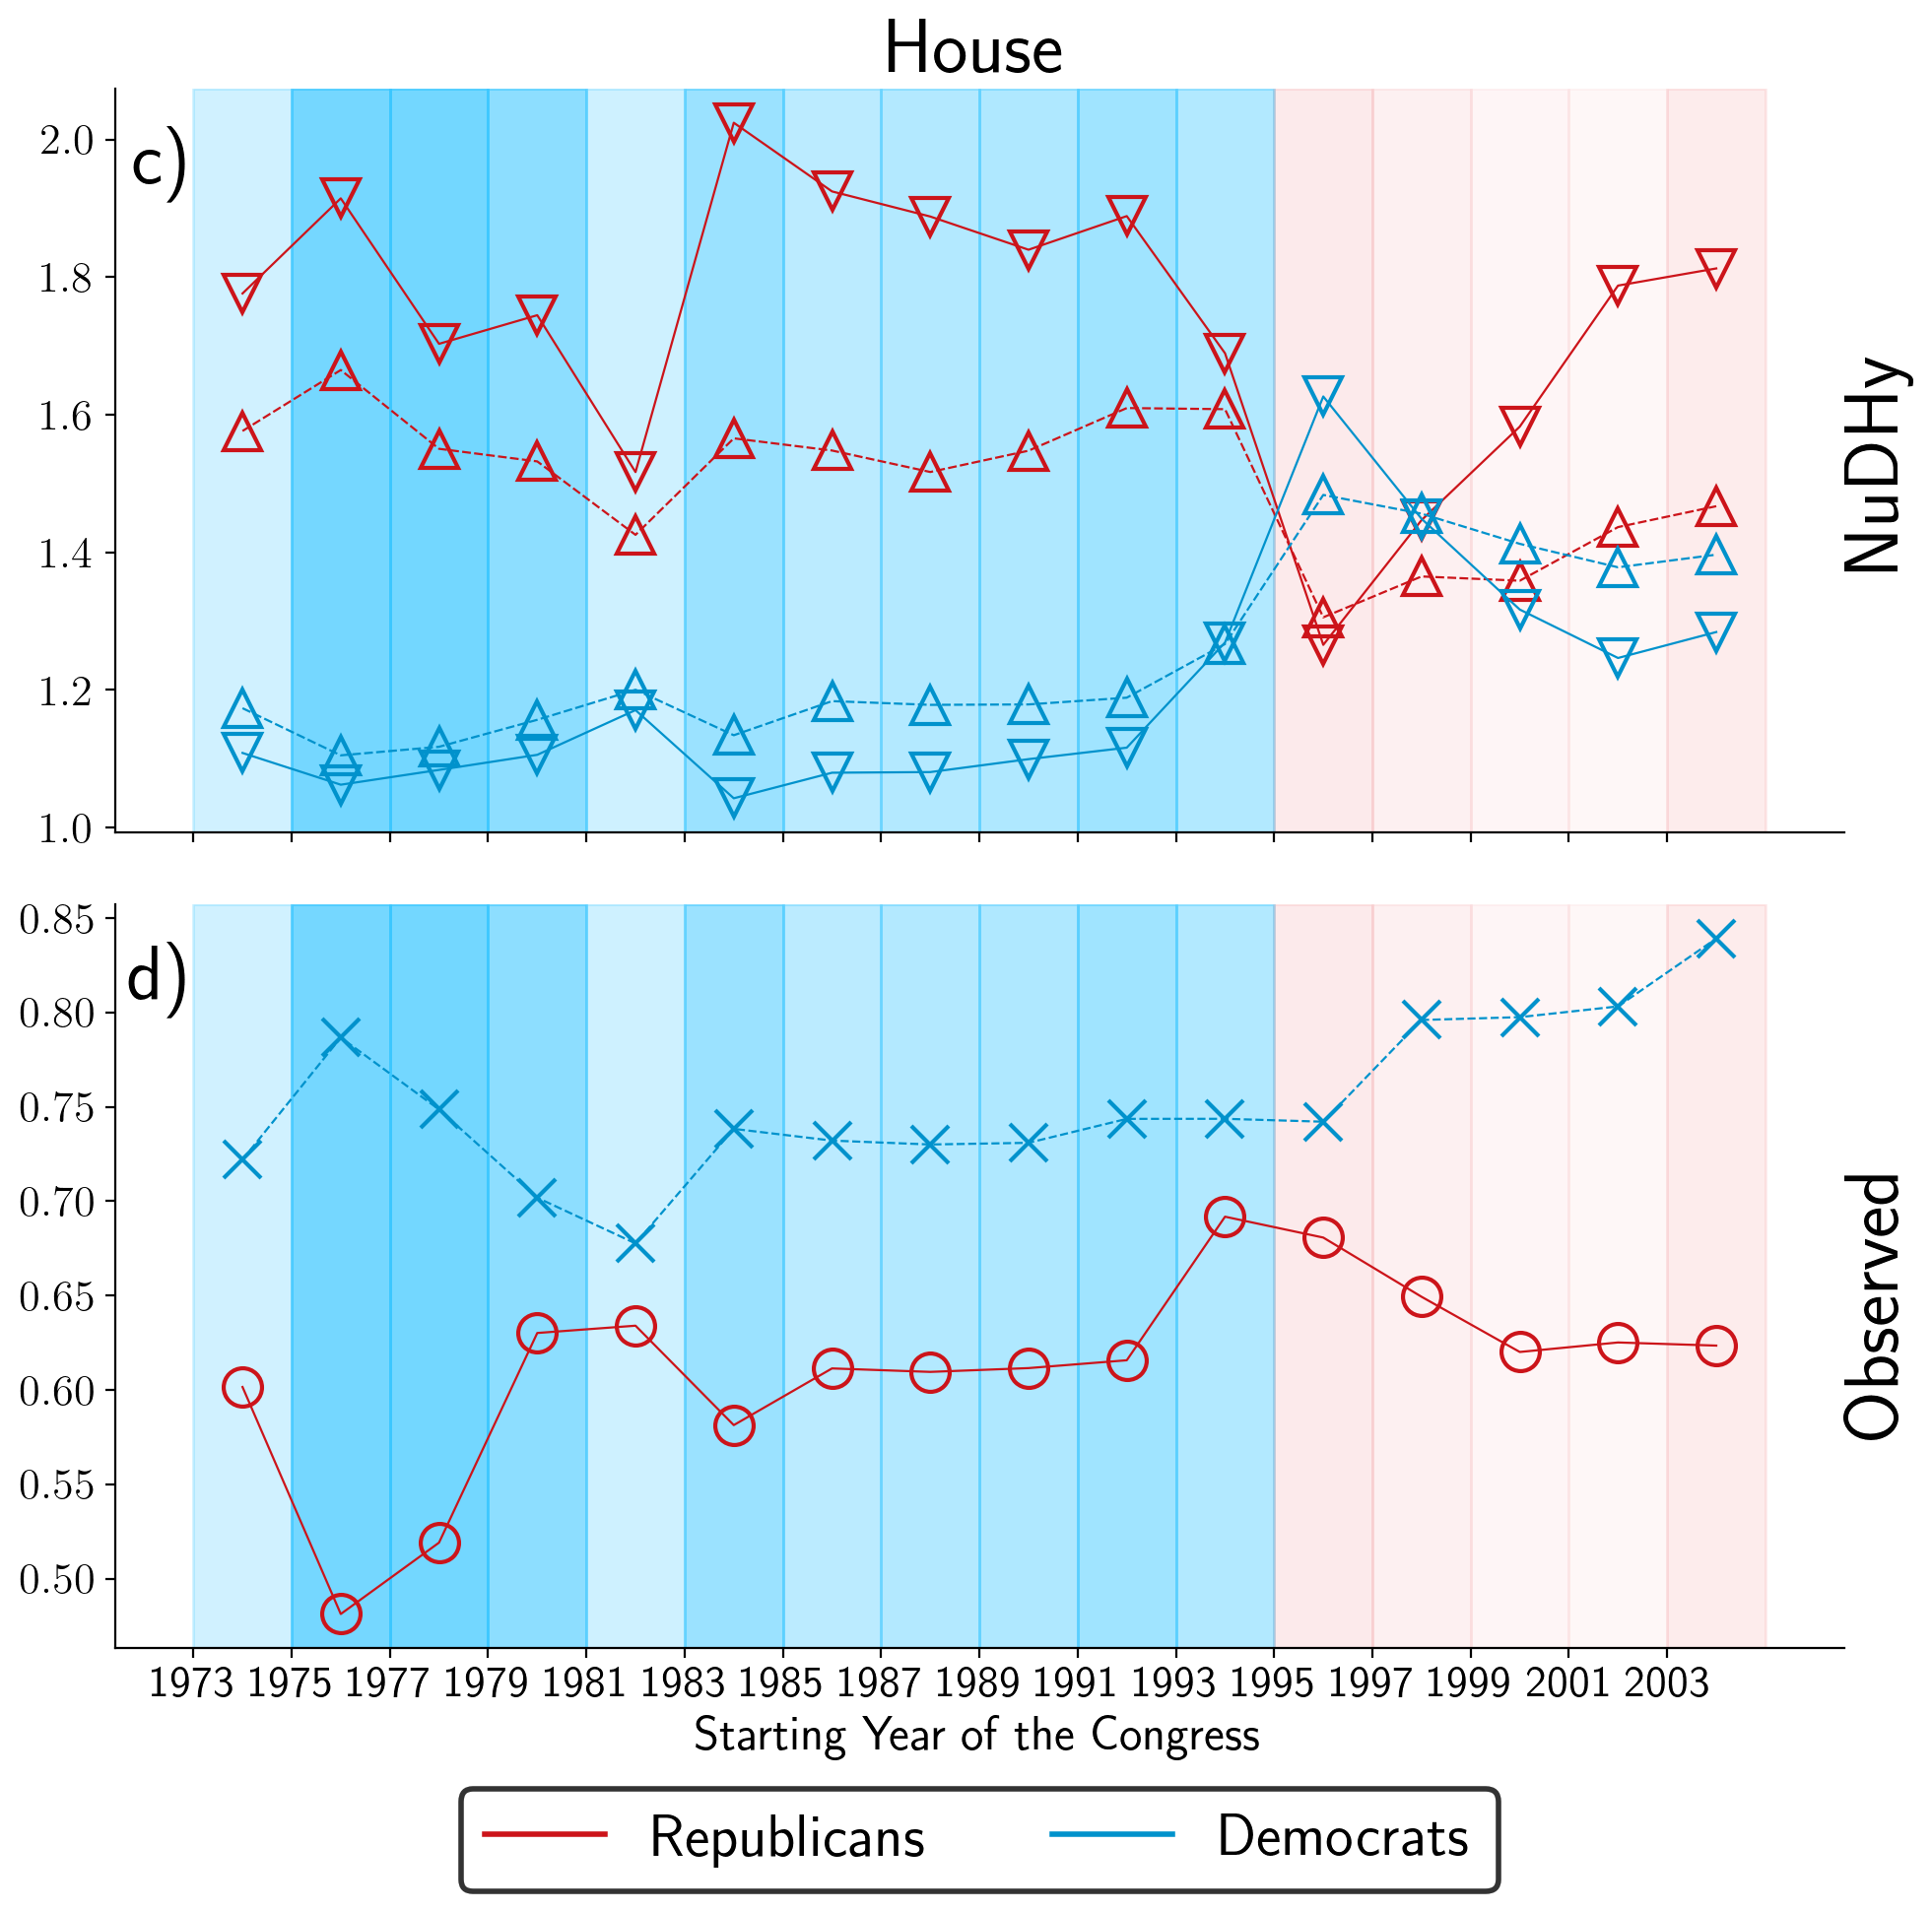

In [1024]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# NUDHY
data = df_plot_ratio.rename(columns={'Baseline Score': 'Sampler'})
data['Sampler'] = data['Sampler'].apply(lambda x: sampler_names.get(x, x))
data['Starting Year'] = data['Congress'].apply(lambda x: congress_info.loc[x, 'Start']) + 1

plot = sns.lineplot(data=data, x='Starting Year', y='Homophily',  
                    palette=palette_congress[:2], hue='Party', 
                    hue_order=['Republicans', 'Democrats'],
                    markersize=14, linewidth=.8,
                    markerfacecolor='none', ax=ax[0],
                    markeredgewidth=1.5, style='Sampler', markers=['v', '^'])
for idx, line in enumerate(plot.lines):
    line.set_markeredgecolor(line.get_color())

ax[0].set_ylabel(r'Homophily $\mathsf{HO}(X)$')
ax[0].set_title(title, fontsize=28)
ax[0].text(0.045, .95, p_nums[0], ha='right', va='top',
           transform=ax[0].transAxes, color='black', fontsize=28)
if house == 'H':
    ax[0].text(1.04, .65, 'NuDHy', ha='right', va='top', rotation=90,
               transform=ax[0].transAxes, color='black', fontsize=28)
    ax[0].set_ylabel('')

# NUDHY LEGEND
handles, labels = plot.get_legend_handles_labels()
for handle in handles:
    handle.set_markeredgecolor('black')
    handle.set_linewidth(2)
    
plot.legend().remove()

# COMMON LEGEND
hue_handles = handles[1:3]
hue_labels = labels[1:3]
sty_handles = handles[4:]
sty_labels = labels[4:]

# OBSERVED
data = df_plot_vals[df_plot_vals['Score']=='Obs. Dataset'].copy()
data['Starting Year'] = data['Congress'].apply(lambda x: congress_info.loc[x, 'Start']) + 1

for idx, party in enumerate(['Republicans', 'Democrats']):
    data_p = data[data['Party']==party]
    plot = sns.lineplot(data=data_p, x='Starting Year', y='Homophily', 
                        color=palette_congress[idx], linewidth=.8,
                        linestyle=styles[idx], markeredgecolor=palette_congress[idx], 
                        label=party, ax=ax[1],
                        markersize=14, marker=markers[idx], markerfacecolor='none', markeredgewidth=1.5)

ax[1].set_xlabel('Starting Year of the Congress')
ax[1].set_ylabel(r'$\mathsf{m}(X)$')
ax[1].text(0.045, .95, p_nums[1], ha='right', va='top',
           transform=ax[1].transAxes, color='black', fontsize=28)
if house == 'H':
    ax[1].text(1.04, .65, 'Observed', ha='right', va='top', rotation=90,
               transform=ax[1].transAxes, color='black', fontsize=28)
    ax[1].set_ylabel('')
    
# COMMON BACKGROUND
for c in c_inf.index:
    is_dem = c_inf.loc[c, 'Democrats'] >= c_inf.loc[c, 'Republicans']
    diff = np.abs(c_inf.loc[c, 'Democrats'] - c_inf.loc[c, 'Republicans']) / (c_inf.loc[c, 'Democrats'] + c_inf.loc[c, 'Republicans'])
    if is_dem:
        back = bk_cols[1]
    else:
        back = bk_cols[0]
    ax[0].axvspan(c, c+2, color=back, alpha=diff*2)
    ax[1].axvspan(c, c+2, color=back, alpha=diff*2)
ax[0].set_xticks(c_inf.index, c_inf.index)
ax[1].set_xticks(c_inf.index, c_inf.index)

# PLOT COMMON LEGEND
if house == 'H':
    hue_legend = plt.legend(hue_handles, hue_labels, ncols=2,
                            bbox_to_anchor=(0.5, -0.15), loc='upper center',
                            title='', fontsize=22)
    hue_legend.get_frame().set_edgecolor('black')
    hue_legend.get_frame().set_linewidth(2)
else:
    style_legend = plt.legend(sty_handles, sty_labels, ncols=3,
                              bbox_to_anchor=(0.5, -0.15), loc='upper center',
                              title='', fontsize=22)
    style_legend.get_frame().set_edgecolor('black')
    style_legend.get_frame().set_linewidth(2)

plt.tight_layout()
plt.savefig(f'congress_bills_homophily_vary_congress_{house}.pdf', bbox_inches='tight')
plt.show()

### Group Affinity

Baseline Score

In [880]:
def baseline_tail(x, numvxclass):
    # ways to choose alpha - 1 elements of class X
    if numvxclass[x[0]] == 0:
        return 0
    A = math.comb(int(numvxclass[x[0]] - 1), x[2] - 1)
    # ways to choose t - alpha - 1 elements of class different from X 
    # (we exclude the vertex in the head because we do not care about its class)
    B = 1
    if x[1] - x[2] - 1 > 0:
        B = math.comb(int(np.sum(numvxclass) - numvxclass[x[0]]), x[1] - x[2] - 1)
    # ways to choose t - 2 elements of any class
    # (we exclude the vertex in the head because we do not care about its class)
    C = math.comb(int(np.sum(numvxclass) - 1), x[1] - 2)
    return A * B / C

In [881]:
def baseline_head(x, numvxclass):
    # ways to choose 1 element of class X
    A = numvxclass[x[0]]
    # ways to choose 1 element of any class
    C = np.sum(numvxclass)
    return A / C

In [882]:
def baseline(x, numvxclass):
    if x[3] == 'head':
        return baseline_head(x, numvxclass)
    return baseline_tail(x, numvxclass)

In [883]:
aff_obs_per_congr['Veldt et al.'] = aff_obs_per_congr.apply(lambda x: baseline(x, num_v_per_class_per_congr[x[5]]), axis=1)
aff_obs_per_congr['Affinity Ratio'] = aff_obs_per_congr['Affinity'] / aff_obs_per_congr['Veldt et al.']
aff_obs_per_congr['Party'] = aff_obs_per_congr['Class'].apply(lambda x : class_map[x])

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_71502/4270147635.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aff_obs_per_congr['Veldt et al.'] = aff_obs_per_congr.apply(lambda x: baseline(x, num_v_per_class_per_congr[x[5]]), axis=1)
/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_71502/2962548876.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[3] == 'head':
/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_71502/65399298.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

In [884]:
aff_obs_per_congr = aff_obs_per_congr[aff_obs_per_congr['Hyperedge Size'] > aff_obs_per_congr['Alpha']]
aff_per_congr = aff_per_congr[aff_per_congr['Hyperedge Size'] > aff_per_congr['Alpha']]

In [885]:
aff_obs_per_congr.fillna(0, inplace=True)

In [886]:
all_aff_per_congr = aff_per_congr[['Sampler', 
                                   'Class',
                                   'Hyperedge Size',
                                   'Alpha',
                                   'Type',
                                   'Affinity Ratio',
                                   'Party',
                                   'Congress']].copy()
all_aff_per_congr.rename(columns={'Sampler': 'Baseline Score'}, inplace=True)
tmp = aff_obs_per_congr[['Class', 
                         'Hyperedge Size', 
                         'Alpha', 
                         'Type', 
                         'Affinity Ratio',
                         'Party',
                         'Congress']].copy()
tmp['Baseline Score'] = 'Veldt et al.'
all_aff_per_congr = pd.concat([all_aff_per_congr, tmp])

In [887]:
all_aff_per_congr.sort_values(by=['Baseline Score'], inplace=True)

#### Head Affinity

#### Average Head Affinity

In [888]:
avg_aff_per_congress = all_aff_per_congr[all_aff_per_congr['Type']=='head'].copy()
avg_aff_per_congress = avg_aff_per_congress.groupby(by=['Baseline Score',
                                                        'Party',
                                                        'Congress'])[['Affinity Ratio']].mean()
avg_aff_per_congress = avg_aff_per_congress.reset_index()
avg_aff_per_congress = avg_aff_per_congress[avg_aff_per_congress['Party'].isin(['Democrats', 'Republicans'])]

In [889]:
avg_aff_per_congress['Starting Year'] = avg_aff_per_congress['Congress'].apply(lambda x: congress_info.loc[x, 'Start']) + 1

In [890]:
data1 = avg_aff_per_congress[avg_aff_per_congress['Baseline Score'].isin(['NuDHy_A', 'NuDHy_C'])].copy()
data2 = avg_aff_per_congress[~avg_aff_per_congress['Baseline Score'].isin(['NuDHy_A', 'NuDHy_C'])]

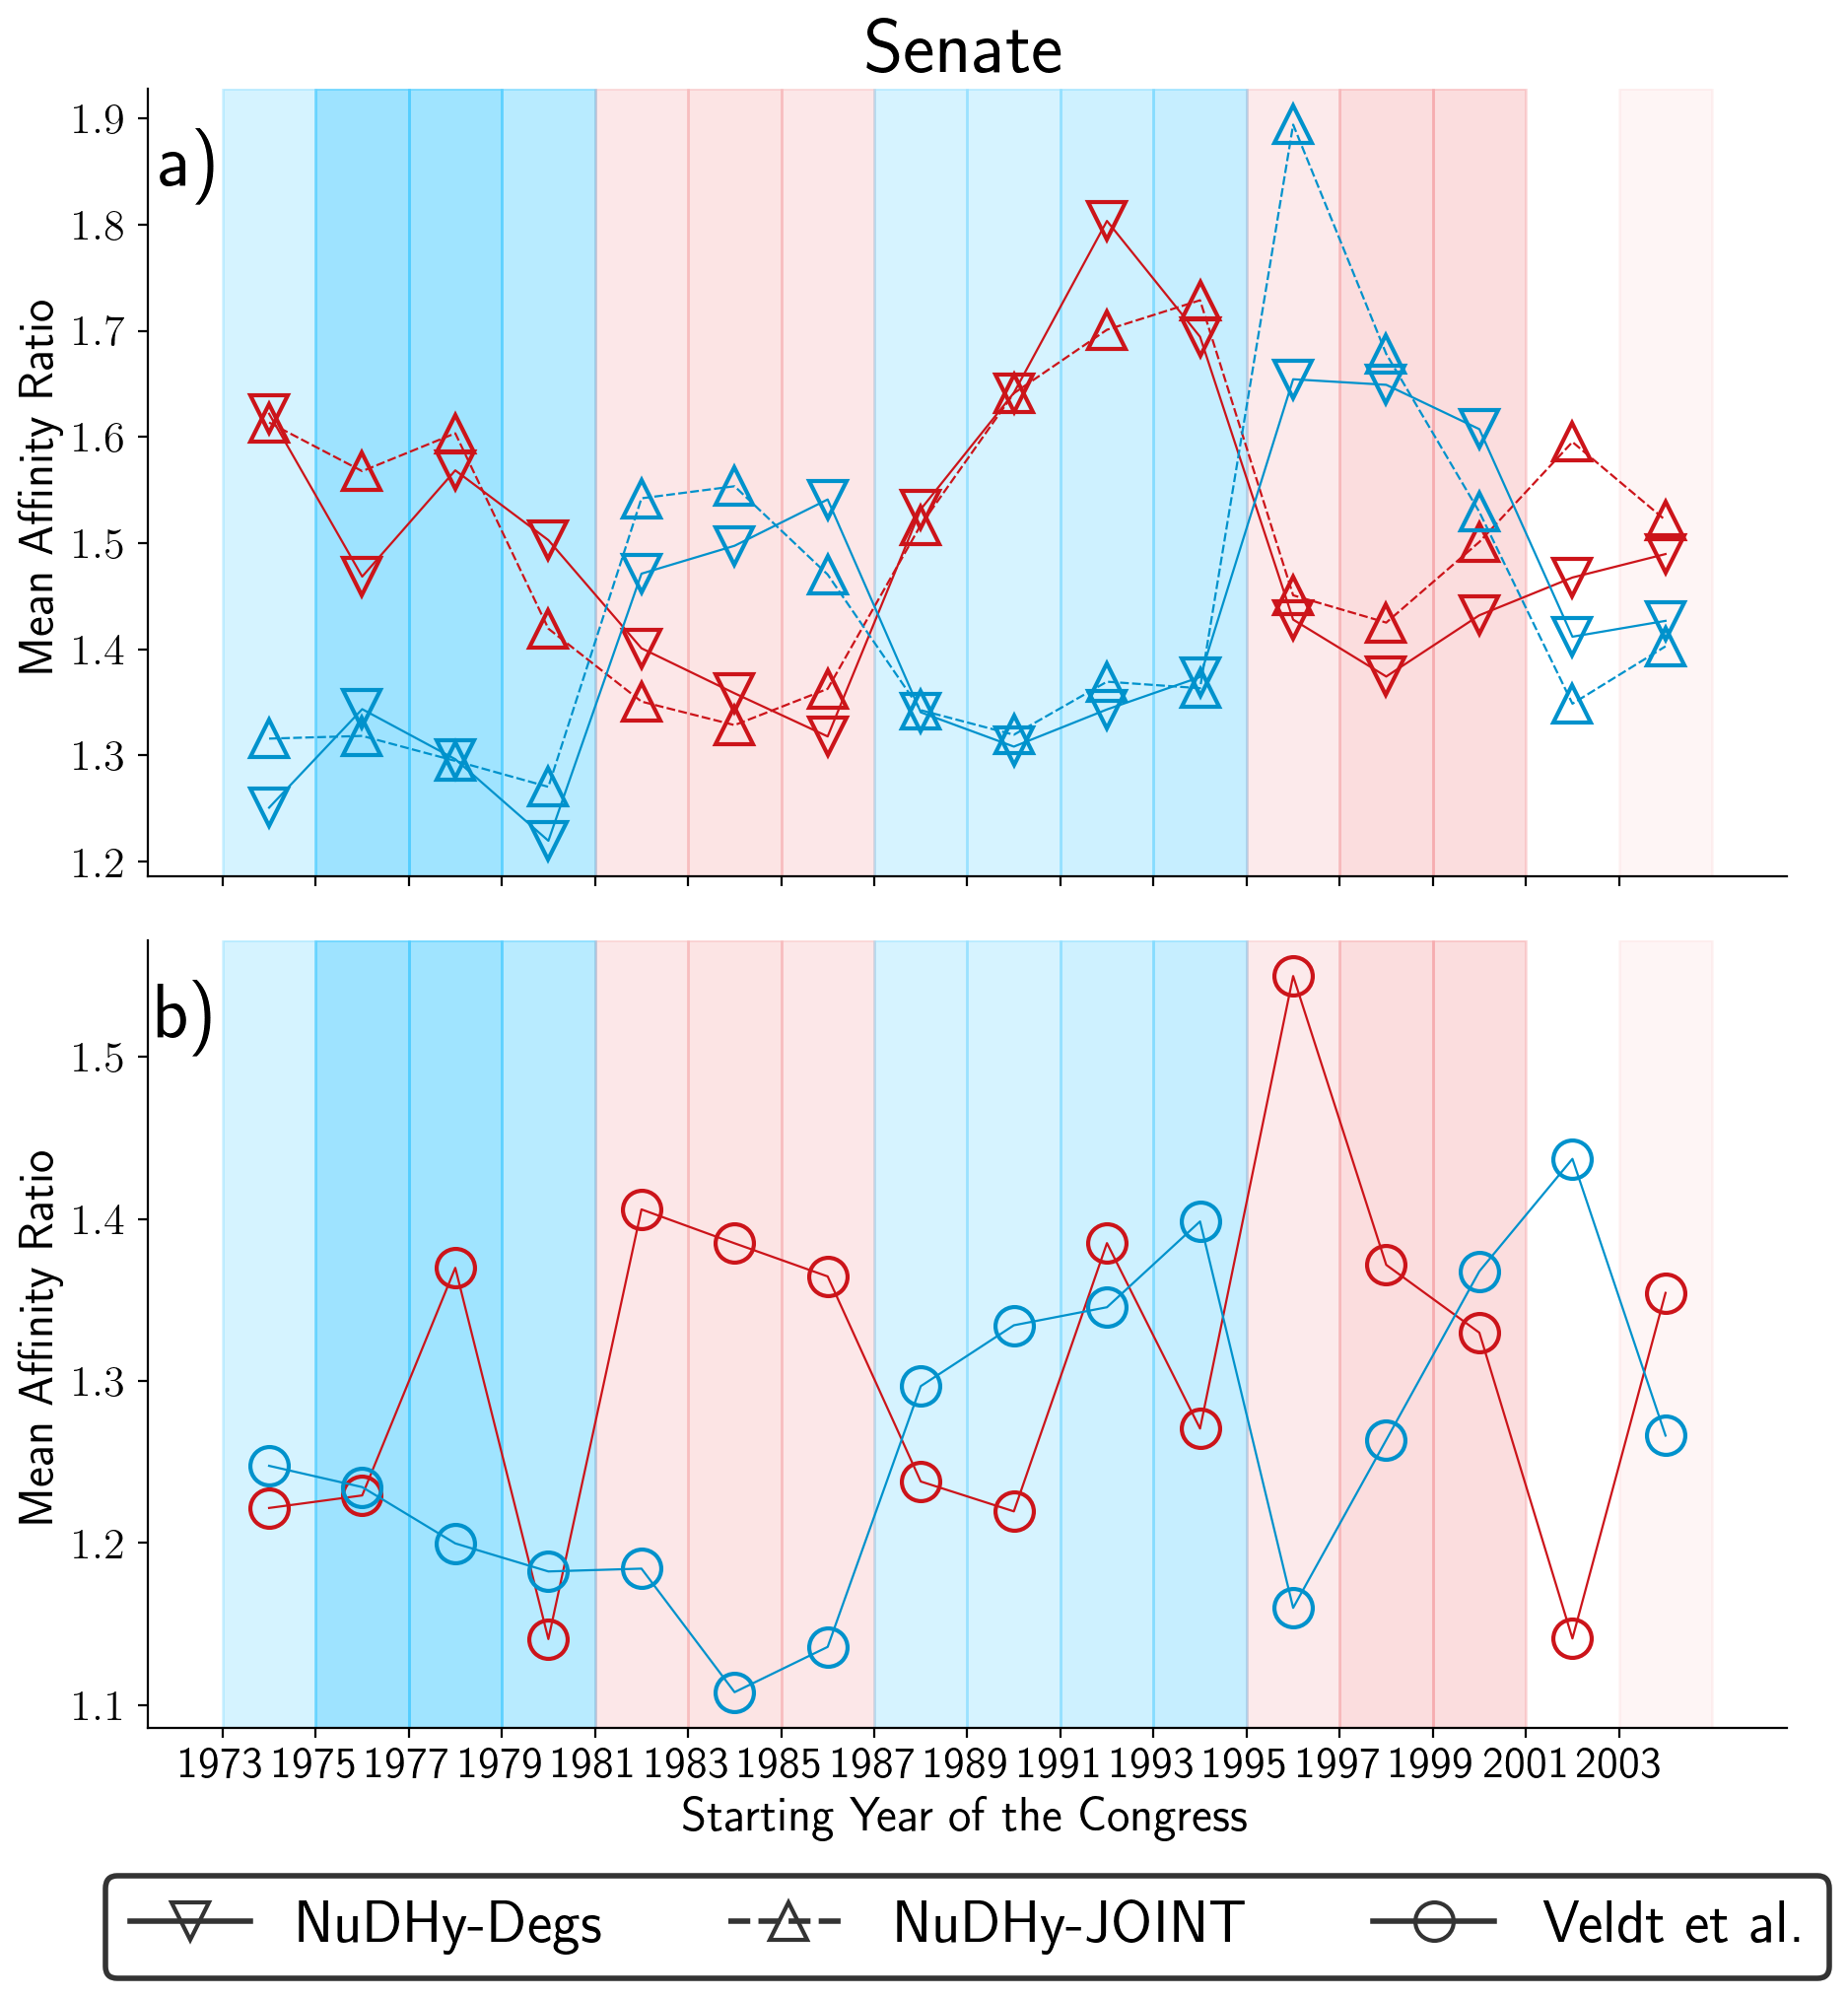

In [895]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

data1['Baseline Score'] = data1['Baseline Score'].apply(lambda x: sampler_names.get(x, x))

plot = sns.lineplot(data=data1, x='Starting Year', y='Affinity Ratio', 
                    palette=palette_congress[:2], hue='Party', ax=ax[0],
                    hue_order=['Republicans', 'Democrats'], linewidth=.8,
                    markerfacecolor='none', markeredgewidth=1.5,
                    markersize=14, style='Baseline Score', markers=['v', '^'])

ax[0].set_ylabel('Mean Affinity Ratio')
ax[0].set_title(title, fontsize=28)

ax[0].text(0.045, .95, p_nums[0], ha='right', va='top',
           transform=ax[0].transAxes, color='black', fontsize=28)
if house == 'H':
    ax[0].text(1.04, .65, 'NuDHy', ha='right', va='top', rotation=90,
               transform=ax[0].transAxes, color='black', fontsize=28)
    ax[0].set_ylabel('')

handles, labels = plot.get_legend_handles_labels()
for handle in handles:
    handle.set_markeredgecolor('black')
    handle.set_linewidth(2)

hue_handles = handles[1:3]
hue_labels = labels[1:3]
sty_handles = handles[4:]
sty_labels = labels[4:]

plot.legend().remove()

for idx, line in enumerate(plot.lines):
    line.set_markeredgecolor(line.get_color())

for c in c_inf.index:
    is_dem = c_inf.loc[c, 'Democrats'] >= c_inf.loc[c, 'Republicans']
    diff = np.abs(c_inf.loc[c, 'Democrats'] - c_inf.loc[c, 'Republicans']) / (c_inf.loc[c, 'Democrats'] + c_inf.loc[c, 'Republicans'])
    if is_dem:
        back = bk_cols[1]
    else:
        back = bk_cols[0]
    ax[0].axvspan(c, c+2, color=back, alpha=diff*2)
    ax[1].axvspan(c, c+2, color=back, alpha=diff*2)
ax[0].set_xticks(c_inf.index, c_inf.index)

plot = sns.lineplot(data=data2, x='Starting Year', y='Affinity Ratio', 
                    palette=palette_congress[:2], hue='Party', ax=ax[1],
                    hue_order=['Republicans', 'Democrats'], linewidth=.8,
                    markerfacecolor='none', markeredgewidth=1.5,
                    markersize=14, style='Baseline Score', markers=['o'])

ax[1].set_ylabel('Mean Affinity Ratio')
ax[1].set_xlabel('Starting Year of the Congress')

ax[1].text(0.045, .95, p_nums[1], ha='right', va='top',
           transform=ax[1].transAxes, color='black', fontsize=28)
if house == 'H':
    ax[1].text(1.04, .65, 'Baseline', ha='right', va='top', rotation=90,
               transform=ax[1].transAxes, color='black', fontsize=28)
    ax[1].set_ylabel('')

handles, labels = plot.get_legend_handles_labels()
for handle in handles:
    handle.set_markeredgecolor('black')
    handle.set_linewidth(2)
plot.legend(handles=handles, labels=labels, loc=(1.08, 0), markerscale=1)

for idx, line in enumerate(plot.lines):
    line.set_markeredgecolor(line.get_color())

ax[1].set_xticks(c_inf.index, c_inf.index)

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

sty_handles.extend(handles[4:])
sty_labels.extend(labels[4:])

if house == 'H':
    hue_legend = plt.legend(hue_handles, hue_labels, ncols=2,
                            bbox_to_anchor=(0.5, -0.15), loc='upper center',
                            title='', fontsize=22)
    hue_legend.get_frame().set_edgecolor('black')
    hue_legend.get_frame().set_linewidth(2)
else:
    style_legend = plt.legend(sty_handles, sty_labels, ncols=3,
                              bbox_to_anchor=(0.5, -0.15), loc='upper center',
                              title='', fontsize=22)
    style_legend.get_frame().set_edgecolor('black')
    style_legend.get_frame().set_linewidth(2)

plt.tight_layout()
plt.savefig(f'congress_bills_head_affinity_vary_congress_{house}.pdf', bbox_inches='tight')
plt.show()

## DBLP 

In [128]:
root = 'dblp_v9_rest'

In [129]:
vmap = defaultdict(int)
with open(f'{data_path}{root}.tsv') as in_f:
    heads, tails = read_as_directed_hyperedge_list(in_f, vmap)
    
with open(f'{data_path}{root}_classes.tsv') as in_f:
    classes = read_classes(in_f, vmap)

In [130]:
num_v_per_class = np.zeros(5)
for v, c in classes.items():
    num_v_per_class[c] += 1

In [131]:
class_map = {0: 'Males',
             1: 'Unknown',
             2: 'Females'}

In [132]:
palette_dblp = ["#E462A1", # females
                "#008AB8" #men
               ]

Data

In [133]:
aff_samples = pd.read_csv(met_path + f"affinity_{root}_samples.tsv", sep='\t')
aff = pd.read_csv(met_path + f"affinity_{root}.tsv", sep='\t')

In [134]:
avg_aff = aff_samples.groupby(by=['Sampler',
                                  'Class',
                                  'Hyperedge Size',
                                  'Alpha',
                                  'Beta',
                                  'Type']).agg({'Affinity': 'mean'}).reset_index()

In [135]:
aff_ = aff.rename(columns={'Affinity': 'Aff'})
avg_aff = pd.merge(avg_aff, aff_, how='left', on=['Class', 'Hyperedge Size', 'Alpha', 'Beta', 'Type'])
avg_aff.dropna(inplace=True)

In [136]:
avg_aff['Affinity Ratio'] = avg_aff['Aff'] / avg_aff['Affinity']
avg_aff['Gender'] = avg_aff['Class'].apply(lambda x : class_map[x])
aff['Gender'] = aff['Class'].apply(lambda x : class_map[x])

In [137]:
avg_aff = avg_aff[avg_aff['Gender'] != 'Unknown']
aff = aff[aff['Gender'] != 'Unknown']

In [138]:
avg_aff.fillna(0, inplace=True)

In [139]:
avg_aff = avg_aff[avg_aff['Hyperedge Size'] > avg_aff['Beta']]
aff = aff[aff['Hyperedge Size'] > aff['Beta']]

Baseline

In [140]:
def baseline_head(x):
    # x = [class=0, size=1, a=2, h_size=3]
    
    num_x = int(num_v_per_class[x[0]])
    n = int(np.sum(num_v_per_class))
    
    A = math.comb(num_x, x[2])
    B = math.comb(n - num_x, x[3]-x[2])
#     C = math.comb(n - 1, x[1]-x[3]-1)
    
    D = math.comb(n, x[3])
#     E = math.comb(n - 1, x[1]-x[3]-1)

#     return (A * B * C) / (D * E)
    return (A * B) / D

In [141]:
def baseline_tail(x):
    # x = [class=0, size=1, a=2, h_size=3]
    num_x = int(num_v_per_class[x[0]])
    n = int(np.sum(num_v_per_class))
    
    A = math.comb(n - 1, x[3] - 1)
    B = math.comb(num_x, x[2])
    C = math.comb(n - num_x, x[1]-x[2]-x[3])
    
    D = math.comb(n - 1, x[3] - 1)
    E = math.comb(n, x[1]-x[3])

    return (A * B * C) / (D * E)

In [142]:
def baseline(x):
    if x[4] == 'head':
        return baseline_head(x)
    return baseline_tail(x)

In [143]:
aff['Veldt et al.'] = aff.apply(lambda x: baseline(x), axis=1)
aff['Affinity Ratio'] = aff['Affinity'] / aff['Veldt et al.']

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_71502/338443215.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[4] == 'head':
/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_71502/2676443789.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_x = int(num_v_per_class[x[0]])
/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_71502/2676443789.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 

In [144]:
aff.fillna(0, inplace=True)

In [145]:
all_aff = avg_aff[['Sampler', 
                   'Class',
                   'Hyperedge Size',
                   'Alpha',
                   'Beta',
                   'Type',
                   'Affinity Ratio',
                   'Gender']].copy()
all_aff.rename(columns={'Sampler': 'Baseline Score'}, inplace=True)
tmp = aff[['Class', 'Hyperedge Size', 
           'Alpha', 'Beta', 'Type', 'Affinity Ratio',
           'Gender']].copy()
tmp['Baseline Score'] = 'Veldt et al.'
all_aff = pd.concat([all_aff, tmp])

In [146]:
all_aff['Combo'] = "(" + all_aff['Beta'].apply(str) + "," + all_aff['Alpha'].apply(str) + ")"
all_aff.sort_values(by=['Combo', 'Baseline Score'], inplace=True)

### Head Affinity

### Average Head Affinity

In [147]:
avg_aff_per_gender = all_aff[all_aff['Type']=='head'].copy()
avg_aff_per_gender = avg_aff_per_gender.groupby(by=['Baseline Score',
                                                    'Alpha',
                                                    'Gender'])[['Affinity Ratio']].mean()
avg_aff_per_gender = avg_aff_per_gender.reset_index()

In [148]:
avg_aff_per_gender = avg_aff_per_gender[avg_aff_per_gender['Affinity Ratio']>0]

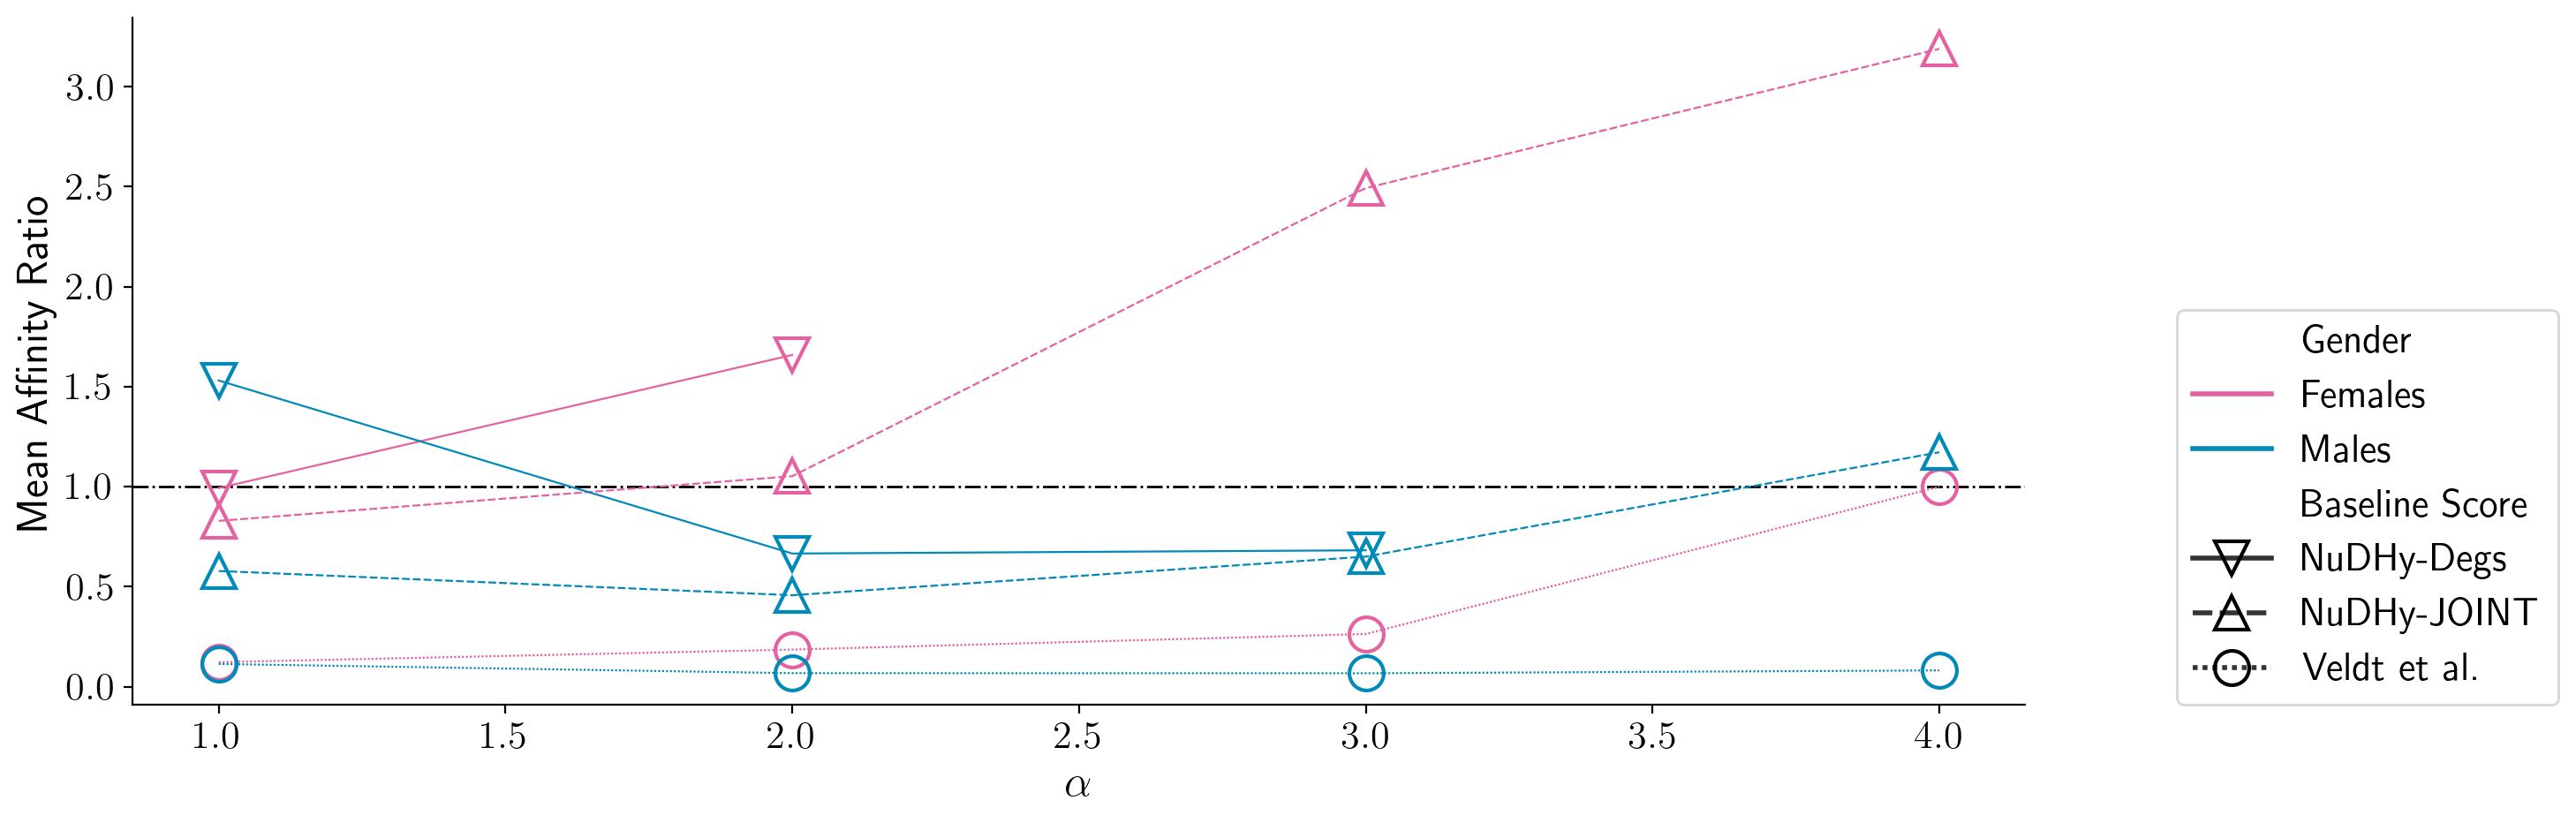

In [149]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.axhline(1, color='black', linewidth=1, linestyle='-.')

data = avg_aff_per_gender[avg_aff_per_gender['Alpha']<5].copy()
data['Baseline Score'] = data['Baseline Score'].apply(lambda x: sampler_names.get(x, x))
plot = sns.lineplot(data=data, x='Alpha', y='Affinity Ratio', markers=['v', '^', 'o'],
                    linewidth=.8, markerfacecolor='none', markeredgewidth=1.5,
                    markersize=14, palette=palette_dblp, hue_order=['Females', 'Males'],
                    hue='Gender', style='Baseline Score', ax=ax)

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Mean Affinity Ratio')

handles, labels = plot.get_legend_handles_labels()
for handle in handles:
    handle.set_markeredgecolor('black')
    handle.set_linewidth(2)
plot.legend(handles=handles, labels=labels, loc=(1.08, 0), markerscale=1)

for idx, line in enumerate(plot.lines):
    line.set_markeredgecolor(line.get_color())

plt.tight_layout()
plt.savefig(f'{root}_head_affinity_size.pdf', bbox_inches='tight')
plt.show()

# Non-linear Contagion Processes

Style

In [242]:
ame_c = '#433E3F'
or_c = '#369683'
na_cs = ['#5544DA', '#C80421']

In [243]:
sam_new_names = ['Degs', 'BIOT']

Params

In [244]:
rho_0 = 0.01
dt = 10000
quasi = True

In [245]:
exps = {
    'lyon': [1, 4],
    'high' : [1, 4],
    'email-Eu': [1, 3],
    'email-Enron': [1, 3]
}

Dataset

In [246]:
met_path = results_path + 'nl_contagion/'
roots = ['lyon', 'high', 'email-Eu', 'email-Enron']

AME

In [247]:
all_ames = dict()

In [248]:
for root in roots:
    exp0 = exps[root][0]
    exp1 = exps[root][1]
    f_lb_shape_inf = f'{root}_exp{exp0}_ame.pk'
    f_ub_shape_inf = f'{root}_exp{exp1}_ame.pk'
    with open(met_path+f_lb_shape_inf, 'rb') as in_f:
        lb_shape_inf = pickle.load(in_f)
    with open(met_path+f_ub_shape_inf, 'rb') as in_f:
        ub_shape_inf = pickle.load(in_f)
    all_ames[root] = [lb_shape_inf, ub_shape_inf]

OBSERVED

In [249]:
all_obs = dict()

In [250]:
for root in roots:
    obs_r = pd.read_csv(met_path+f'rhos_{root}_dt{dt}_q{quasi}.tsv', sep='\t')
#     obs_marg = pd.read_csv(met_path+f'I_prob_{root}_dt{dt}_q{quasi}.tsv', sep='\t')
    mean_obs = obs_r.groupby(by=['Lambda', 'Shape Infection', 'Initial Density Infected',
                                 'Quasi']).agg({'Num Infected': ['mean', 'std']}).reset_index()
    mean_obs.columns.droplevel(0)
    mean_obs.columns = ['Lambda', 'Shape Infection', 'Initial Density Infected',
                        'Quasi', 'Mean Num Infected', 'STD Num Infected']
    all_obs[root] = mean_obs

SAMPLES

In [251]:
all_nudhy = dict()

In [252]:
for root in roots:
    samples_r = pd.read_csv(met_path+f'rhos_{root}_samples_nudhy_dt{dt}_q{quasi}.tsv', sep='\t')
    samples_marg = pd.read_csv(met_path+f'I_prob_{root}_samples_nudhy_dt{dt}_q{quasi}.tsv', sep='\t')
    mean_samp = samples_r.groupby(by=['Lambda', 'Shape Infection', 'Initial Density Infected', 'Sampler',
                                      'Quasi']).agg({'Num Infected': ['mean', 'std']}).reset_index()
    mean_samp.columns.droplevel(0)
    mean_samp.columns = ['Lambda', 'Shape Infection', 'Initial Density Infected',
                         'Sampler', 'Quasi', 'Mean Num Infected', 'STD Num Infected']
    all_nudhy[root] = mean_samp

## Plot Simulations

In [253]:
plot_nums = ['a)', 'b)', 'c)', 'd)']

In [254]:
marker_list = ['.', 'x', '+']
# marker_list = ['o', '1', '2']
cap_list = ['projecting', 'butt', 'round']
lwidth = 0
msize_list = [8, 9, 8]

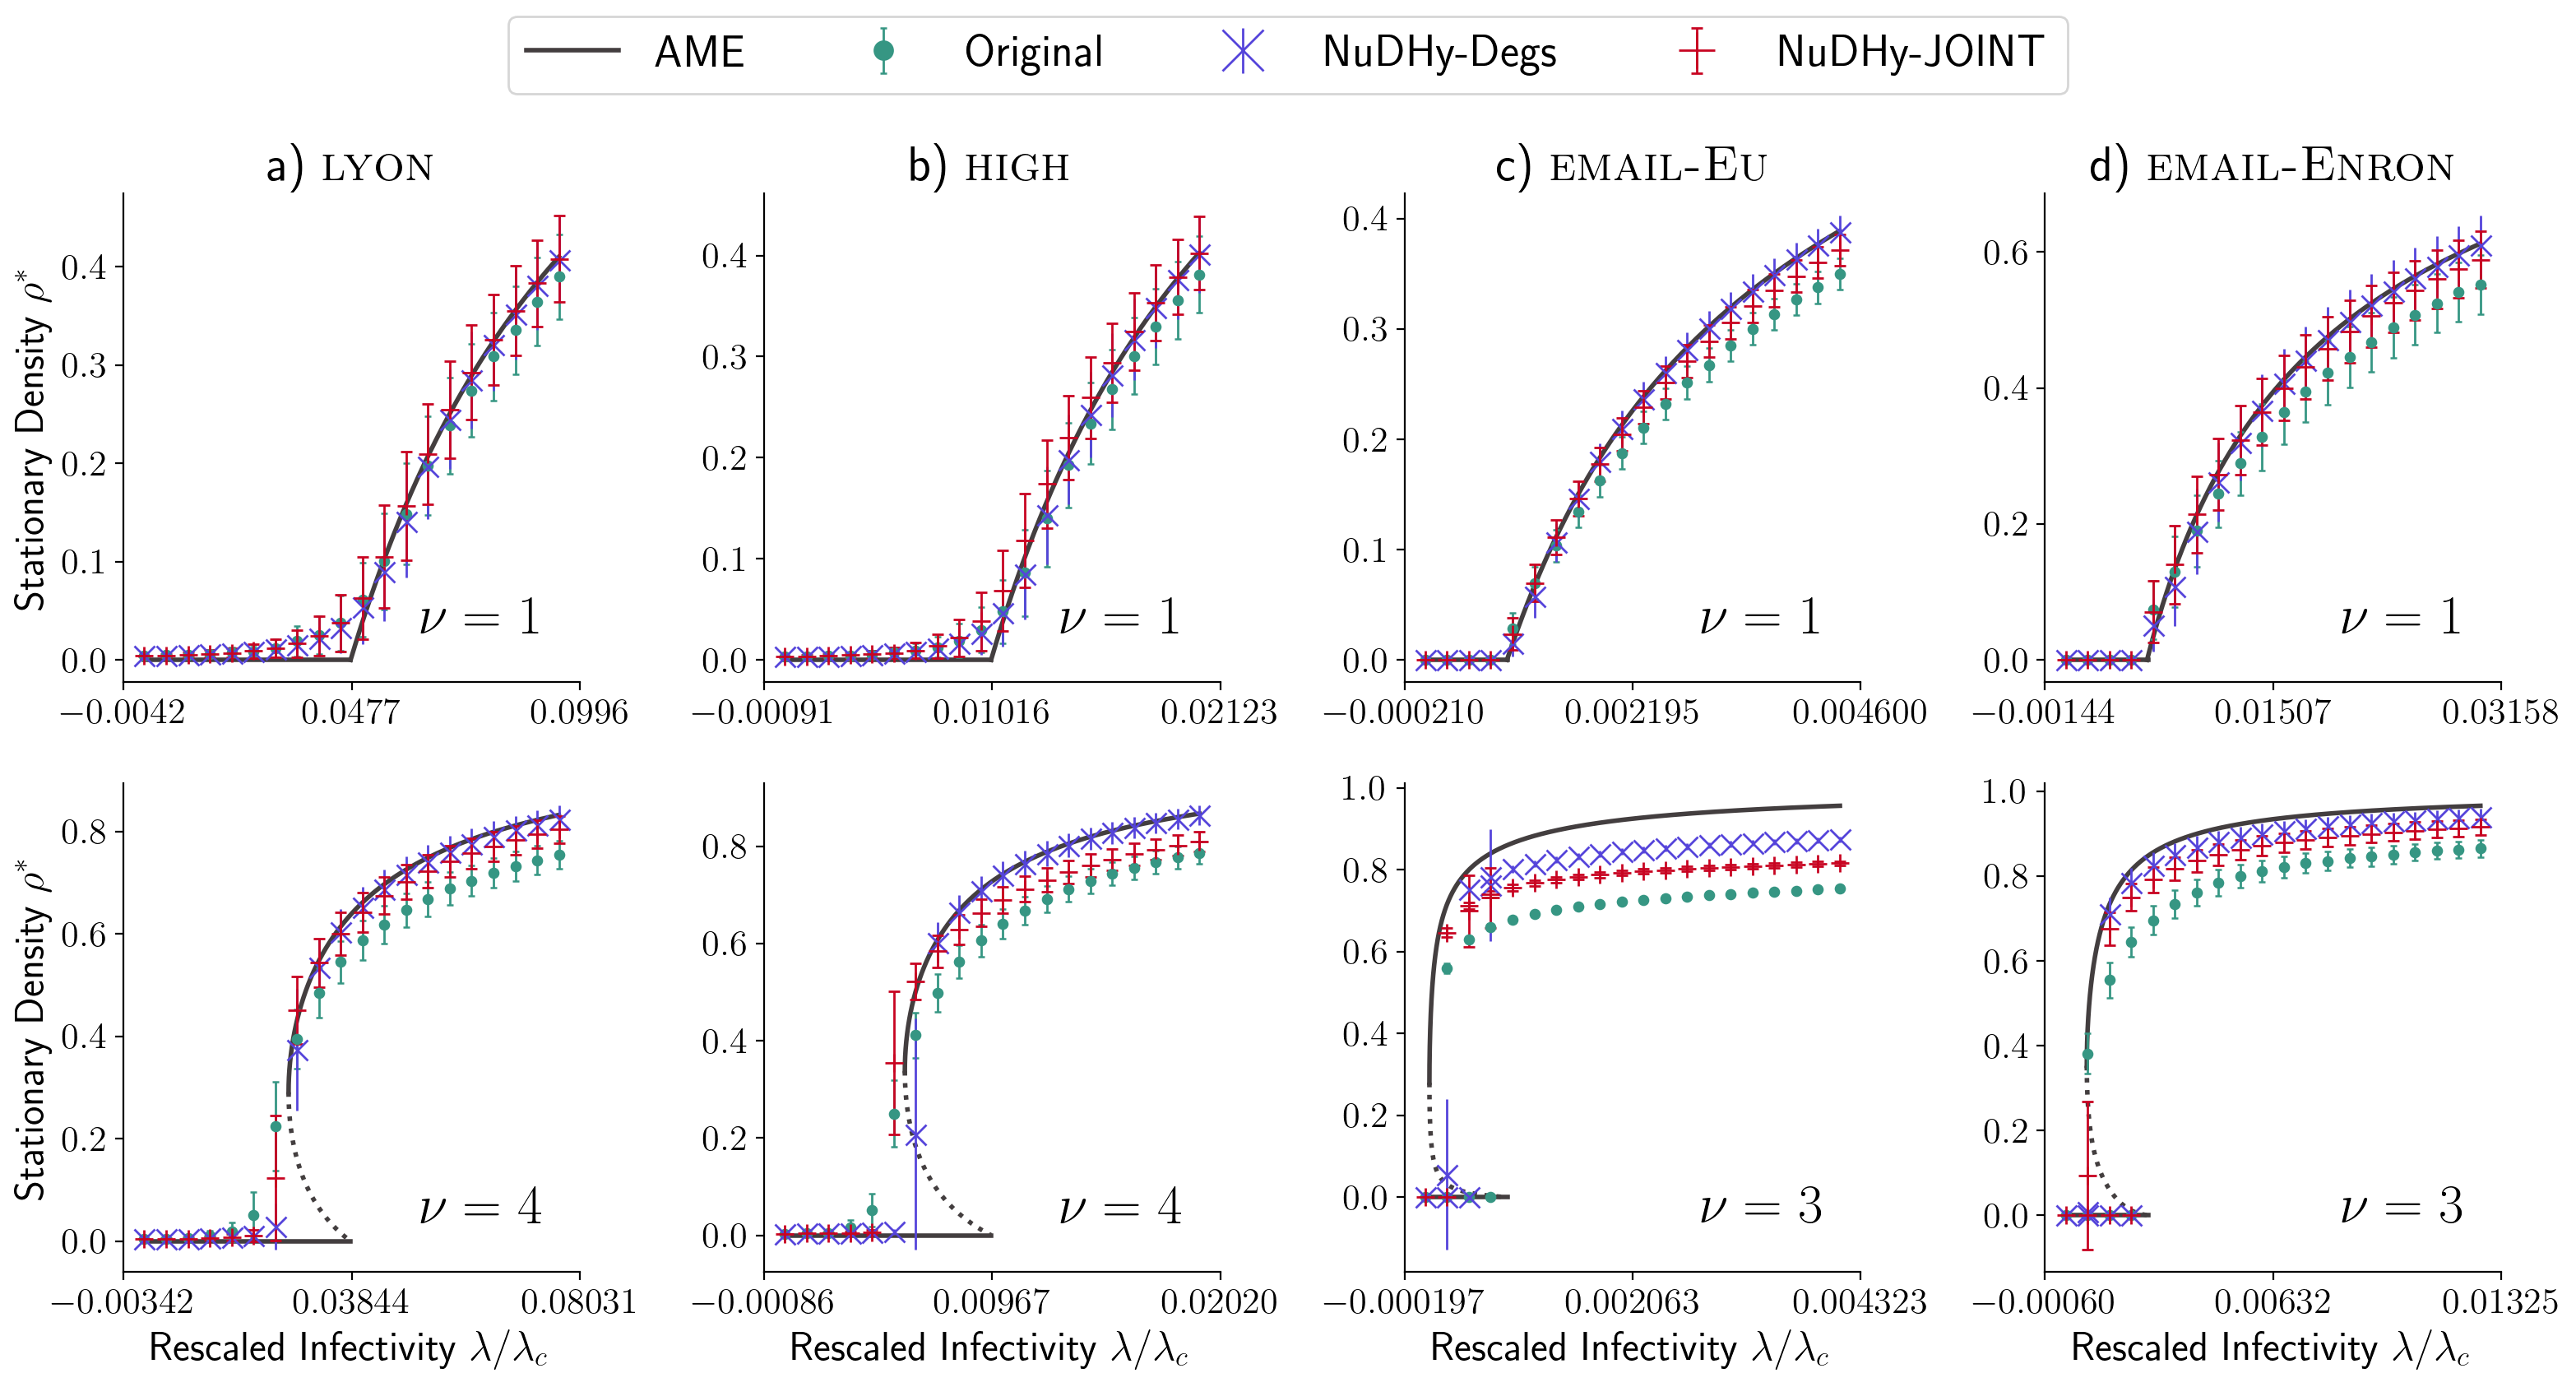

In [255]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for did, root in enumerate(roots):
    
    exp0 = exps[root][0]
    exp1 = exps[root][1]
    
    mean_obs = all_obs[root]
    mean_samp = all_nudhy[root]
    
    plot_num = plot_nums[did]
    
    for idx, exp in enumerate([exp0, exp1]):
        
        # AME
        ame = all_ames[root][idx]

        p1 = ax[idx][did].plot(ame['param_list_upper'], ame['I_list_upper'], 
                               linewidth=2, color=ame_c, label='AME')
        ax[idx][did].plot(ame['param_list_lower'], ame['I_list_lower'], 
                          linewidth=2, color=ame_c)
        if 'param_list_unstable' in ame:
            ax[idx][did].plot(ame['param_list_unstable'], ame['I_list_unstable'], 
                              linewidth=2, linestyle=':', color=ame_c)

        # OBSERVED
        if len(mean_obs['Quasi'].unique()) == 1:
            dat = mean_obs[(mean_obs['Shape Infection']==exp) &
                           (mean_obs['Initial Density Infected']==rho_0)]

            p2 = ax[idx][did].errorbar(dat['Lambda'], dat['Mean Num Infected'], dat['STD Num Infected'],
                                       color=or_c, linewidth=lwidth, label='Original',
                                       marker=marker_list[0], markersize=msize_list[0],
                                       markeredgecolor=or_c, markeredgewidth=.9, 
#                                        markerfacecolor='none',
                                       capsize=1.5, capthick=2, elinewidth=1, dash_capstyle=cap_list[0])
        else:
            dat = mean_obs[(mean_obs['Shape Infection']==exp) &
                           (mean_obs['Initial Density Infected']==rho_0) &
                           (mean_obs['Quasi']==True) & 
                           (mean_obs['Lambda'] >= min(ame['param_list_upper']))]
            ax[idx][did].errorbar(dat['Lambda'], dat['Mean Num Infected'], dat['STD Num Infected'],
                                  color=or_c, linewidth=lwidth,
                                  marker=marker_list[0], markersize=msize_list[0],
                                  markeredgecolor=or_c, markeredgewidth=.9, 
#                                   markerfacecolor='none',
                                  capsize=1.5, capthick=2, elinewidth=1, dash_capstyle=cap_list[0])

            dat = mean_obs[(mean_obs['Shape Infection']==exp) &
                           (mean_obs['Initial Density Infected']==rho_0) &
                           (mean_obs['Quasi']==False) & 
                           (mean_obs['Lambda'] <= max(ame['param_list_lower']))]
            p2 = ax[idx][did].errorbar(dat['Lambda'], dat['Mean Num Infected'], dat['STD Num Infected'],
                                       color=or_c, linewidth=lwidth, label='Original',
                                       marker=marker_list[0], markersize=msize_list[0],
                                       markeredgecolor=or_c, markeredgewidth=.9, 
#                                        markerfacecolor='none',
                                       capsize=1.5, capthick=2, elinewidth=1, dash_capstyle=cap_list[0])

        # NUDHY
        n_handles = []
        for ids, sam in enumerate(['A', 'C']):

            name2 = sampler_names.get(f'NuDHy_{sam}')

            if len(mean_samp['Quasi'].unique()) == 1:

                data2 = mean_samp[(mean_samp['Shape Infection']==exp) &
                                  (mean_samp['Initial Density Infected']==rho_0) &
                                  (mean_samp['Sampler'].isin([f'NuDHy_{sam}', 
                                                              f'NuDHy_{sam_new_names[ids]}']))]
                p3 = ax[idx][did].errorbar(data2['Lambda'], data2['Mean Num Infected'], 
                                           data2['STD Num Infected'],
                                           color=na_cs[ids], linewidth=lwidth, label=name2,
                                           marker=marker_list[1+ids], markersize=msize_list[1+ids],
                                           markeredgecolor=na_cs[ids], markeredgewidth=1, 
                                           markerfacecolor='none',
                                           capsize=ids*2.5, elinewidth=1, dash_capstyle=cap_list[1+ids])
            else:

                data2 = mean_samp[(mean_samp['Shape Infection']==exp) &
                                  (mean_samp['Initial Density Infected']==rho_0) &
                                  (mean_samp['Quasi']==True) &
                                  (mean_samp['Lambda'] >= min(ame['param_list_upper'])) &
                                  (mean_samp['Sampler'].isin([f'NuDHy_{sam}', 
                                                              f'NuDHy_{sam_new_names[ids]}']))]
                p3 = ax[idx][did].errorbar(data2['Lambda'], data2['Mean Num Infected'], 
                                           data2['STD Num Infected'],
                                           color=na_cs[ids], linewidth=lwidth, label=name2,
                                           marker=marker_list[1+ids], markersize=msize_list[1+ids],
                                           markeredgecolor=na_cs[ids], markeredgewidth=1, 
                                           markerfacecolor='none',
                                           capsize=ids*2.5, elinewidth=1, dash_capstyle=cap_list[1+ids])

                data2 = mean_samp[(mean_samp['Shape Infection']==exp) &
                                  (mean_samp['Initial Density Infected']==rho_0) &
                                  (mean_samp['Quasi']==False) &
                                  (mean_samp['Lambda'] <= max(ame['param_list_lower'])) &
                                  (mean_samp['Sampler'].isin([f'NuDHy_{sam}', 
                                                              f'NuDHy_{sam_new_names[ids]}']))]
                ax[idx][did].errorbar(data2['Lambda'], data2['Mean Num Infected'],
                                      data2['STD Num Infected'],
                                      color=na_cs[ids], linewidth=lwidth,
                                      marker=marker_list[1+ids], markersize=msize_list[1+ids],
                                      markeredgecolor=na_cs[ids], markeredgewidth=1, 
                                      markerfacecolor='none',
                                      capsize=ids*2.5, elinewidth=1, dash_capstyle=cap_list[1+ids])
            n_handles.append(p3)

        if did == 0:
            ax[idx][did].set_ylabel(r'Stationary Density $\rho^*$', fontsize=18)
        if idx == 0:
            ax[idx][did].set_xlabel('')
        else:
            ax[idx][did].set_xlabel(r'Rescaled Infectivity $\lambda/\lambda_c$', fontsize=18)
        ax[idx][did].text(0.65, 0.1, r'$\nu={}$'.format(exp), 
                          fontsize=24, transform=ax[idx][did].transAxes)

        start, stop = ax[idx][did].get_xlim()
        ticks = np.linspace(start, stop, 3)
        ax[idx][did].set_xticks(ticks)
    root_name = r'\textsc{' + root + '}'
    ax[0][did].set_title(f'{plot_num} {root_name}')

handles = [p1[0], p2]
handles.extend(n_handles)
labels = ['AME', 'Original', 'NuDHy-Degs', 'NuDHy-JOINT']
fig.legend(handles=handles, labels=labels, loc='upper center', 
           markerscale=2,
           bbox_to_anchor=(0.5, 1.08), ncol=4, fontsize=20)
   
plt.tight_layout()
plt.savefig(f'nl_contagion_all.pdf', bbox_inches='tight')
plt.show()

# Running Times

In [514]:
log_path = results_path + 'scalability/'

Settings

In [515]:
dbs = ['dblp_v9', 'eco01100', 'metabolic_iaf1260b', 'enron', 'dblp_v9_rest',
       'uspto19762016', 'citation_software', 'metabolic_ijo1366', 'qna_math']
dbs_dom = {
    'dblp_v9': 'Co-authorship',
    'eco01100': 'Biological',
    'metabolic_iaf1260b': 'Biological',
    'enron': 'Email', 
    'dblp_v9_rest': 'Co-authorship',
    'uspto19762016': 'Biological', 
    'citation_software': 'Co-authorship', 
    'metabolic_ijo1366': 'Biological',
    'qna_math': 'Q\&A'
}

Dataset Info

In [516]:
num_vs = dict()
max_sizes = dict()

In [517]:
for db in dbs:
    # read original hypergraph
    with open(data_path+db+'.tsv') as in_f:
        heads, tails = read_as_directed_hyperedge_list(in_f, dict())
    max_size = max([len(heads[idx])+len(tails[idx]) for idx in range(len(heads))])
    vertices = set()
    for h in heads:
        vertices.update(h)
    for t in tails:
        vertices.update(t)
    num_vs[db] = len(vertices)
    max_sizes[db] = max_size

## ReDi

In [518]:
def parse_log_redi(f, name):
    rows = []
    with open(log_path+f) as in_f:
        dataset = None
        curr_dict = dict()
        for line in in_f.readlines():
            if line.startswith('../data'):
                if len(curr_dict) > 0:
                    for k,v in curr_dict.items():
                        rows.append([dataset, k, v, name])
                    curr_dict = dict()
                dataset = line.split('/')[-1].strip()
            elif line.startswith('start') or line.startswith('sample'):
                lst = line.split(' ')
                time = int(lst[3].strip())
                ssid = int(lst[-1].strip())
                if ssid not in curr_dict:
                    curr_dict[ssid] = time
                else:
                    curr_dict[ssid] = np.abs(curr_dict[ssid] - time) / 1000000.
        if len(curr_dict) > 0:
            for k,v in curr_dict.items():
                rows.append([dataset, k, v, name])
    return rows

In [519]:
rows = parse_log_redi('log_based.txt', 'BaseD')
rows.extend(parse_log_redi('log_base.txt', 'Base'))

In [520]:
log_redi = pd.DataFrame(rows, columns=['DataSet', 'Seed', 'Time (ms)', 'Sampler'])

In [521]:
avg_redi = log_redi.groupby(by=['DataSet', 'Sampler'])[['Time (ms)']].mean().reset_index()
avg_redi['n'] = avg_redi['DataSet'].apply(lambda x: num_vs[x])
avg_redi['d'] = avg_redi['DataSet'].apply(lambda x: max_sizes[x])
avg_redi['Domain'] = avg_redi['DataSet'].apply(lambda x: dbs_dom[x])
avg_redi['DataSet'] = avg_redi['DataSet'].apply(lambda x: dataset_names[x])

## NuDHy

In [522]:
scala_df = []

for db in dbs:
    # read running times
    fName = f'Data_{db}.tsv__NumSwaps_{swaps_num[db]}__NumSamples33__ScalabilityStats.tsv'
    fPath = log_path + fName
    try:
        tmp = pd.read_csv(fPath, sep=' ')
        tmp['Sampler'] = tmp['Sampler'].apply(lambda x: sampler_names[x])
        tmp['DataSet'] = dataset_names.get(db, db)
        tmp['d'] = max_sizes[db]
        tmp['n'] = num_vs[db]
        tmp['Domain'] = dbs_dom[db]
        scala_df.append(tmp)
    except Exception as e:
        print(e)
scala_df = pd.concat(scala_df)

In [523]:
scala_df['Time (ms)'] = scala_df['TotalTime'] / 1000000.

In [524]:
avg_runtimes = scala_df.groupby(by=['DataSet',
                                    'Sampler',
                                    'd',
                                    'n',
                                    'Domain']).agg({'Time (ms)': 'mean'}).reset_index()

In [525]:
avg_runtimes = pd.concat([avg_runtimes, avg_redi])

## Plot

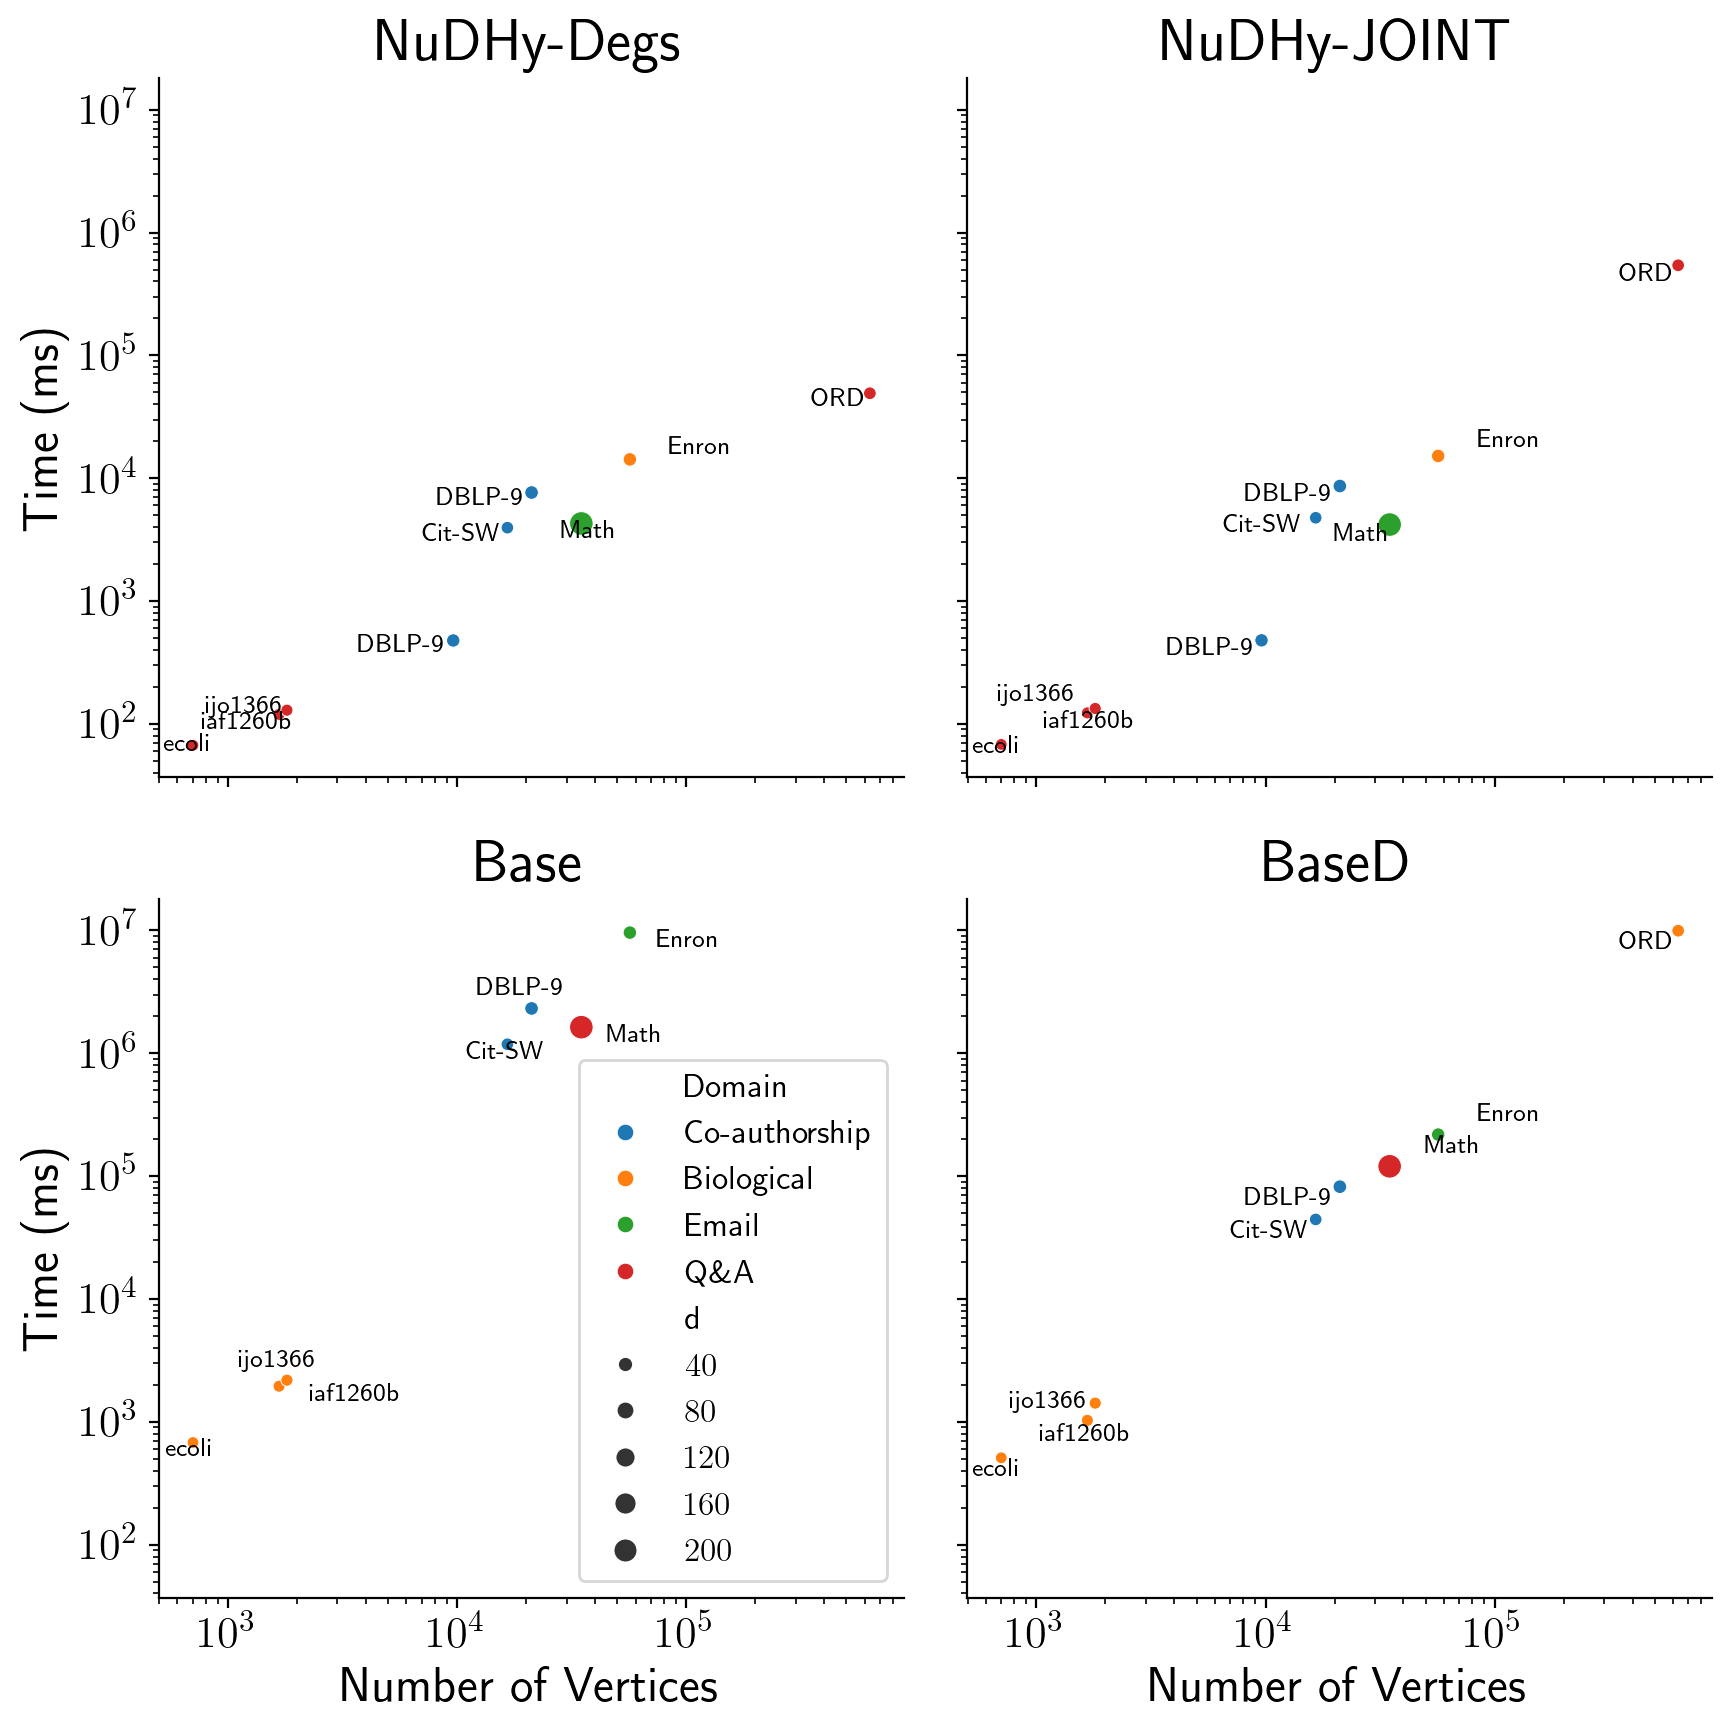

In [526]:
fig, ax = plt.subplots(2, 2, figsize=(9,9), sharex=True, sharey=True)

data = avg_runtimes[avg_runtimes['Sampler']!='NuDHy-Degs-MH']

for s, samp in enumerate(['NuDHy-Degs', 'NuDHy-JOINT', 'Base', 'BaseD']):
    
    r = s // 2
    c = s % 2
    ann = data[data['Sampler']==samp]
    sns.scatterplot(data=ann, x='n', y='Time (ms)', ax=ax[r][c],
                    size='d', hue='Domain')

    # add annotations
    texts = []
    for line in ann.index:
        tx = ax[r][c].text(ann['n'][line]+10, ann['Time (ms)'][line]+10, ann['DataSet'][line], 
                           horizontalalignment='left', fontsize=9, color='black')
        texts.append(tx)

    ax[r][c].set_yscale('log')
    ax[r][c].set_xscale('log')
    ax[r][c].set_title(samp)
    if r > 0:
        ax[r][c].set_xlabel('Number of Vertices')
    else:
        ax[r][c].set_xlabel('')
        ax[r][c].legend().remove()
    if c > 0:
        ax[r][c].legend().remove()
        ax[r][c].set_ylabel('')
    else:
        if r > 0:
            ax[r][c].legend(fontsize=12)

    adjustText.adjust_text(texts, avoid_self=True, expand=(1.2, 1.2), ax=ax[r][c])
plt.tight_layout()
plt.savefig(f'running_times.pdf', bbox_inches='tight')
plt.show()

# Convergence

In [1201]:
colors_conv = [
    "#119DA4", # cyan
    "#3D1308", # brown
]

palette = sns.color_palette(colors_conv)

In [1202]:
combo_names = {0 : r'$\mathcal{D}_{V,1}$',
               1 : r'$\mathcal{D}_{V,-1}$'}

In [1203]:
result_dir = results_path + 'convergence'
seed = 0

Read Data

In [1204]:
conv_db = ['eco01100', 'metabolic_iaf1260b', 'metabolic_ijo1366', 
           'citation_software', 'dblp_v9', 'enron', 'qna_math', 'uspto19762016']

In [1205]:
dfs = []
for db in conv_db:
    try:
        with open(f'{data_path}/{db}.tsv') as in_f:
            _, edges = read_as_edge_list(in_f, dict())
        file = f'{result_dir}/Convergence__Dataset_{db}.tsv__sampleNumber_{seed}__k_20__size_3'
        tmp_df = pd.read_csv(file, sep=' ')
        tmp_df['NumOnes'] = len(edges)
        dfs.append(tmp_df)
    except Exception as e:
        print(db, e)
conv_df = pd.concat(dfs)
conv_df.drop(columns=['Date'], inplace=True)

In [1206]:
conv_df['NumSwapsFactor'] = conv_df['iterations'] / conv_df['NumOnes']
conv_df['NumSwapsFactor'] = conv_df['NumSwapsFactor'].apply(lambda x : round(x, 2))

Combo to Plot

In [1207]:
idxs = {'eco01100': 0, 
        'dblp_v9': 0, 
        'enron': 1, 
        'qna_math': 1,
        'uspto19762016': 0, 
        'metabolic_iaf1260b': 0, 
        'metabolic_ijo1366': 0,
        'citation_software': 0
        }

styles = ['-', '--']

In [1208]:
def pprint(x,y):
    return '$\\textsc{'+x+'}$:'+y

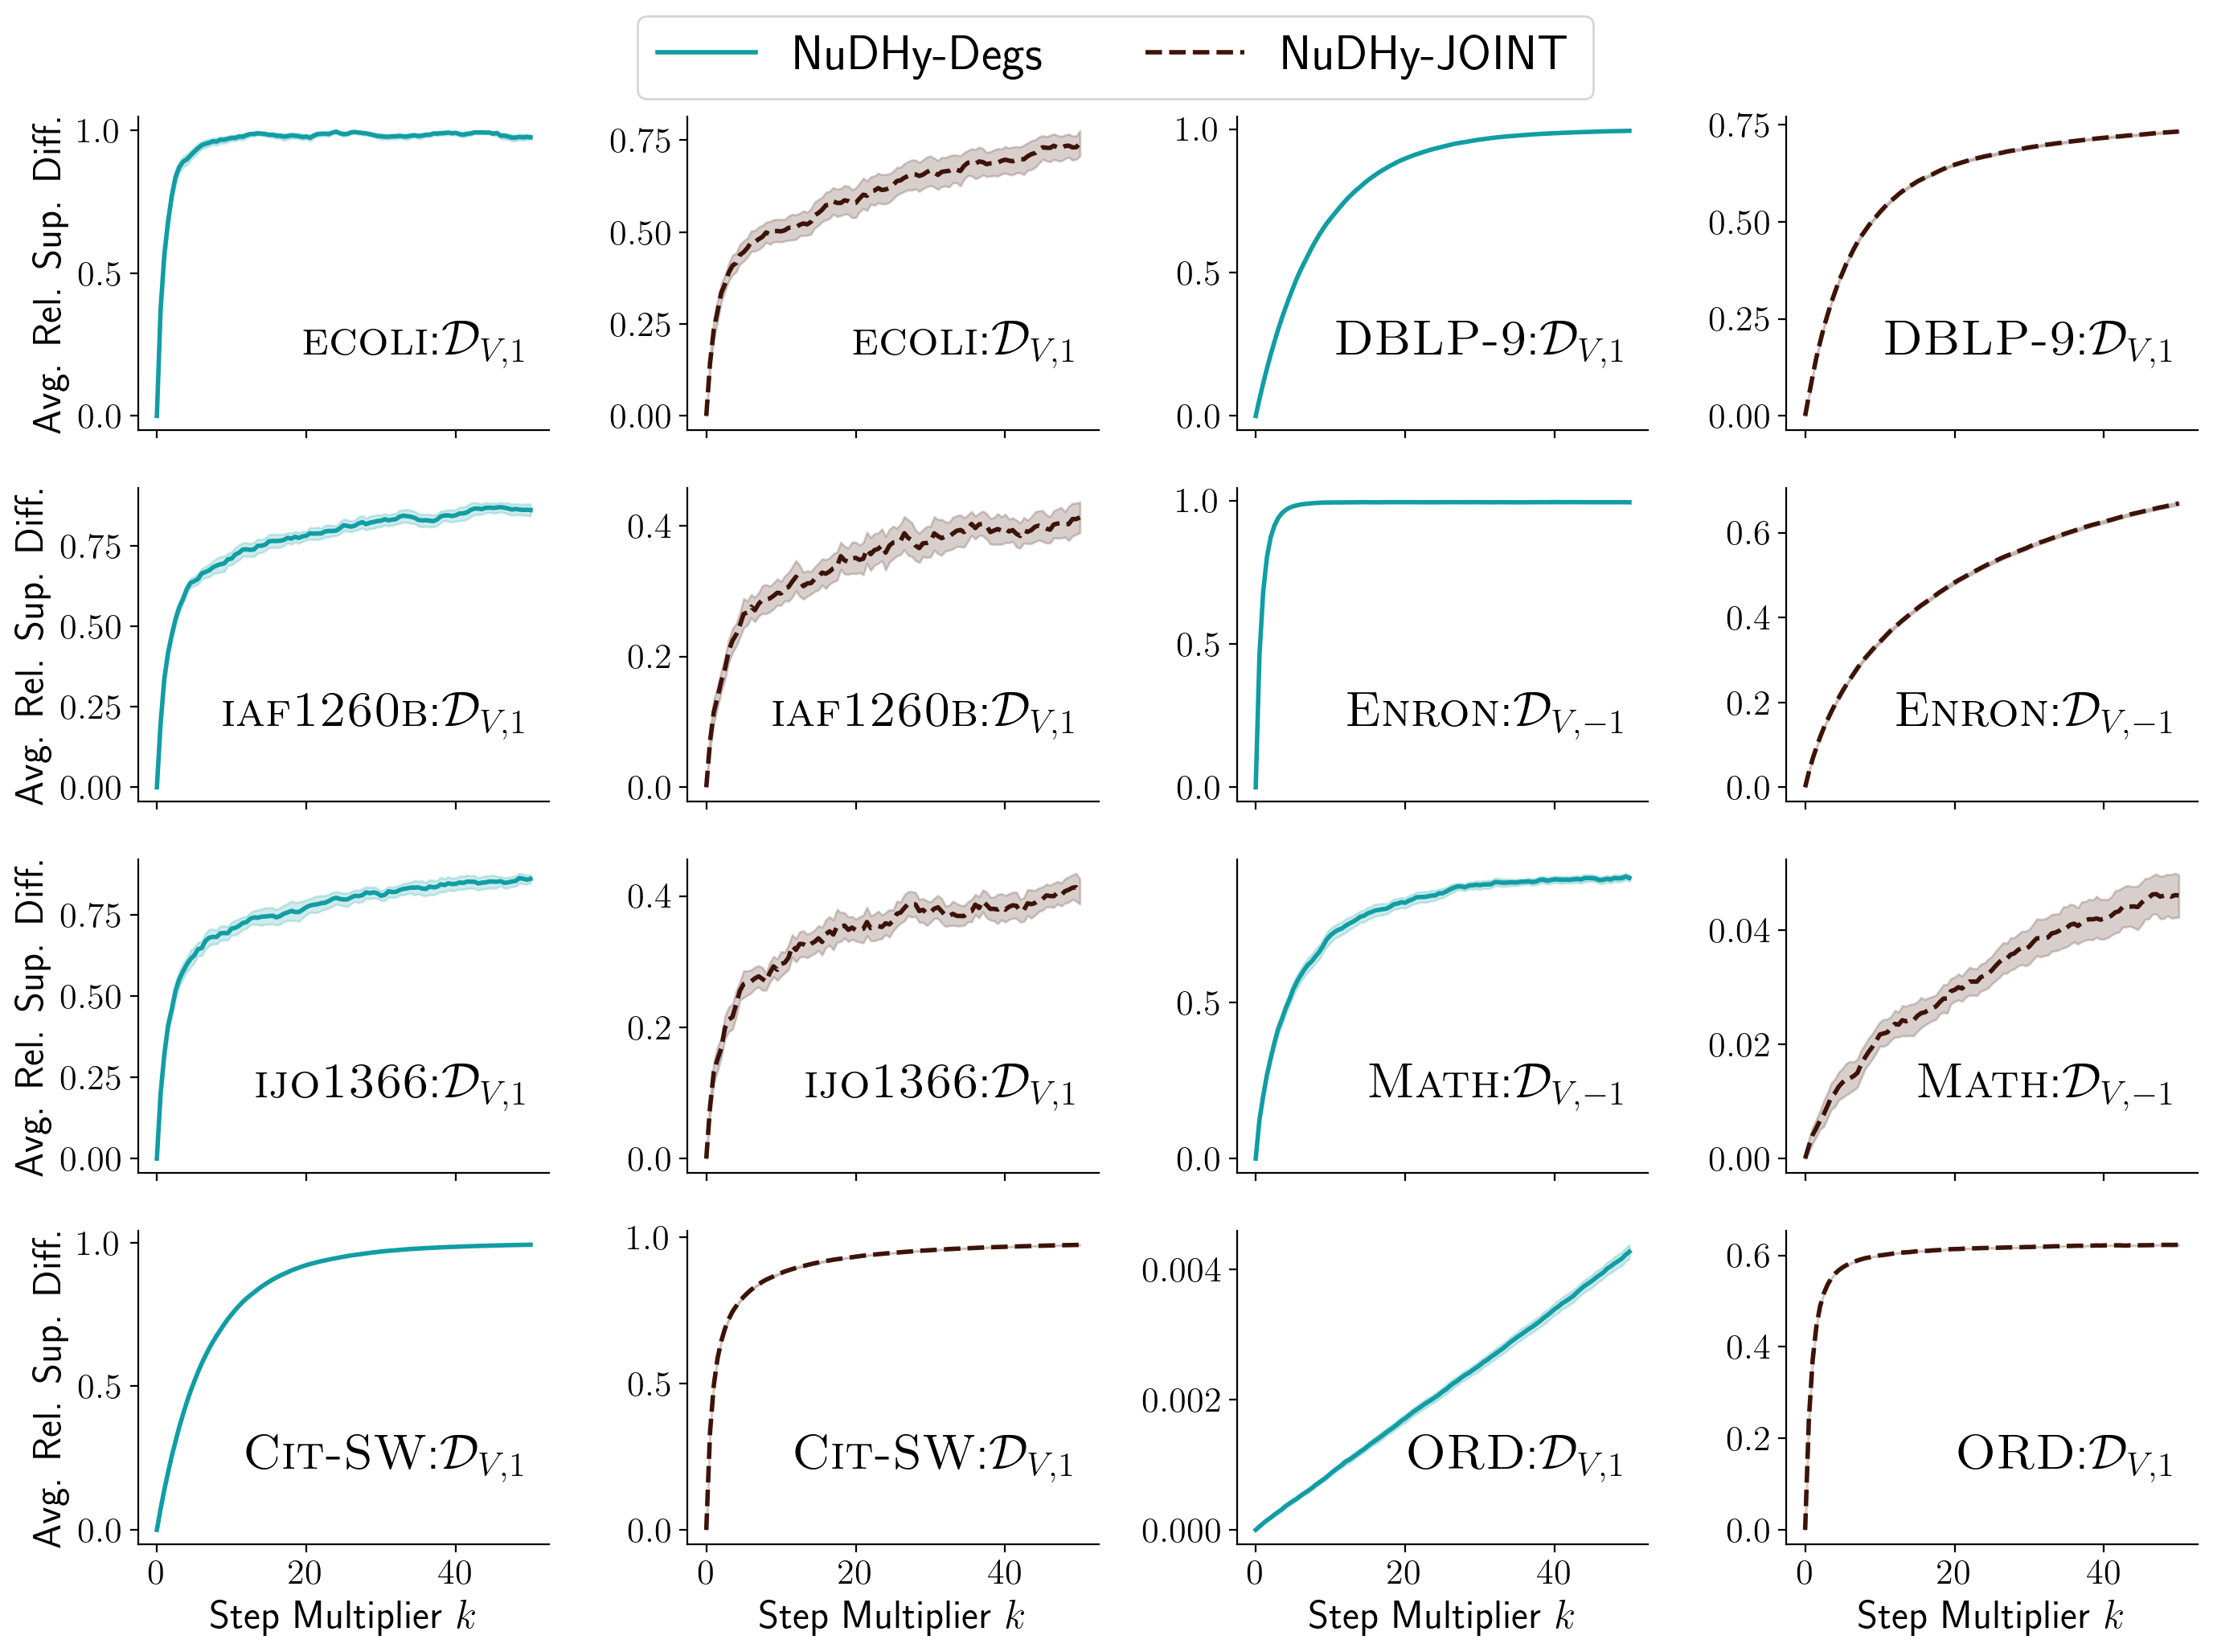

In [1225]:
fig, ax = plt.subplots(4, 4, figsize=(14,10), sharex=True)

for did, dataset in enumerate(conv_df['Dataset'].unique()):
    
    cid = (did // 4) * 2
    rid = did % 4

    data = conv_df[(conv_df['Dataset']==dataset)]
    algos = sorted(list(data['algorithm'].unique()))
    
    data1 = data[data['algorithm']=='NuDHy_A']
    sns.lineplot(data=data1, x='NumSwapsFactor', y=f'AvgRelFreqDiff_{idxs[dataset]}', 
                 color=colors_conv[0], ax=ax[rid][cid],
                 linestyle=styles[0], linewidth=2, label='NuDHy_A')
    ax[rid][cid].set_xlabel(r'Step Multiplier $k$', fontsize=18)
    if cid == 0:
        ax[rid][cid].set_ylabel('Avg. Rel. Sup. Diff.', fontsize=18)
    else:
        ax[rid][cid].set_ylabel('')
    ax[rid][cid].text(0.95, .35, r'{}'.format(pprint(dataset_names[dataset], combo_names[idxs[dataset]])), 
                      ha='right', va='top', transform=ax[rid][cid].transAxes, 
                      color='black', fontsize=22)

    data2 = data[data['algorithm']=='NuDHy_C']  
    sns.lineplot(data=data2, x='NumSwapsFactor', y=f'AvgRelFreqDiff_{idxs[dataset]}',
                 color=colors_conv[1], ax=ax[rid][cid+1],
                 linestyle=styles[1], linewidth=2, label='NuDHy_C')
    ax[rid][cid+1].set_xlabel(r'Step Multiplier $k$', fontsize=18)
    ax[rid][cid+1].set_ylabel('')
    ax[rid][cid+1].text(0.95, .35, r'{}'.format(pprint(dataset_names[dataset], combo_names[idxs[dataset]])), 
                        ha='right', va='top', transform=ax[rid][cid+1].transAxes, 
                        color='black', fontsize=22)
    
    handles = ax[rid][cid].legend().legend_handles
    handles.extend(ax[rid][cid+1].legend().legend_handles)
    [h.set_markersize(8) for h in handles]
    labels = [text.get_text() for text in ax[rid][cid].legend().get_texts()]
    labels.extend([text.get_text() for text in ax[rid][cid+1].legend().get_texts()])
    labels = [sampler_names.get(l) for l in labels]
    ax[rid][cid].legend().remove()
    ax[rid][cid+1].legend().remove()

fig.legend(handles=handles, labels=labels, loc='upper center', markerscale=2.,
           bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=22)

plt.tight_layout()
plt.savefig(f'convergence_all_k20_s3.pdf', bbox_inches='tight')
plt.show()